In [1]:
#| hide
from kaust.core import *
from kaust.util import *

In [2]:
#| hide
import os
import tqdm
import math
import torch
import torch.nn as nn
import gpytorch
from matplotlib import pyplot as plt
import numpy as np
import scipy
import pandas as pd
from torch.utils.data import Dataset, DataLoader, TensorDataset
from scipy.stats import norm
import sklearn.mixture as skl_mix
import itertools
import seaborn as sns
import warnings
from scipy.special import kv
import importlib
import kaust.core as lhtcore
import kaust.util as lhtutil

In [131]:
#| hide
importlib.reload(lhtcore)
importlib.reload(lhtutil)

<module 'kaust.util' from '/home/hxl170008/code/KAUST/project/V00/kaust/util.py'>

In [4]:
#| hide
warnings.filterwarnings("ignore")

# KAUST - Version 00

> KAUST

This file will become your README and also the index of your documentation.

In [24]:
def lht_matern_old(dist,nu,sigma, beta,nugget):
    diff = dist.where(dist > 0, torch.as_tensor(1e-20).to(dist.device))
    SS = sigma ** 2
    g = nu.lgamma().exp()
    A = torch.as_tensor(2.).pow(1-nu).div(g).mul(sigma).mul(sigma)
    B = diff.div(beta).pow(nu)
    pa = diff.div(beta)
    K = kv(nu.item(), pa.cpu().detach().numpy())
    K = torch.from_numpy(K).float().to(dist.device)
    K = K.clip(max = torch.as_tensor(1e+10,dtype=torch.float32), min=1e-12)
    N = dist.where(dist > 0, torch.as_tensor(nugget.pow(2)))
    ret = A.mul(B).mul(K) + N
    #ret = SS - ret       
    return ret

def lht_matern(dist,nu,sigma, beta,nugget):
    diff = dist.where(dist > 0, torch.as_tensor(1e-20).to(dist.device))
    SS = sigma ** 2
    g = nu.lgamma().exp()
    A = torch.as_tensor(2.).pow(1-nu).div(g).mul(sigma).mul(sigma)
    B = diff.div(beta).pow(nu)
    pa = diff.div(beta)
    K = kv(nu.item(), pa.cpu().detach().numpy())
    K = torch.from_numpy(K).float().to(dist.device)
    K = K.clip(max = torch.as_tensor(1e+10,dtype=torch.float32), min=1e-12)
    #
    ind = torch.zeros_like(diff)
    ind[diff<=1e-20]=1
    N = ind * nugget.pow(2)
    #
    #N = dist.where(dist > 0, torch.as_tensor(nugget.pow(1)))
    ret = A.mul(B).mul(K) + N
    #ret = SS - ret       
    return ret

def lht_show_matern(kern, title, dist, prior='gamma',ax=None,st=5000):
    if ax is None:
        fig, ax = plt.subplots()
    dfs=[]
    if prior=='gamma':
        nu_prior = gpytorch.priors.GammaPrior(kern.nu_a.detach(), kern.nu_b.detach())
        sigma_prior = gpytorch.priors.GammaPrior(kern.sigma_a, kern.sigma_b)
        beta_prior = gpytorch.priors.GammaPrior(kern.beta_a, kern.beta_b)
        nugget_prior = gpytorch.priors.GammaPrior(kern.nugget_a, kern.nugget_b)
    else:
        nu_prior = gpytorch.priors.HalfNormalPrior(kern.nu_scale.detach())
        sigma_prior = gpytorch.priors.HalfNormalPrior(kern.sigma_scale.detach())
        beta_prior = gpytorch.priors.HalfNormalPrior(kern.beta_scale.detach())
        nugget_prior = gpytorch.priors.HalfNormalPrior(kern.nugget_scale.detach())
    for i in range(st):
        nu_lp, sigma_lp, beta_lp, nugget_lp = nu_prior.sample(), sigma_prior.sample(), beta_prior.sample(), nugget_prior.sample() + kern.nugget
        cov_matern_ci = lht_matern(dist,nu_lp,sigma_lp,beta_lp,nugget_lp)
        label = np.zeros_like(dist.numpy())+i
        d = pd.DataFrame({'distance':dist.numpy(), 'covariance':cov_matern_ci.numpy(), 'label':label}, )
        dfs.append(d)

    dd = pd.concat(dfs).reset_index()
    ax = sns.lineplot(data=dd, x='distance', y='covariance', ax=ax)
    ax.set_title(title)

In [6]:
#| hide
def test_records(df, inducing_points, records, model_type='standard', prior='gamma', cuda=False, mae_threshold=1):
    points = df.to_numpy()
    X = points[:,0:2]
    Y = points[:,2]
    yy = torch.from_numpy(Y).float()
    tx = torch.from_numpy(X).float()
    if cuda:
        yy, tx = yy.cuda(), tx.cuda()
    riter = tqdm.notebook.tqdm(records, desc='verify')
    ret={'mae':[], 'acc':[]}
    for idx,i in enumerate(riter):
        print(f"{idx}: mae: {i['mae']}, acc: {i['acc']}")
        if i['mae'] >=mae_threshold:
            continue
        state_dict_path = i['param']
        state_dict = torch.load(state_dict_path)
        if model_type=='standard':
            model = StandardApproximateGP_mat(inducing_points=inducing_points, nu=2.5)
        else:
            model = GP_AFirst(inducing_points.cpu(), prior=prior)
        model.load_state_dict(state_dict)
        if cuda:
            model = model.cuda()
        else:
            model = model.cpu()
        model.eval()
        
        preds = model(tx)
        means = preds.mean.cpu()
        error = torch.mean(torch.abs(means - yy.cpu()))
        l,v = preds.loc.cpu().detach().numpy(), preds.stddev.cpu().detach().numpy()
        ci = scipy.stats.norm.interval(0.95, loc=l, scale=v)
        LB,UB = ci
        a = np.logical_and(Y>=LB, Y<=UB)
        acc = Y[a].shape[0] / len(Y)
        ret['mae'].append(error.item())
        ret['acc'].append(acc)
        print(f"num:{Y[a].shape[0]}, acc:{acc}, mae:{error.item()}")
    return ret

# Datasets

In [7]:
class DSPath:
    a1_train_1 = "/home/hxl170008/code/KAUST/data/train/a1_train_1.csv"
    a1_train_2 = "/home/hxl170008/code/KAUST/data/train/a1_train_2.csv"
    a1_train_3 = "/home/hxl170008/code/KAUST/data/train/a1_train_3.csv"
    a1_train_4 = "/home/hxl170008/code/KAUST/data/train/a1_train_4.csv"
    a1_train_5 = "/home/hxl170008/code/KAUST/data/train/a1_train_5.csv"
    
    a2_train_1 = "/home/hxl170008/code/KAUST/data/train/a2_train_1.csv"
    a2_train_2 = "/home/hxl170008/code/KAUST/data/train/a2_train_2.csv"
    a2_train_3 = "/home/hxl170008/code/KAUST/data/train/a2_train_3.csv"
    a2_train_4 = "/home/hxl170008/code/KAUST/data/train/a2_train_4.csv"
    a2_train_5 = "/home/hxl170008/code/KAUST/data/train/a2_train_5.csv"
    
    a2_test1_1  = "/home/hxl170008/code/KAUST/data/test/1/LOC_Test1_1.csv"
    a2_test1_2  = "/home/hxl170008/code/KAUST/data/test/1/LOC_Test1_2.csv"
    a2_test1_3  = "/home/hxl170008/code/KAUST/data/test/1/LOC_Test1_3.csv"
    a2_test1_4  = "/home/hxl170008/code/KAUST/data/test/1/LOC_Test1_4.csv"
    
    a2_test2_1  = "/home/hxl170008/code/KAUST/data/test/2/LOC_Test2_1.csv"
    a2_test2_2  = "/home/hxl170008/code/KAUST/data/test/2/LOC_Test2_2.csv"
    a2_test2_3  = "/home/hxl170008/code/KAUST/data/test/2/LOC_Test2_3.csv"
    a2_test2_4  = "/home/hxl170008/code/KAUST/data/test/2/LOC_Test2_4.csv"
    a2_test2_5  = "/home/hxl170008/code/KAUST/data/test/2/LOC_Test2_5.csv"
    
    fp_a11 = "model/a1_train_1_scv_mae_acc.pth"
    fp_a12 = "model/a1_train_2_scv_mae_acc.pth"
    fp_a13 = "model/a1_train_3_scv_mae_acc.pth"
    fp_a14 = "model/a1_train_4_scv_mae_acc.pth"
    fp_a15 = "model/a1_train_5_scv_mae_acc.pth"
    
    fp_a21 = "model/a2_train_1_scv_mae_acc.pth"
    fp_a22 = "model/a2_train_2_scv_mae_acc.pth"
    fp_a23 = "model/a2_train_3_scv_mae_acc.pth"
    fp_a24 = "model/a2_train_4_scv_mae_acc.pth"
    fp_a25 = "model/a2_train_5_scv_mae_acc.pth"

opt = DSPath()

# parameter estimation - nu, sigma, beta, nugget 

In [75]:
data_paths = [opt.a1_train_1,opt.a1_train_2,opt.a1_train_3,opt.a1_train_4,opt.a1_train_5,]
model_paths = [opt.fp_a11,opt.fp_a12,opt.fp_a13,opt.fp_a14,opt.fp_a15]
priors =['gamma','gamma','gamma','gamma','gamma']
inducing_points = torch.load("model/ip500.pt")
for dp, mp, prior in zip(data_paths, model_paths, priors):
    df = pd.read_csv(dp)
    points = df.to_numpy()
    X = points[:,0:2]
    Y = points[:,2]
    yy = torch.from_numpy(Y).float()
    tx = torch.from_numpy(X).float()
    state_dict = torch.load(mp)
    model = GP_AFirst(inducing_points.cpu(), prior=prior)
    model.load_state_dict(state_dict)
    model.eval()
    preds = model(tx)
    means = preds.mean.cpu()
    error = torch.mean(torch.abs(means - yy.cpu()))
    l,v = preds.loc.cpu().detach().numpy(), preds.stddev.cpu().detach().numpy()
    ci = norm.interval(0.95, loc=l, scale=v)
    LB,UB = ci
    a = np.logical_and(Y>=LB, Y<=UB)
    acc = Y[a].shape[0] / len(Y)
    print(f"num:{Y[a].shape[0]}, acc:{acc}, mae:{error.item()}")
    

num:82849, acc:0.9205444444444445, mae:0.6309915781021118
num:87164, acc:0.9684888888888888, mae:1.5223673582077026
num:81594, acc:0.9066, mae:1.1367924213409424
num:82475, acc:0.9163888888888889, mae:0.8883066177368164
num:84601, acc:0.9400111111111111, mae:1.1588916778564453


num:82377, acc:0.9153, mae:0.6937220096588135
num:84486, acc:0.9387333333333333, mae:0.9212958216667175
num:81040, acc:0.9004444444444445, mae:1.1351665258407593
num:85039, acc:0.9448777777777778, mae:0.903706431388855
num:84883, acc:0.9431444444444445, mae:1.1655200719833374


In [79]:
data_paths = [opt.a1_train_1,opt.a1_train_2,opt.a1_train_3,opt.a1_train_4,opt.a1_train_5,]
model_paths = [opt.fp_a11,opt.fp_a12,opt.fp_a13,opt.fp_a14,opt.fp_a15]
priors =['gamma','gamma','gamma','gamma','gamma']
inducing_points = torch.load("model/ip500.pt")
ret={'lc_sigma_squared':[], 'uc_sigma_squared':[], 'lc_beta':[],'uc_beta':[], 'lc_nu':[], 'uc_nu':[], 'lc_tau_squared':[], 'uc_tau_squared':[]}
for dp, mp, prior in zip(data_paths, model_paths, priors):
    state_dict = torch.load(mp)
    model = GP_AFirst(inducing_points.cpu(), prior=prior)
    model.load_state_dict(state_dict)
    model.eval()
    c = CI_NSBN(model)
    lc_sigma_squared = round(c['sigma'][0] ** 2,6)
    uc_sigma_squared = round(c['sigma'][1] ** 2,6)
    lc_beta = round(c['beta'][0],6)
    uc_beta = round(c['beta'][1],6)
    lc_nu = round(c['nu'][0],6)
    uc_nu = round(c['nu'][1],6)
    lc_tau_squared = round(c['nugget'][0] ** 2, 6)
    uc_tau_squared = round(c['nugget'][1] ** 2, 6)
    ret['lc_sigma_squared'].append(lc_sigma_squared)
    ret['uc_sigma_squared'].append(uc_sigma_squared)
    ret['lc_beta'].append(lc_beta)
    ret['uc_beta'].append(uc_beta)
    ret['lc_nu'].append(lc_nu)
    ret['uc_nu'].append(uc_nu)
    ret['lc_tau_squared'].append(lc_tau_squared)
    ret['uc_tau_squared'].append(uc_tau_squared)
#
#
df_1a = pd.DataFrame(ret)
df_1a

lc_sigma_squared  uc_sigma_squared   lc_beta    uc_beta     lc_nu  \
0          0.000000          3.317626  0.618789   5.793388  3.140696   
1          0.000524          5.568894  0.091155   3.024829  0.007734   
2          0.058085         21.353244  0.609811  14.975479  2.958900   
3          0.000000          0.697631  0.481255   9.444796  1.132622   
4          0.000000          2.870064  2.933482  30.251703  1.484189   

       uc_nu  lc_tau_squared  uc_tau_squared  
0  48.377755        0.000000        0.000000  
1   1.179772        0.041816        5.478308  
2  37.633465        0.000000        0.000000  
3  24.565082        0.002239        5.807008  
4  29.500865        0.000000        0.017730

In [80]:
fn = "/home/hxl170008/code/KAUST/out/TeamName-1a.csv"
df_1a.to_csv(fn, index=False, header=list(ret.keys()))

pd.read_csv(fn).head()

lc_sigma_squared  uc_sigma_squared   lc_beta    uc_beta     lc_nu  \
0          0.000000          3.317626  0.618789   5.793388  3.140696   
1          0.000524          5.568894  0.091155   3.024829  0.007734   
2          0.058085         21.353244  0.609811  14.975479  2.958900   
3          0.000000          0.697631  0.481255   9.444796  1.132622   
4          0.000000          2.870064  2.933482  30.251703  1.484189   

       uc_nu  lc_tau_squared  uc_tau_squared  
0  48.377755        0.000000        0.000000  
1   1.179772        0.041816        5.478308  
2  37.633465        0.000000        0.000000  
3  24.565082        0.002239        5.807008  
4  29.500865        0.000000        0.017730

# a1_train_1

In [6]:
#| hide
fp = opt.a1_train_1
df = pd.read_csv(fp)
points = df.to_numpy()
X = points[:,0:2]
Y = points[:,2].reshape(-1,1)

Text(0.5, 1.0, 'a1_train_1')

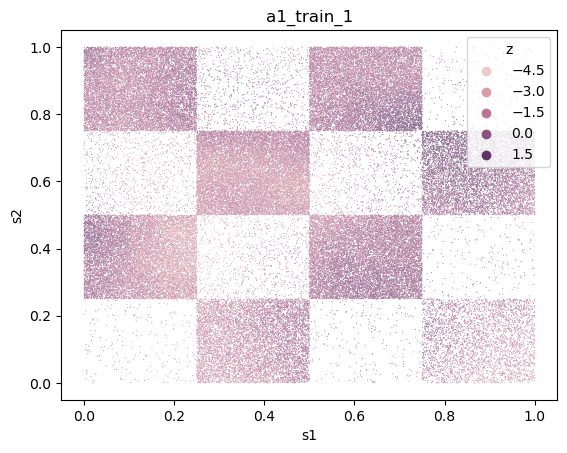

In [321]:
ax = sns.scatterplot(data=df, x='s1', y='s2', hue='z', s=0.5)
ax.set_title("a1_train_1")

<AxesSubplot:xlabel='z', ylabel='Density'>

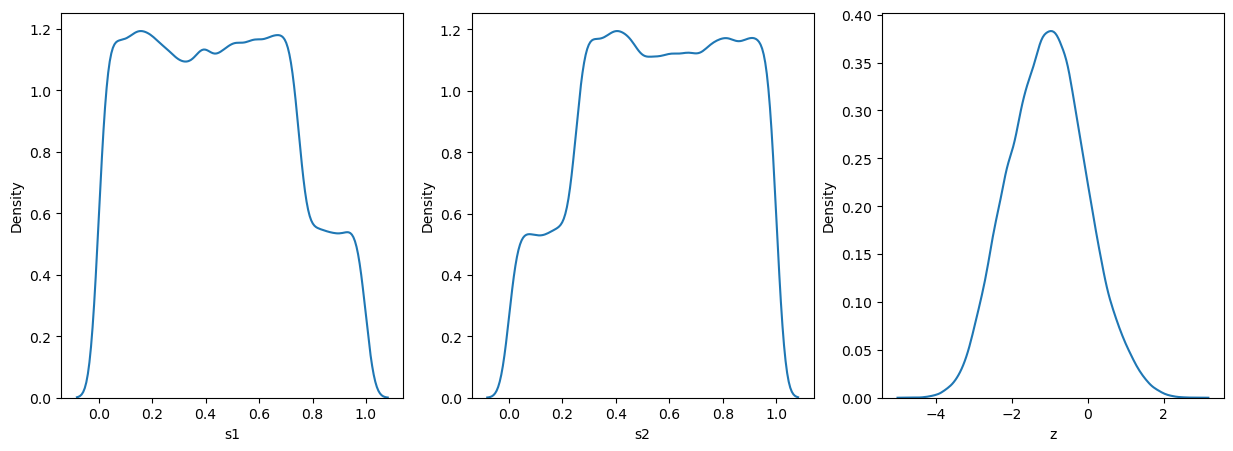

In [9]:
fig,axes = plt.subplots(1,3, figsize=(15,5))
sns.kdeplot(data=df, x='s1', ax=axes[0])
sns.kdeplot(data=df, x='s2', ax=axes[1])
sns.kdeplot(data=df, x='z', ax=axes[2])

## Spatial Cross Validation

### HalfNorm Prior

In [241]:
#| hide
fp = opt.a1_train_1
df = pd.read_csv(fp)
points = df.to_numpy()
nugget = 0.25
varogram_dist = 0.25
#
a = np.arange(len(points))
b = np.random.choice(a,500,replace=False)
inducing_points = torch.from_numpy(points[b,0:2]).float()
#
folder = 'model/a1_train_1_norm'
if not os.path.isdir(folder):
    os.mkdir(folder)
#
prior='halfnorm'
lr = 0.0001
base_lr=0.001
lr_step=100
device = torch.device("cpu")

best_params = {'acc':0, 'mae':2, 'acc_mae':0}

In [125]:
model = lhtcore.GP_AFirst(inducing_points,nu=1, max_tries=200,prior=prior,nugget=nugget)
likelihood = gpytorch.likelihoods.GaussianLikelihood()  
model.to(device)
likelihood.to(device)
params = list(model.parameters()) + list(likelihood.parameters())
optimizer = torch.optim.Adam(params, lr = lr, weight_decay=0.01 )
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=lr_step, eta_min=base_lr)

In [242]:
#| hide
num_epochs = 5 # 1200
num_iter = tqdm.notebook.tqdm(range(0,num_epochs))
for epoch in num_iter:
    #
    model = lhtcore.GP_AFirst(inducing_points,nu=1, max_tries=200,prior=prior,nugget=nugget)
    likelihood = gpytorch.likelihoods.GaussianLikelihood()  
    mll = gpytorch.mlls.PredictiveLogLikelihood(likelihood, model, num_data=len(points))
    model.to(device)
    likelihood.to(device)
    params = list(model.parameters()) + list(likelihood.parameters())
    optimizer = torch.optim.Adam(params, lr = lr, weight_decay=0.01 )
    lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=lr_step, eta_min=base_lr)
    #
    lhtutil.lht_train_one_epoch(model,optimizer,likelihood,mll,points,device,lr_scheduler=None,batch_size=200)
    ret_test = lhtutil.lht_test(model,points,device,flag=True)
    acc, mae = ret_test['acc'], ret_test['mae']
    if acc > best_params['acc']:
        best_params['acc'] = acc
        param_fp = os.path.join(folder, f'best_acc.pth')
        torch.save(model.state_dict(), param_fp) 
    #
    if mae < best_params['mae']:
        best_params['mae'] = mae
        param_fp = os.path.join(folder, f'best_mae.pth')
        torch.save(model.state_dict(), param_fp)
    #
    acc_mae = acc / mae
    if acc_mae > best_params['acc_mae']:
        best_params['acc_mae'] = acc_mae
        param_fp = os.path.join(folder, f'best_acc_mae.pth')
        torch.save(model.state_dict(), param_fp)
        

  0%|          | 0/5 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/450 [00:00<?, ?it/s]

test:   0%|          | 0/450 [00:00<?, ?it/s]

num:59488, acc:0.6609777777777778, mae:0.8951544165611267


Minibatch:   0%|          | 0/450 [00:00<?, ?it/s]

test:   0%|          | 0/450 [00:00<?, ?it/s]

num:89999, acc:0.9999888888888889, mae:1.0893553495407104


Minibatch:   0%|          | 0/450 [00:00<?, ?it/s]

test:   0%|          | 0/450 [00:00<?, ?it/s]

num:81086, acc:0.9009555555555555, mae:1.0985841751098633


Minibatch:   0%|          | 0/450 [00:00<?, ?it/s]

test:   0%|          | 0/450 [00:00<?, ?it/s]

num:80125, acc:0.8902777777777777, mae:1.1007107496261597


Minibatch:   0%|          | 0/450 [00:00<?, ?it/s]

test:   0%|          | 0/450 [00:00<?, ?it/s]

num:89999, acc:0.9999888888888889, mae:1.0543115139007568


  0%|          | 0/4 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/450 [00:00<?, ?it/s]

test:   0%|          | 0/450 [00:00<?, ?it/s]

num:89758, acc:0.9973111111111111, mae:0.8009759783744812


Minibatch:   0%|          | 0/450 [00:00<?, ?it/s]

test:   0%|          | 0/450 [00:00<?, ?it/s]

num:85930, acc:0.9547777777777777, mae:0.7579382061958313


Minibatch:   0%|          | 0/450 [00:00<?, ?it/s]

test:   0%|          | 0/450 [00:00<?, ?it/s]

num:83413, acc:0.9268111111111111, mae:0.7613765597343445


Minibatch:   0%|          | 0/450 [00:00<?, ?it/s]

test:   0%|          | 0/450 [00:00<?, ?it/s]

num:86498, acc:0.9610888888888889, mae:0.6830339431762695


In [224]:
best_params

{'acc': 0.9999888888888889,
 'mae': 0.7418859601020813,
 'acc_mae': 1.1846702406896978}

In [237]:
folder = 'model/a1_train_1_norm'
nugget = 0.25
state_dict_path = os.path.join(folder,'best_acc.pth')
state_dict = torch.load(state_dict_path)
model = model = lhtcore.GP_AFirst(inducing_points,nu=1, max_tries=200,prior=prior,nugget=nugget)
model.load_state_dict(state_dict)
kern = model.covar_module.base_kernel
#ret=lhtutil.lht_test(model,points,device,flag=True)

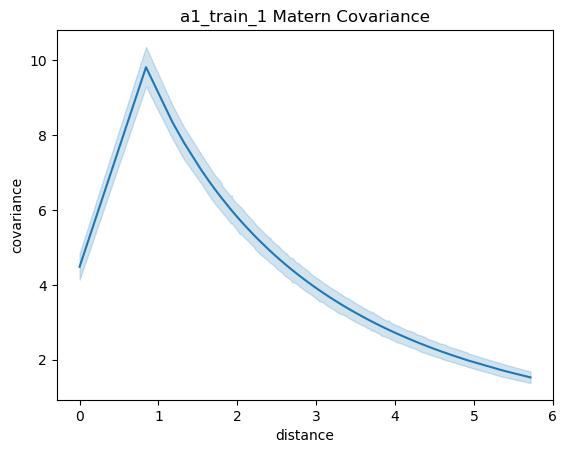

In [234]:
a = torch.randn(100,2)
a = a - a[0]
dist = torch.linalg.norm(a,dim=1)
lht_show_matern(kern, 'a1_train_1 Matern Covariance', dist, prior=prior)

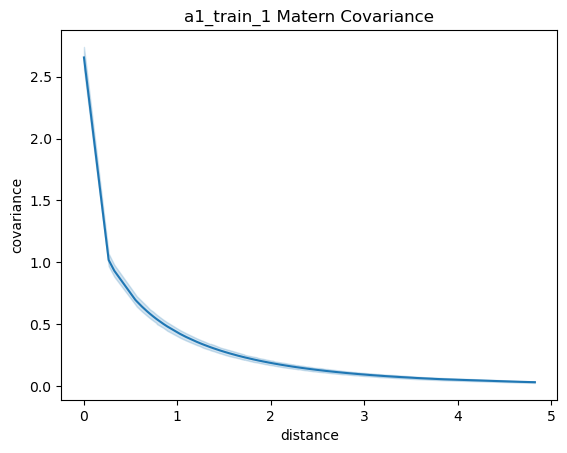

In [156]:
a = torch.randn(100,2)
a = a - a[0]
dist = torch.linalg.norm(a,dim=1)
lht_show_matern(kern, 'a1_train_1 Matern Covariance', dist, prior=prior)

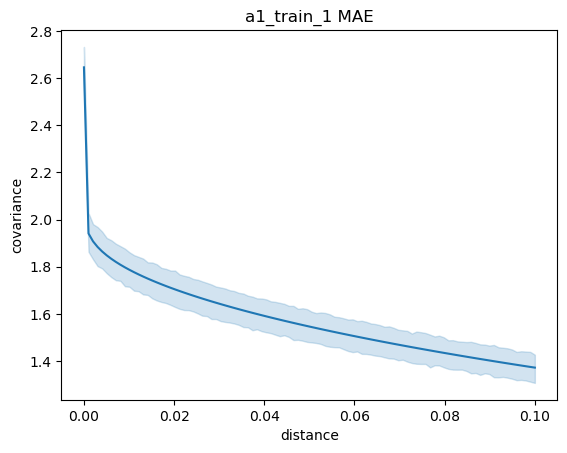

In [154]:
dist = torch.linspace(0,0.1,100)
lht_show_matern(kern, 'a1_train_1 MAE', dist, prior=prior)

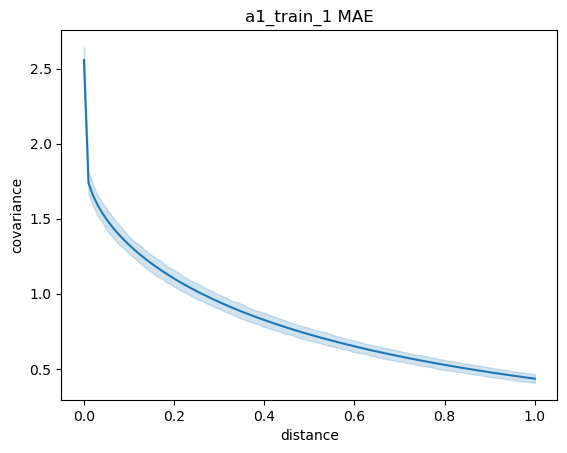

In [157]:
dist = torch.linspace(0,1,100)
lht_show_matern(kern, 'a1_train_1 MAE', dist, prior=prior)

In [155]:
# mae
lhtutil.showCI_NSBN(model)

nu     sigma      beta    nugget
0  0.016751  0.046238  0.031064  0.276900
1  1.198090  3.307101  2.221791  2.173964

### HalfNorm Prior- varigrom

In [27]:
#| hide
fp = opt.a1_train_1
df = pd.read_csv(fp)
nugget = 0.25
varogram_dist = 0.25
inducing_points = torch.load("model/ip500.pt")
folder = 'model/a1_train_1_norm/new'
if not os.path.isdir(folder):
    os.mkdir(folder)
#
prior='halfnorm'
lr = 0.01
base_lr=0.0001
lr_step=100
device = torch.device("cpu")
records = lhtutil.train_LhtMatern_step(df=df, varogram_dist=varogram_dist, inducing_points=inducing_points,base_lr=base_lr,
                               prior=prior, lr=lr, folder=folder,nugget=nugget,device=device, show_ci=False)

100%|█████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 6519.22it/s]


cross-validation:   0%|          | 0/16 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/341 [00:00<?, ?it/s]

test:   0%|          | 0/2 [00:00<?, ?it/s]

----Test:217-----


test:   0%|          | 0/2 [00:00<?, ?it/s]

num:176, acc:0.8110599078341014, mae:0.7648310661315918
----All:90000-----


test:   0%|          | 0/450 [00:00<?, ?it/s]

num:68187, acc:0.7576333333333334, mae:0.8252723217010498
------------------------------


Minibatch:   0%|          | 0/261 [00:00<?, ?it/s]

test:   0%|          | 0/64 [00:00<?, ?it/s]

----Test:12676-----


test:   0%|          | 0/64 [00:00<?, ?it/s]

num:5416, acc:0.42726412117387186, mae:1.2457551956176758
----All:90000-----


test:   0%|          | 0/450 [00:00<?, ?it/s]

num:53813, acc:0.5979222222222222, mae:0.9103690981864929
------------------------------


Minibatch:   0%|          | 0/234 [00:00<?, ?it/s]

test:   0%|          | 0/5 [00:00<?, ?it/s]

----Test:892-----


test:   0%|          | 0/5 [00:00<?, ?it/s]

num:326, acc:0.3654708520179372, mae:1.1569287776947021
----All:90000-----


test:   0%|          | 0/450 [00:00<?, ?it/s]

num:51655, acc:0.5739444444444445, mae:0.8954357504844666
------------------------------


Minibatch:   0%|          | 0/302 [00:00<?, ?it/s]

test:   0%|          | 0/64 [00:00<?, ?it/s]

----Test:12608-----


test:   0%|          | 0/64 [00:00<?, ?it/s]

num:10354, acc:0.8212246192893401, mae:0.512696385383606
----All:90000-----


test:   0%|          | 0/450 [00:00<?, ?it/s]

num:52761, acc:0.5862333333333334, mae:0.8389135599136353
------------------------------


Minibatch:   0%|          | 0/277 [00:00<?, ?it/s]

test:   0%|          | 0/41 [00:00<?, ?it/s]

----Test:8092-----


test:   0%|          | 0/41 [00:00<?, ?it/s]

num:5003, acc:0.6182649530400396, mae:0.7281375527381897
----All:90000-----


test:   0%|          | 0/450 [00:00<?, ?it/s]

num:51365, acc:0.5707222222222222, mae:0.8237361311912537
------------------------------


Minibatch:   0%|          | 0/192 [00:00<?, ?it/s]

test:   0%|          | 0/5 [00:00<?, ?it/s]

----Test:881-----


test:   0%|          | 0/5 [00:00<?, ?it/s]

num:173, acc:0.1963677639046538, mae:1.407623529434204
----All:90000-----


test:   0%|          | 0/450 [00:00<?, ?it/s]

num:45765, acc:0.5085, mae:0.9199777841567993
------------------------------


Minibatch:   0%|          | 0/104 [00:00<?, ?it/s]

test:   0%|          | 0/77 [00:00<?, ?it/s]

----Test:15240-----


test:   0%|          | 0/77 [00:00<?, ?it/s]

num:3772, acc:0.24750656167979002, mae:1.2903789281845093
----All:90000-----


test:   0%|          | 0/450 [00:00<?, ?it/s]

num:48867, acc:0.5429666666666667, mae:0.8796596527099609
------------------------------


Minibatch:   0%|          | 0/235 [00:00<?, ?it/s]

test:   0%|          | 0/5 [00:00<?, ?it/s]

----Test:912-----


test:   0%|          | 0/5 [00:00<?, ?it/s]

num:575, acc:0.6304824561403509, mae:0.673346996307373
----All:90000-----


test:   0%|          | 0/450 [00:00<?, ?it/s]

num:50040, acc:0.556, mae:0.8279975652694702
------------------------------


Minibatch:   0%|          | 0/322 [00:00<?, ?it/s]

test:   0%|          | 0/2 [00:00<?, ?it/s]

----Test:225-----


test:   0%|          | 0/2 [00:00<?, ?it/s]

num:111, acc:0.49333333333333335, mae:0.8332213163375854
----All:90000-----


test:   0%|          | 0/450 [00:00<?, ?it/s]

num:49420, acc:0.5491111111111111, mae:0.8209934830665588
------------------------------


Minibatch:   0%|          | 0/201 [00:00<?, ?it/s]

test:   0%|          | 0/64 [00:00<?, ?it/s]

----Test:12608-----


test:   0%|          | 0/64 [00:00<?, ?it/s]

num:7878, acc:0.6248413705583756, mae:0.6748867034912109
----All:90000-----


test:   0%|          | 0/450 [00:00<?, ?it/s]

num:48970, acc:0.5441111111111111, mae:0.8204732537269592
------------------------------


Minibatch:   0%|          | 0/192 [00:00<?, ?it/s]

test:   0%|          | 0/5 [00:00<?, ?it/s]

----Test:896-----


test:   0%|          | 0/5 [00:00<?, ?it/s]

num:455, acc:0.5078125, mae:0.9130671620368958
----All:90000-----


test:   0%|          | 0/450 [00:00<?, ?it/s]

num:47293, acc:0.5254777777777778, mae:0.846237301826477
------------------------------


Minibatch:   0%|          | 0/261 [00:00<?, ?it/s]

test:   0%|          | 0/63 [00:00<?, ?it/s]

----Test:12580-----


test:   0%|          | 0/63 [00:00<?, ?it/s]

num:7774, acc:0.6179650238473768, mae:0.7411187291145325
----All:90000-----


test:   0%|          | 0/450 [00:00<?, ?it/s]

num:48665, acc:0.5407222222222222, mae:0.822917640209198
------------------------------


Minibatch:   0%|          | 0/367 [00:00<?, ?it/s]

test:   0%|          | 0/18 [00:00<?, ?it/s]

----Test:3597-----


test:   0%|          | 0/18 [00:00<?, ?it/s]

num:2385, acc:0.6630525437864887, mae:0.6304230093955994
----All:90000-----


test:   0%|          | 0/450 [00:00<?, ?it/s]

num:48527, acc:0.5391888888888889, mae:0.8217640519142151
------------------------------


Minibatch:   0%|          | 0/322 [00:00<?, ?it/s]

test:   0%|          | 0/2 [00:00<?, ?it/s]

----Test:222-----


test:   0%|          | 0/2 [00:00<?, ?it/s]

num:87, acc:0.3918918918918919, mae:0.9629442095756531
----All:90000-----


test:   0%|          | 0/450 [00:00<?, ?it/s]

num:46736, acc:0.5192888888888889, mae:0.8478413224220276
------------------------------


Minibatch:   0%|          | 0/277 [00:00<?, ?it/s]

test:   0%|          | 0/41 [00:00<?, ?it/s]

----Test:8131-----


test:   0%|          | 0/41 [00:00<?, ?it/s]

num:712, acc:0.0875661050301316, mae:1.8009275197982788
----All:90000-----


test:   0%|          | 0/450 [00:00<?, ?it/s]

num:44671, acc:0.4963444444444444, mae:0.8868376612663269
------------------------------


Minibatch:   0%|          | 0/341 [00:00<?, ?it/s]

test:   0%|          | 0/2 [00:00<?, ?it/s]

----Test:223-----


test:   0%|          | 0/2 [00:00<?, ?it/s]

num:28, acc:0.12556053811659193, mae:1.6384533643722534
----All:90000-----


test:   0%|          | 0/450 [00:00<?, ?it/s]

num:46315, acc:0.5146111111111111, mae:0.8465018272399902
------------------------------


In [28]:
mae = [ret['mae'] for ret in records]
acc = [ret['acc'] for ret in records]
mae = np.array(mae)
acc = np.array(acc)
am = acc/mae
idx = am.argmax()
print(f"ids:{idx}, mae:{mae[idx]}, acc:{acc[idx]}")

ids:0, mae:0.8252723217010498, acc:0.7576333333333334


#### HalfNorm Prior - old

In [83]:
#| hide
fp = opt.a1_train_1
df = pd.read_csv(fp)
varogram_dist = 0.25
inducing_points = torch.load("model/ip500.pt")
folder = 'model/a1_train_1_norm'
if not os.path.isdir(folder):
    os.mkdir(folder)
records_norm = train_LhtMatern(df=df, varogram_dist=varogram_dist, inducing_points=inducing_points, prior='halfnorm',lr=0.01, folder=folder)

100%|█████████████████████████████████████████████████████| 16/16 [00:00<00:00, 6694.15it/s]


         nu      sigma      beta    nugget
0  0.030889   0.192722  0.039700  0.076245
1  2.209310  13.784157  2.839479  5.453297


cross-validation:   0%|          | 0/16 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/346 [00:00<?, ?it/s]

test:   0%|          | 0/2 [00:00<?, ?it/s]

Test, MAE: 0.9152319431304932 ,  ACC: 1.0, train:69015, test:217
         nu     sigma      beta    nugget
0  0.002258  0.130709  0.064143  0.014550
1  0.161474  9.348738  4.587727  1.040667


Minibatch:   0%|          | 0/377 [00:00<?, ?it/s]

test:   0%|          | 0/64 [00:00<?, ?it/s]

Test, MAE: 1.7005647420883179 ,  ACC: 1.0, train:75334, test:12676
         nu     sigma      beta    nugget
0  0.000802  0.111189  0.064833  0.003971
1  0.057366  7.952657  4.637118  0.284030


Minibatch:   0%|          | 0/243 [00:00<?, ?it/s]

test:   0%|          | 0/5 [00:00<?, ?it/s]

Test, MAE: 1.9030152559280396 ,  ACC: 1.0, train:48584, test:892
         nu     sigma      beta    nugget
0  0.000541  0.103340  0.064950  0.002327
1  0.038700  7.391242  4.645473  0.166421


Minibatch:   0%|          | 0/378 [00:00<?, ?it/s]

test:   0%|          | 0/64 [00:00<?, ?it/s]

Test, MAE: 1.2796614170074463 ,  ACC: 1.0, train:75588, test:12608
         nu     sigma      beta    nugget
0  0.000345  0.093974  0.065036  0.001263
1  0.024711  6.721349  4.651611  0.090366


Minibatch:   0%|          | 0/403 [00:00<?, ?it/s]

test:   0%|          | 0/41 [00:00<?, ?it/s]

Test, MAE: 1.5621273517608643 ,  ACC: 0.999629263470094, train:80585, test:8092
         nu     sigma      beta    nugget
0  0.000243  0.086196  0.065081  0.000768
1  0.017345  6.165060  4.654797  0.054908


Minibatch:   0%|          | 0/203 [00:00<?, ?it/s]

test:   0%|          | 0/5 [00:00<?, ?it/s]

Test, MAE: 2.1563618183135986 ,  ACC: 0.626560726447219, train:40503, test:881
         nu     sigma      beta    nugget
0  0.000209  0.082856  0.065095  0.000618
1  0.014977  5.926127  4.655814  0.044211


Minibatch:   0%|          | 0/356 [00:00<?, ?it/s]

test:   0%|          | 0/77 [00:00<?, ?it/s]

Test, MAE: 2.1911122798919678 ,  ACC: 0.6449475065616798, train:71179, test:15240
         nu     sigma      beta    nugget
0  0.000166  0.077464  0.065113  0.000442
1  0.011895  5.540518  4.657133  0.031631


Minibatch:   0%|          | 0/244 [00:00<?, ?it/s]

test:   0%|          | 0/5 [00:00<?, ?it/s]

Test, MAE: 0.7256767749786377 ,  ACC: 1.0, train:48660, test:912
         nu     sigma      beta    nugget
0  0.000144  0.074075  0.065123  0.000360
1  0.010332  5.298102  4.657802  0.025735


Minibatch:   0%|          | 0/328 [00:00<?, ?it/s]

test:   0%|          | 0/2 [00:00<?, ?it/s]

Test, MAE: 0.5172725915908813 ,  ACC: 1.0, train:65478, test:225
         nu     sigma      beta    nugget
0  0.000122  0.069905  0.065132  0.000278
1  0.008724  4.999841  4.658486  0.019867


Minibatch:   0%|          | 0/376 [00:00<?, ?it/s]

test:   0%|          | 0/64 [00:00<?, ?it/s]

Test, MAE: 0.7405658960342407 ,  ACC: 0.9997620558375635, train:75168, test:12608
         nu     sigma      beta    nugget
0  0.000102  0.065478  0.065141  0.000211
1  0.007324  4.683243  4.659079  0.015111


Minibatch:   0%|          | 0/203 [00:00<?, ?it/s]

test:   0%|          | 0/5 [00:00<?, ?it/s]

Test, MAE: 1.1372051239013672 ,  ACC: 0.8448660714285714, train:40545, test:896
         nu     sigma      beta    nugget
0  0.000094  0.063193  0.065144  0.000184
1  0.006703  4.519761  4.659343  0.013155


Minibatch:   0%|          | 0/377 [00:00<?, ?it/s]

test:   0%|          | 0/63 [00:00<?, ?it/s]

Test, MAE: 0.8235626220703125 ,  ACC: 0.9978537360890302, train:75389, test:12580
         nu     sigma      beta    nugget
0  0.000080  0.059195  0.065150  0.000144
1  0.005757  4.233841  4.659742  0.010270


Minibatch:   0%|          | 0/430 [00:00<?, ?it/s]

test:   0%|          | 0/18 [00:00<?, ?it/s]

Test, MAE: 0.9510924816131592 ,  ACC: 0.9102029469001947, train:85956, test:3597
         nu     sigma      beta    nugget
0  0.000069  0.054946  0.065155  0.000110
1  0.004914  3.929934  4.660098  0.007847


Minibatch:   0%|          | 0/328 [00:00<?, ?it/s]

test:   0%|          | 0/2 [00:00<?, ?it/s]

Test, MAE: 0.4683006703853607 ,  ACC: 0.918918918918919, train:65442, test:222
         nu     sigma      beta    nugget
0  0.000061  0.051872  0.065158  0.000090
1  0.004391  3.710075  4.660328  0.006446


Minibatch:   0%|          | 0/403 [00:00<?, ?it/s]

test:   0%|          | 0/41 [00:00<?, ?it/s]

Test, MAE: 1.0380687713623047 ,  ACC: 0.6503505103923257, train:80528, test:8131
         nu     sigma      beta    nugget
0  0.000054  0.048287  0.065161  0.000071
1  0.003857  3.453664  4.660542  0.005099


Minibatch:   0%|          | 0/346 [00:00<?, ?it/s]

test:   0%|          | 0/2 [00:00<?, ?it/s]

Test, MAE: 1.1595183610916138 ,  ACC: 0.6053811659192825, train:69066, test:223
         nu     sigma      beta    nugget
0  0.000049  0.045347  0.065163  0.000059
1  0.003472  3.243346  4.660704  0.004196


In [84]:
ret = test_records(df, inducing_points, records_norm, model_type='lht', prior='halfnorm', cuda=False, mae_threshold=3)

verify:   0%|          | 0/16 [00:00<?, ?it/s]

0: mae: 0.9152319431304932, acc: 1.0
num:90000, acc:1.0, mae:1.0120433568954468
1: mae: 1.7005647420883179, acc: 1.0
num:90000, acc:1.0, mae:1.3185466527938843
2: mae: 1.9030152559280396, acc: 1.0
num:90000, acc:1.0, mae:1.3739635944366455
3: mae: 1.2796614170074463, acc: 1.0
num:88739, acc:0.9859888888888889, mae:1.4023183584213257
4: mae: 1.5621273517608643, acc: 0.999629263470094
num:87926, acc:0.9769555555555556, mae:1.3982948064804077
5: mae: 2.1563618183135986, acc: 0.626560726447219
num:75260, acc:0.8362222222222222, mae:1.396645426750183
6: mae: 2.1911122798919678, acc: 0.6449475065616798
num:81730, acc:0.9081111111111111, mae:1.3788256645202637
7: mae: 0.7256767749786377, acc: 1.0
num:87924, acc:0.9769333333333333, mae:1.353168249130249
8: mae: 0.5172725915908813, acc: 1.0
num:88802, acc:0.9866888888888888, mae:1.3252843618392944
9: mae: 0.7405658960342407, acc: 0.9997620558375635
num:88235, acc:0.9803888888888889, mae:1.2848738431930542
10: mae: 1.1372051239013672, acc: 0.844

In [85]:
mae = ret['mae']
acc = ret['acc']
mae = np.array(mae)
acc = np.array(acc)
am = acc/mae
idx = am.argmax()
print(f"ids:{idx}, mae:{mae[idx]}, acc:{acc[idx]}")

ids:15, mae:0.9114975929260254, acc:0.9033444444444444


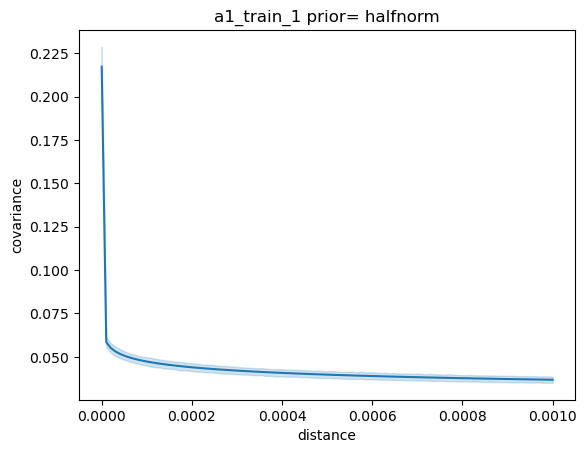

In [89]:
prior = 'halfnorm'
dist = torch.linspace(0,0.001,100)
state_dict_path = records_norm[15]['param']
state_dict = torch.load(state_dict_path)
model = GP_AFirst(inducing_points,nu=1, max_tries=200,prior=prior)
model.load_state_dict(state_dict)
kern = model.covar_module.base_kernel
lht_show_matern(kern, 'a1_train_1 prior= halfnorm', dist, prior=prior)

### Gamma Prior

In [18]:
#| hide
fp = opt.a1_train_1
df = pd.read_csv(fp)
nugget = 0.25
varogram_dist = 0.25
inducing_points = torch.load("model/ip500.pt")
folder = 'model/a1_train_1_gamma'
if not os.path.isdir(folder):
    os.mkdir(folder)
#
prior='gamma'
lr = 0.01
base_lr=0.0001
lr_step=100
device = torch.device("cpu")

model = lhtcore.GP_AFirst(inducing_points,nu=1, max_tries=200,prior=prior,nugget=nugget)
likelihood = gpytorch.likelihoods.GaussianLikelihood()  
model.to(device)
likelihood.to(device)
params = list(model.parameters()) + list(likelihood.parameters())
optimizer = torch.optim.Adam(params, lr = lr, weight_decay=0.01 )
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=lr_step, eta_min=base_lr)

points = df.to_numpy()
best_params = {'acc':0, 'mae':2, 'acc_mae':0}

In [19]:
#| hide
num_epochs = 3 # 1200
num_iter = tqdm.notebook.tqdm(range(0,num_epochs))
for epoch in num_iter:
    lhtutil.lht_train_one_epoch(model,optimizer,likelihood,points,device,lr_scheduler,batch_size=200)
    ret_test = lhtutil.lht_test(model,points,device,flag=True)
    acc, mae = ret_test['acc'], ret_test['mae']
    if acc > best_params['acc']:
        best_params['acc'] = acc
        param_fp = os.path.join(folder, f'best_acc.pth')
        torch.save(model.state_dict(), param_fp) 
    #
    if mae < best_params['mae']:
        best_params['mae'] = mae
        param_fp = os.path.join(folder, f'best_mae.pth')
        torch.save(model.state_dict(), param_fp)
    #
    acc_mae = acc / mae
    if acc_mae > best_params['acc_mae']:
        best_params['acc_mae'] = acc_mae
        param_fp = os.path.join(folder, f'best_acc_mae.pth')
        torch.save(model.state_dict(), param_fp)

  0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/450 [00:00<?, ?it/s]

test:   0%|          | 0/450 [00:00<?, ?it/s]

num:66594, acc:0.7399333333333333, mae:0.8263930678367615


Minibatch:   0%|          | 0/450 [00:00<?, ?it/s]

test:   0%|          | 0/450 [00:00<?, ?it/s]

num:57205, acc:0.6356111111111111, mae:0.8264849781990051


Minibatch:   0%|          | 0/450 [00:00<?, ?it/s]

test:   0%|          | 0/450 [00:00<?, ?it/s]

num:52963, acc:0.5884777777777778, mae:0.8264665603637695


In [21]:
folder = 'model/a1_train_1_gamma'
state_dict_path = os.path.join(folder,'best_acc.pth')
state_dict = torch.load(state_dict_path)
model = model = lhtcore.GP_AFirst(inducing_points,nu=1, max_tries=200,prior=prior,nugget=nugget)
model.load_state_dict(state_dict)
kern = model.covar_module.base_kernel
ret=lhtutil.lht_test(model,points,device,flag=True)

test:   0%|          | 0/450 [00:00<?, ?it/s]

num:66594, acc:0.7399333333333333, mae:0.8263930678367615


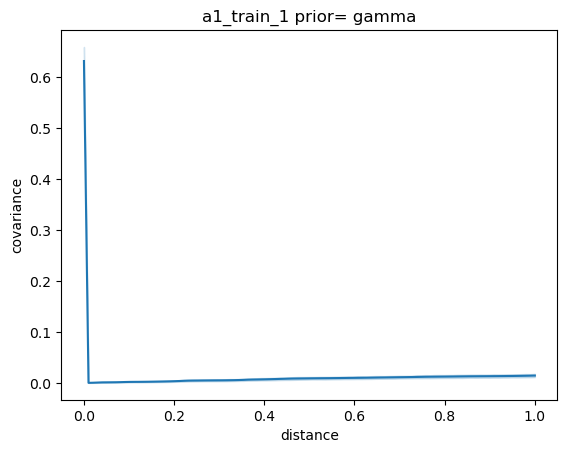

In [26]:
dist = torch.linspace(0,1,100)
lht_show_matern(kern, 'a1_train_1 prior= gamma', dist, prior=prior,)

#### Gamma Prior-old

In [69]:
#| hide
fp = opt.a1_train_1
df = pd.read_csv(fp)
varogram_dist = 0.25
inducing_points = torch.load("model/ip500.pt")
folder = 'model/a1_train_1_gamma'
if not os.path.isdir(folder):
    os.mkdir(folder)
records_gamma = train_LhtMatern(df=df, varogram_dist=varogram_dist, inducing_points=inducing_points, prior='gamma',lr=0.01, folder=folder)

100%|█████████████████████████████████████████████████████| 16/16 [00:00<00:00, 6647.73it/s]


         nu     sigma      beta    nugget
0  0.035388  0.037002  0.103654  0.152569
1  5.075649  4.672996  2.050025  4.946659


cross-validation:   0%|          | 0/16 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/346 [00:00<?, ?it/s]

test:   0%|          | 0/2 [00:00<?, ?it/s]

Test, MAE: 0.8420745134353638 ,  ACC: 0.9861751152073732, train:69015, test:217
          nu     sigma      beta    nugget
0   2.710927  0.000472  0.570973  0.000027
1  43.612520  1.843905  5.458842  0.955934


Minibatch:   0%|          | 0/377 [00:00<?, ?it/s]

test:   0%|          | 0/64 [00:00<?, ?it/s]

Test, MAE: 0.9776868224143982 ,  ACC: 0.4417797412432944, train:75334, test:12676
          nu     sigma      beta        nugget
0   2.817791  0.000460  0.582967  3.891884e-12
1  44.808405  1.837782  5.542770  4.596133e-01


Minibatch:   0%|          | 0/243 [00:00<?, ?it/s]

test:   0%|          | 0/5 [00:00<?, ?it/s]

Test, MAE: 0.682684063911438 ,  ACC: 0.9383408071748879, train:48584, test:892
          nu     sigma      beta        nugget
0   2.859649  0.000456  0.587649  4.975269e-18
1  45.274768  1.835487  5.575527  3.263511e-01


Minibatch:   0%|          | 0/378 [00:00<?, ?it/s]

test:   0%|          | 0/64 [00:00<?, ?it/s]

Test, MAE: 0.7888463139533997 ,  ACC: 0.9840577411167513, train:75588, test:12608
          nu     sigma      beta        nugget
0   2.906866  0.000451  0.592917  2.438503e-29
1  45.799461  1.832965  5.612384  2.063722e-01


Minibatch:   0%|          | 0/403 [00:00<?, ?it/s]

test:   0%|          | 0/41 [00:00<?, ?it/s]

Test, MAE: 0.5672178864479065 ,  ACC: 0.7977014335145823, train:80585, test:8092
          nu     sigma      beta        nugget
0   2.945053  0.000448  0.597168  1.383242e-44
1  46.222797  1.830976  5.642123  1.306168e-01


Minibatch:   0%|          | 0/203 [00:00<?, ?it/s]

test:   0%|          | 0/5 [00:00<?, ?it/s]

Test, MAE: 0.7840432524681091 ,  ACC: 0.4869466515323496, train:40503, test:881
          nu     sigma      beta        nugget
0   2.961655  0.000446  0.599013  9.889101e-54
1  46.406558  1.830123  5.655035  1.035001e-01


Minibatch:   0%|          | 0/356 [00:00<?, ?it/s]

test:   0%|          | 0/77 [00:00<?, ?it/s]

Test, MAE: 1.0054956674575806 ,  ACC: 0.38438320209973753, train:71179, test:15240
          nu     sigma      beta        nugget
0   2.988043  0.000443  0.601948  5.322133e-72
1  46.698275  1.828782  5.675567  6.838101e-02


Minibatch:   0%|          | 0/244 [00:00<?, ?it/s]

test:   0%|          | 0/5 [00:00<?, ?it/s]

Test, MAE: 0.580260157585144 ,  ACC: 1.0, train:48660, test:912
          nu     sigma      beta        nugget
0   3.004673  0.000442  0.603798  2.027562e-86
1  46.881892  1.827947  5.688509  5.078670e-02


Minibatch:   0%|          | 0/328 [00:00<?, ?it/s]

test:   0%|          | 0/2 [00:00<?, ?it/s]

Test, MAE: 0.9711899161338806 ,  ACC: 0.0, train:65478, test:225
          nu     sigma      beta         nugget
0   3.025371  0.000440  0.606099  7.088524e-109
1  47.110235  1.826921  5.704608   3.297023e-02


Minibatch:   0%|          | 0/376 [00:00<?, ?it/s]

test:   0%|          | 0/64 [00:00<?, ?it/s]

Test, MAE: 0.7680562734603882 ,  ACC: 0.48239213197969544, train:75168, test:12608
          nu     sigma      beta         nugget
0   3.046981  0.000438  0.608497  2.747240e-139
1  47.348342  1.825860  5.721381   1.904917e-02


Minibatch:   0%|          | 0/203 [00:00<?, ?it/s]

test:   0%|          | 0/5 [00:00<?, ?it/s]

Test, MAE: 0.7087499499320984 ,  ACC: 0.9196428571428571, train:40545, test:896
          nu     sigma      beta         nugget
0   3.057730  0.000437  0.609688  6.614098e-158
1  47.466675  1.825338  5.729709   1.378915e-02


Minibatch:   0%|          | 0/377 [00:00<?, ?it/s]

test:   0%|          | 0/63 [00:00<?, ?it/s]

Test, MAE: 0.6651762127876282 ,  ACC: 0.3228139904610493, train:75389, test:12580
          nu     sigma      beta         nugget
0   3.076390  0.000436  0.611746  8.927826e-198
1  47.671942  1.824441  5.744114   7.036037e-03


Minibatch:   0%|          | 0/430 [00:00<?, ?it/s]

test:   0%|          | 0/18 [00:00<?, ?it/s]

Test, MAE: 1.4969035387039185 ,  ACC: 0.7953850430914651, train:85956, test:3597
          nu     sigma      beta         nugget
0   3.096102  0.000434  0.613913  5.945326e-253
1  47.888553  1.823501  5.759278   2.840297e-03


Minibatch:   0%|          | 0/328 [00:00<?, ?it/s]

test:   0%|          | 0/2 [00:00<?, ?it/s]

Test, MAE: 0.60152667760849 ,  ACC: 0.9954954954954955, train:65442, test:222
          nu     sigma      beta         nugget
0   3.110292  0.000433  0.615468  5.239554e-303
1  48.044248  1.822845  5.770154   1.262299e-03


Minibatch:   0%|          | 0/403 [00:00<?, ?it/s]

test:   0%|          | 0/41 [00:00<?, ?it/s]

Test, MAE: 0.6943542957305908 ,  ACC: 0.7963350141434018, train:80528, test:8131
          nu     sigma      beta    nugget
0   3.126934  0.000431  0.617290  0.000000
1  48.226920  1.822066  5.782895  0.000391


Minibatch:   0%|          | 0/346 [00:00<?, ?it/s]

test:   0%|          | 0/2 [00:00<?, ?it/s]

Test, MAE: 0.55381840467453 ,  ACC: 0.9955156950672646, train:69066, test:223
          nu     sigma      beta    nugget
0   3.140696  0.000430  0.618789  0.000000
1  48.377755  1.821435  5.793388  0.000119


In [5]:
#| hide
fp = opt.a1_train_1
df = pd.read_csv(fp)
varogram_dist = 0.4
inducing_points = torch.load("model/ip500.pt")
folder = 'model/a1_train_1_gamma'
if not os.path.isdir(folder):
    os.mkdir(folder)
records_gamma = train_LhtMatern(df=df, varogram_dist=varogram_dist, inducing_points=inducing_points, prior='gamma',lr=0.0001, folder=folder)

100%|███████████████████████████████████████████████████████| 9/9 [00:00<00:00, 3835.08it/s]


         nu     sigma      beta    nugget
0  0.131668  0.006885  0.032167  0.039581
1  3.657811  1.394473  4.442208  0.762322


cross-validation:   0%|          | 0/9 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/235 [00:00<?, ?it/s]

test:   0%|          | 0/65 [00:00<?, ?it/s]

Test, MAE: 1.5353844165802002 ,  ACC: 0.5718815250174001, train:46967, test:12931
         nu     sigma      beta    nugget
0  0.137383  0.006369  0.034712  0.038553
1  3.729922  1.370670  4.552034  0.755476


Minibatch:   0%|          | 0/162 [00:00<?, ?it/s]

test:   0%|          | 0/91 [00:00<?, ?it/s]

Test, MAE: 1.3902921676635742 ,  ACC: 0.02113144758735441, train:32219, test:18030
         nu     sigma      beta    nugget
0  0.141594  0.006034  0.036566  0.037856
1  3.782577  1.354606  4.629802  0.750800


Minibatch:   0%|          | 0/256 [00:00<?, ?it/s]

test:   0%|          | 0/53 [00:00<?, ?it/s]

Test, MAE: 0.5779706835746765 ,  ACC: 0.9993319973279893, train:51055, test:10479
         nu     sigma      beta    nugget
0  0.148858  0.005531  0.039694  0.036786
1  3.872495  1.329597  4.757183  0.743560


Minibatch:   0%|          | 0/229 [00:00<?, ?it/s]

test:   0%|          | 0/61 [00:00<?, ?it/s]

Test, MAE: 0.5622522830963135 ,  ACC: 0.9980947647448641, train:45667, test:12072
         nu     sigma      beta    nugget
0  0.155607  0.005115  0.042661  0.035835
1  3.955061  1.307963  4.873977  0.737068


Minibatch:   0%|          | 0/133 [00:00<?, ?it/s]

test:   0%|          | 0/82 [00:00<?, ?it/s]

Test, MAE: 0.9373804330825806 ,  ACC: 0.3488158619423536, train:26535, test:16341
         nu     sigma      beta    nugget
0  0.159832  0.004884  0.044484  0.035297
1  4.006278  1.295540  4.943975  0.733373


Minibatch:   0%|          | 0/264 [00:00<?, ?it/s]

test:   0%|          | 0/53 [00:00<?, ?it/s]

Test, MAE: 0.6506361365318298 ,  ACC: 0.983997700268302, train:52608, test:10436
         nu     sigma      beta    nugget
0  0.168561  0.004454  0.048295  0.034244
1  4.111022  1.271415  5.086432  0.726072


Minibatch:   0%|          | 0/342 [00:00<?, ?it/s]

test:   0%|          | 0/15 [00:00<?, ?it/s]

Test, MAE: 0.5848075151443481 ,  ACC: 0.9829374372699899, train:68353, test:2989
         nu     sigma      beta    nugget
0  0.180461  0.003947  0.053611  0.032902
1  4.251622  1.241279  5.277268  0.716653


Minibatch:   0%|          | 0/320 [00:00<?, ?it/s]

test:   0%|          | 0/33 [00:00<?, ?it/s]

Test, MAE: 1.423215627670288 ,  ACC: 0.18129365320376556, train:63948, test:6586
         nu     sigma      beta    nugget
0  0.192387  0.003519  0.059023  0.031681
1  4.390184  1.213992  5.463410  0.707957


Minibatch:   0%|          | 0/365 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Test, MAE: 1.5584652423858643 ,  ACC: 0.625, train:72842, test:136
         nu     sigma      beta    nugget
0  0.206847  0.003081  0.065735  0.030325
1  4.555304  1.183938  5.684482  0.698160


In [71]:
ret = test_records(df, inducing_points, records_gamma, model_type='lht', prior='gamma', cuda=False, mae_threshold=3)

verify:   0%|          | 0/16 [00:00<?, ?it/s]

0: mae: 0.8420745134353638, acc: 0.9861751152073732
num:88271, acc:0.9807888888888889, mae:0.7067729830741882
1: mae: 0.9776868224143982, acc: 0.4417797412432944
num:55344, acc:0.6149333333333333, mae:0.6943334937095642
2: mae: 0.682684063911438, acc: 0.9383408071748879
num:55010, acc:0.6112222222222222, mae:0.7254381775856018
3: mae: 0.7888463139533997, acc: 0.9840577411167513
num:71921, acc:0.7991222222222222, mae:0.7255110740661621
4: mae: 0.5672178864479065, acc: 0.7977014335145823
num:54408, acc:0.6045333333333334, mae:0.6789140701293945
5: mae: 0.7840432524681091, acc: 0.4869466515323496
num:26137, acc:0.2904111111111111, mae:0.705335259437561
6: mae: 1.0054956674575806, acc: 0.38438320209973753
num:32750, acc:0.3638888888888889, mae:0.7122933268547058
7: mae: 0.580260157585144, acc: 1.0
num:63061, acc:0.7006777777777777, mae:0.7269042730331421
8: mae: 0.9711899161338806, acc: 0.0
num:34235, acc:0.3803888888888889, mae:0.6817836165428162
9: mae: 0.7680562734603882, acc: 0.4823921

In [23]:
folder = 'model/a1_train_1_gamma'
records = []
for i in os.listdir(folder):
    p = os.path.join(folder,i)
    m = {'mae':0,'acc':0,'param':p}
    records.append(m)
#
fp = opt.a1_train_1
df = pd.read_csv(fp)
inducing_points = torch.load("model/ip500.pt")
ret = test_records(df, inducing_points, records, model_type='lht', prior='gamma', cuda=False, mae_threshold=3)

verify:   0%|          | 0/9 [00:00<?, ?it/s]

0: mae: 0, acc: 0
num:52819, acc:0.5868777777777778, mae:0.8293243050575256
1: mae: 0, acc: 0
num:64453, acc:0.7161444444444445, mae:1.0569180250167847
2: mae: 0, acc: 0
num:54003, acc:0.6000333333333333, mae:0.8416526913642883
3: mae: 0, acc: 0
num:65096, acc:0.7232888888888889, mae:0.8600689172744751
4: mae: 0, acc: 0
num:11245, acc:0.12494444444444444, mae:1.0032336711883545
5: mae: 0, acc: 0
num:35192, acc:0.3910222222222222, mae:0.8404003381729126
6: mae: 0, acc: 0
num:74849, acc:0.8316555555555556, mae:0.841969907283783
7: mae: 0, acc: 0
num:76412, acc:0.8490222222222222, mae:0.9051973819732666
8: mae: 0, acc: 0
num:34818, acc:0.3868666666666667, mae:0.8242034912109375


In [72]:
mae = ret['mae']
acc = ret['acc']
mae = np.array(mae)
acc = np.array(acc)
am = acc/mae
idx = am.argmax()
print(f"ids:{idx}, mae:{mae[idx]}, acc:{acc[idx]}")

ids:15, mae:0.6309915781021118, acc:0.9205444444444445


In [73]:
fp = opt.a1_train_1
df = pd.read_csv(fp)
points = df.to_numpy()
X = points[:,0:2]
Y = points[:,2]
tx = torch.from_numpy(X).float()
yy = torch.from_numpy(Y).float()
inducing_points = torch.load("model/ip500.pt")

state_dict_path = records_gamma[15]['param']
state_dict = torch.load(state_dict_path)

model = GP_AFirst(inducing_points.cpu(),nu=1, max_tries=200, prior='gamma')
model.load_state_dict(state_dict)
model.eval()
preds = model(tx)
means = preds.mean.cpu()
error = torch.mean(torch.abs(means - yy.cpu()))
l,v = preds.loc.cpu().detach().numpy(), preds.stddev.cpu().detach().numpy()
ci = norm.interval(0.95, loc=l, scale=v)
LB,UB = ci
a = np.logical_and(Y>=LB, Y<=UB)
acc = Y[a].shape[0] / len(Y)
df['LB'] = LB
df['UB'] = UB
print(f"num:{Y[a].shape[0]}, acc:{acc}, mae:{error.item()}")
df.head()

num:82849, acc:0.9205444444444445, mae:0.6309915781021118


s1        s2         z        LB        UB
0  0.286453  0.085347 -1.644221 -2.495238 -0.605199
1  0.958983  0.049876 -3.157488 -3.101412  2.902908
2  0.650209  0.290569 -0.445955 -1.565848  0.541628
3  0.976836  0.525580 -0.547799 -1.870506  2.552511
4  0.829820  0.637500  0.186430 -1.726312  1.618863

In [74]:
idx=15
fp=f"model/a1_train_1_scv"
fp_ = f"{fp}_mae_acc.pth"
state_dict_path = records_gamma[idx]['param']
state_dict = torch.load(state_dict_path)
torch.save(state_dict, fp_)

# a1_train_2

In [20]:
#| hide
fp = opt.a1_train_2
df = pd.read_csv(fp)
points = df.to_numpy()
X = points[:,0:2]
Y = points[:,2].reshape(-1,1)

GMM = skl_mix.GaussianMixture
gmm = GMM(n_components=3,random_state=42,covariance_type='full').fit(Y)
labels = gmm.predict(Y) 

df['labels'] = labels

Text(0.5, 1.0, 'a1_train_2')

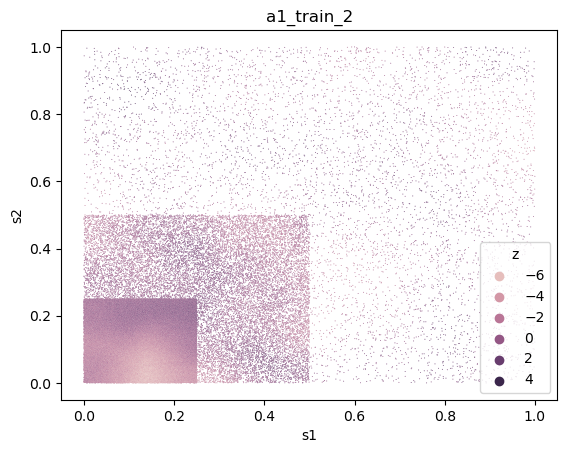

In [16]:
ax = sns.scatterplot(data=df, x='s1', y='s2', hue='z', s=0.5)
ax.set_title("a1_train_2")

<AxesSubplot:xlabel='z', ylabel='Density'>

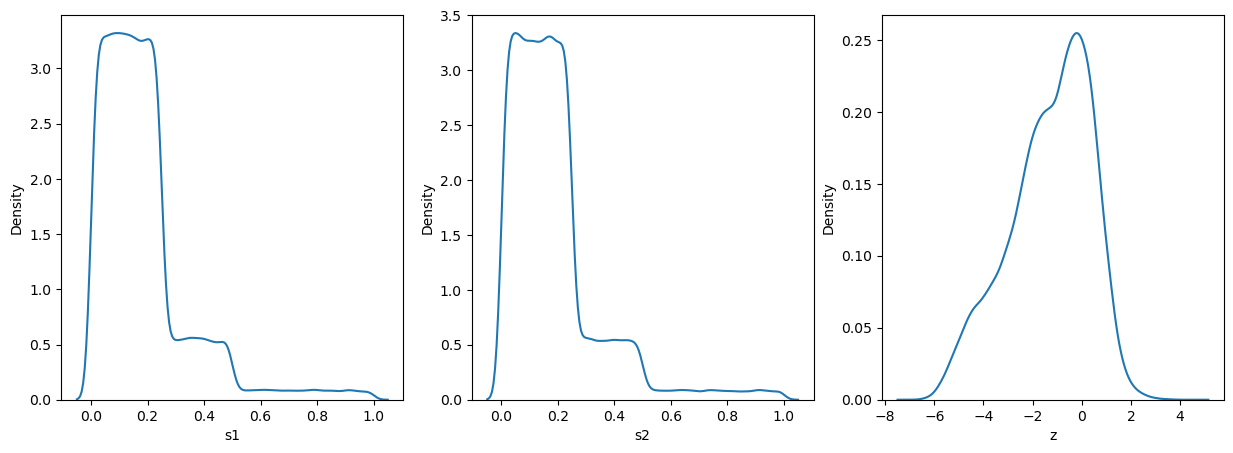

In [25]:
fig,axes = plt.subplots(1,3, figsize=(15,5))
sns.kdeplot(data=df, x='s1', ax=axes[0])
sns.kdeplot(data=df, x='s2', ax=axes[1])
sns.kdeplot(data=df, x='z', ax=axes[2])

## Spatial Cross Validation

### HalfNorm Prior

In [211]:
#| hide
fp = opt.a1_train_2
df = pd.read_csv(fp)
points = df.to_numpy()
nugget = 0.25
varogram_dist = 0.25
inducing_points = torch.load("model/ip500.pt")
folder = 'model/a1_train_2_norm'
if not os.path.isdir(folder):
    os.mkdir(folder)
#
prior='halfnorm'
lr = 0.001
base_lr=0.0001
lr_step=100
device = torch.device("cpu")
best_params = {'acc':0, 'mae':2, 'acc_mae':0}

In [43]:
model = lhtcore.GP_AFirst(inducing_points,nu=1, max_tries=200,prior=prior,nugget=nugget)
likelihood = gpytorch.likelihoods.GaussianLikelihood()  
model.to(device)
likelihood.to(device)
params = list(model.parameters()) + list(likelihood.parameters())
optimizer = torch.optim.Adam(params, lr = lr, weight_decay=0.01 )
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=lr_step, eta_min=base_lr)



In [212]:
#| hide
num_epochs = 5 # 1200
num_iter = tqdm.notebook.tqdm(range(0,num_epochs))
for epoch in num_iter:
    model = lhtcore.GP_AFirst(inducing_points,nu=1, max_tries=200,prior=prior,nugget=nugget)
    likelihood = gpytorch.likelihoods.GaussianLikelihood()  
    mll = gpytorch.mlls.PredictiveLogLikelihood(likelihood, model, num_data=len(points))
    model.to(device)
    likelihood.to(device)
    params = list(model.parameters()) + list(likelihood.parameters())
    optimizer = torch.optim.Adam(params, lr = lr, weight_decay=0.01 )
    lhtutil.lht_train_one_epoch(model,optimizer,likelihood,mll,points,device,lr_scheduler=None,batch_size=200)
    
    ret_test = lhtutil.lht_test(model,points,device,flag=True)
    acc, mae = ret_test['acc'], ret_test['mae']
    if acc > best_params['acc']:
        best_params['acc'] = acc
        param_fp = os.path.join(folder, f'best_acc.pth')
        torch.save(model.state_dict(), param_fp) 
    #
    if mae < best_params['mae']:
        best_params['mae'] = mae
        param_fp = os.path.join(folder, f'best_mae.pth')
        torch.save(model.state_dict(), param_fp)
    #
    acc_mae = acc / mae
    if acc_mae > best_params['acc_mae']:
        best_params['acc_mae'] = acc_mae
        param_fp = os.path.join(folder, f'best_acc_mae.pth')
        torch.save(model.state_dict(), param_fp)
        

  0%|          | 0/5 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/450 [00:00<?, ?it/s]

test:   0%|          | 0/450 [00:00<?, ?it/s]

num:80454, acc:0.8939333333333334, mae:1.3365039825439453


Minibatch:   0%|          | 0/450 [00:00<?, ?it/s]

test:   0%|          | 0/450 [00:00<?, ?it/s]

num:81845, acc:0.9093888888888889, mae:1.3269588947296143


Minibatch:   0%|          | 0/450 [00:00<?, ?it/s]

test:   0%|          | 0/450 [00:00<?, ?it/s]

num:88593, acc:0.9843666666666666, mae:0.888663113117218


Minibatch:   0%|          | 0/450 [00:00<?, ?it/s]

test:   0%|          | 0/450 [00:00<?, ?it/s]

num:78722, acc:0.8746888888888888, mae:1.3468279838562012


Minibatch:   0%|          | 0/450 [00:00<?, ?it/s]

test:   0%|          | 0/450 [00:00<?, ?it/s]

num:84115, acc:0.9346111111111111, mae:1.2099663019180298


In [44]:
#| hide
num_epochs = 2 # 1200
num_iter = tqdm.notebook.tqdm(range(0,num_epochs))
for epoch in num_iter:
    lhtutil.lht_train_one_epoch(model,optimizer,likelihood,points,device,lr_scheduler,batch_size=200)
    ret_test = lhtutil.lht_test(model,points,device,flag=True)
    acc, mae = ret_test['acc'], ret_test['mae']
    if acc > best_params['acc']:
        best_params['acc'] = acc
        param_fp = os.path.join(folder, f'best_acc.pth')
        torch.save(model.state_dict(), param_fp) 
    #
    if mae < best_params['mae']:
        best_params['mae'] = mae
        param_fp = os.path.join(folder, f'best_mae.pth')
        torch.save(model.state_dict(), param_fp)
    #
    acc_mae = acc / mae
    if acc_mae > best_params['acc_mae']:
        best_params['acc_mae'] = acc_mae
        param_fp = os.path.join(folder, f'best_acc_mae.pth')
        torch.save(model.state_dict(), param_fp)
        

  0%|          | 0/2 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/450 [00:00<?, ?it/s]

test:   0%|          | 0/450 [00:00<?, ?it/s]

num:86493, acc:0.9610333333333333, mae:0.9812918305397034


Minibatch:   0%|          | 0/450 [00:00<?, ?it/s]

test:   0%|          | 0/450 [00:00<?, ?it/s]

num:85561, acc:0.9506777777777777, mae:1.0532478094100952


In [213]:
folder = 'model/a1_train_2_norm'
state_dict_path = os.path.join(folder,'best_mae02.pth')
state_dict = torch.load(state_dict_path)
model = model = lhtcore.GP_AFirst(inducing_points,nu=1, max_tries=200,prior=prior,nugget=nugget)
model.load_state_dict(state_dict)
kern = model.covar_module.base_kernel
ret=lhtutil.lht_test(model,points,device,flag=True)

test:   0%|          | 0/450 [00:00<?, ?it/s]

num:88593, acc:0.9843666666666666, mae:0.888663113117218


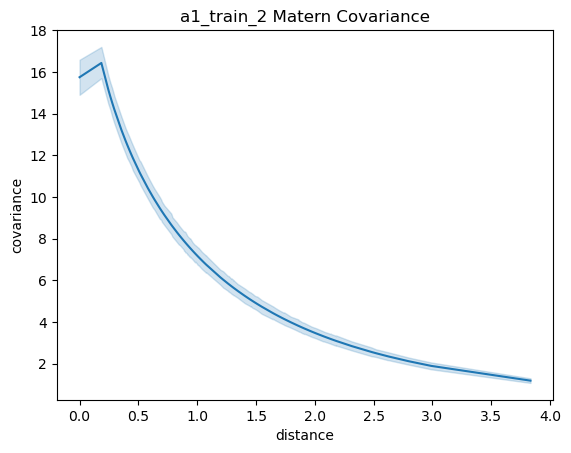

In [216]:
a = torch.randn(100,2)
a = a - a[0]
dist = torch.linalg.norm(a,dim=1)
lht_show_matern(kern, 'a1_train_2 Matern Covariance', dist, prior=prior)

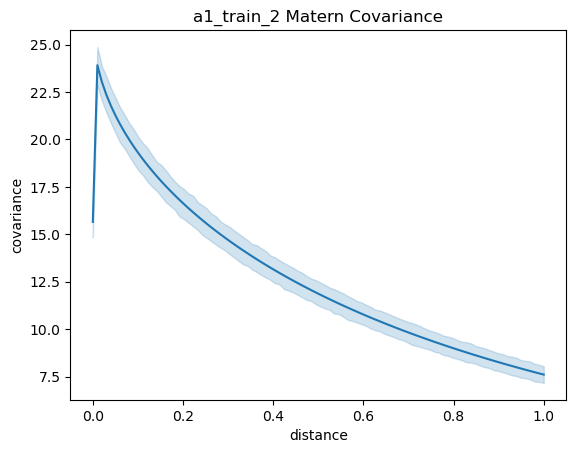

In [214]:
dist = torch.linspace(0,1,100)
lht_show_matern(kern, 'a1_train_2 Matern Covariance', dist, prior=prior)

In [217]:
lhtutil.showCI_NSBN(model)

nu      sigma      beta    nugget
0  0.022324   0.165121  0.036250  0.272617
1  1.596702  11.810045  2.592694  1.867653

### HalfNorm Prior- varigrom

In [118]:
#| hide
fp = opt.a1_train_2
df = pd.read_csv(fp)
nugget = 0.25
varogram_dist = 0.25
inducing_points = torch.load("model/ip500.pt")
folder = 'model/a1_train_2_norm/new'
if not os.path.isdir(folder):
    os.mkdir(folder)
#
prior='halfnorm'
lr = 0.01
base_lr=0.0001
lr_step=100
device = torch.device("cpu")
records = lhtutil.train_LhtMatern_step(df=df, varogram_dist=varogram_dist, inducing_points=inducing_points,base_lr=base_lr,
                               prior=prior, lr=lr, folder=folder,nugget=nugget,device=device, show_ci=False)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 8721.10it/s]


cross-validation:   0%|          | 0/16 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/29 [00:00<?, ?it/s]

test:   0%|          | 0/338 [00:00<?, ?it/s]

----Test:67522-----


test:   0%|          | 0/338 [00:00<?, ?it/s]

num:38931, acc:0.5765676372145375, mae:1.928755283355713
----All:90000-----


test:   0%|          | 0/450 [00:00<?, ?it/s]

num:59078, acc:0.6564222222222222, mae:1.6858927011489868
------------------------------


Minibatch:   0%|          | 0/24 [00:00<?, ?it/s]

test:   0%|          | 0/28 [00:00<?, ?it/s]

----Test:5569-----


test:   0%|          | 0/28 [00:00<?, ?it/s]

num:5288, acc:0.9495421080984019, mae:0.7876337766647339
----All:90000-----


test:   0%|          | 0/450 [00:00<?, ?it/s]

num:58637, acc:0.6515222222222222, mae:1.7307578325271606
------------------------------


Minibatch:   0%|          | 0/385 [00:00<?, ?it/s]

test:   0%|          | 0/3 [00:00<?, ?it/s]

----Test:481-----


test:   0%|          | 0/3 [00:00<?, ?it/s]

num:461, acc:0.9584199584199584, mae:1.0091673135757446
----All:90000-----


test:   0%|          | 0/450 [00:00<?, ?it/s]

num:81533, acc:0.9059222222222222, mae:1.2855979204177856
------------------------------


Minibatch:   0%|          | 0/441 [00:00<?, ?it/s]

test:   0%|          | 0/3 [00:00<?, ?it/s]

----Test:448-----


test:   0%|          | 0/3 [00:00<?, ?it/s]

num:20, acc:0.044642857142857144, mae:1.3128958940505981
----All:90000-----


test:   0%|          | 0/450 [00:00<?, ?it/s]

num:82318, acc:0.9146444444444445, mae:1.2018855810165405
------------------------------


Minibatch:   0%|          | 0/24 [00:00<?, ?it/s]

test:   0%|          | 0/29 [00:00<?, ?it/s]

----Test:5633-----


test:   0%|          | 0/29 [00:00<?, ?it/s]

num:5521, acc:0.9801171666962543, mae:1.0740717649459839
----All:90000-----


test:   0%|          | 0/450 [00:00<?, ?it/s]

num:80413, acc:0.8934777777777778, mae:1.1995445489883423
------------------------------


Minibatch:   0%|          | 0/17 [00:00<?, ?it/s]

test:   0%|          | 0/29 [00:00<?, ?it/s]

----Test:5674-----


test:   0%|          | 0/29 [00:00<?, ?it/s]

num:5558, acc:0.9795558688755728, mae:0.9846181273460388
----All:90000-----


test:   0%|          | 0/450 [00:00<?, ?it/s]

num:81241, acc:0.9026777777777778, mae:1.2093898057937622
------------------------------


Minibatch:   0%|          | 0/378 [00:00<?, ?it/s]

test:   0%|          | 0/3 [00:00<?, ?it/s]

----Test:456-----


test:   0%|          | 0/3 [00:00<?, ?it/s]

num:456, acc:1.0, mae:9.966815948486328
----All:90000-----


test:   0%|          | 0/450 [00:00<?, ?it/s]

num:90000, acc:1.0, mae:7.870751857757568
------------------------------


Minibatch:   0%|          | 0/437 [00:00<?, ?it/s]

test:   0%|          | 0/3 [00:00<?, ?it/s]

----Test:464-----


test:   0%|          | 0/3 [00:00<?, ?it/s]

num:464, acc:1.0, mae:12.191330909729004
----All:90000-----


test:   0%|          | 0/450 [00:00<?, ?it/s]

num:90000, acc:1.0, mae:7.8496012687683105
------------------------------


Minibatch:   0%|          | 0/385 [00:00<?, ?it/s]

test:   0%|          | 0/3 [00:00<?, ?it/s]

----Test:448-----


test:   0%|          | 0/3 [00:00<?, ?it/s]

num:448, acc:1.0, mae:6.21008825302124
----All:90000-----


test:   0%|          | 0/450 [00:00<?, ?it/s]

num:90000, acc:1.0, mae:7.8168158531188965
------------------------------


Minibatch:   0%|          | 0/377 [00:00<?, ?it/s]

test:   0%|          | 0/3 [00:00<?, ?it/s]

----Test:525-----


test:   0%|          | 0/3 [00:00<?, ?it/s]

num:525, acc:1.0, mae:9.326278686523438
----All:90000-----


test:   0%|          | 0/450 [00:00<?, ?it/s]

num:90000, acc:1.0, mae:7.777149200439453
------------------------------


Minibatch:   0%|          | 0/403 [00:00<?, ?it/s]

test:   0%|          | 0/3 [00:00<?, ?it/s]

----Test:476-----


test:   0%|          | 0/3 [00:00<?, ?it/s]

num:476, acc:1.0, mae:9.194806098937988
----All:90000-----


test:   0%|          | 0/450 [00:00<?, ?it/s]

num:89999, acc:0.9999888888888889, mae:7.728426933288574
------------------------------


Minibatch:   0%|          | 0/437 [00:00<?, ?it/s]

test:   0%|          | 0/3 [00:00<?, ?it/s]

----Test:455-----


test:   0%|          | 0/3 [00:00<?, ?it/s]

num:455, acc:1.0, mae:12.112890243530273
----All:90000-----


test:   0%|          | 0/450 [00:00<?, ?it/s]

num:90000, acc:1.0, mae:7.6667022705078125
------------------------------


Minibatch:   0%|          | 0/441 [00:00<?, ?it/s]

test:   0%|          | 0/3 [00:00<?, ?it/s]

----Test:454-----


test:   0%|          | 0/3 [00:00<?, ?it/s]

num:454, acc:1.0, mae:4.339326858520508
----All:90000-----


test:   0%|          | 0/450 [00:00<?, ?it/s]

num:90000, acc:1.0, mae:7.582508563995361
------------------------------


Minibatch:   0%|          | 0/436 [00:00<?, ?it/s]

test:   0%|          | 0/3 [00:00<?, ?it/s]

----Test:454-----


test:   0%|          | 0/3 [00:00<?, ?it/s]

num:454, acc:1.0, mae:7.252503871917725
----All:90000-----


test:   0%|          | 0/450 [00:00<?, ?it/s]

num:90000, acc:1.0, mae:7.47291898727417
------------------------------


Minibatch:   0%|          | 0/436 [00:00<?, ?it/s]

test:   0%|          | 0/3 [00:00<?, ?it/s]

----Test:487-----


test:   0%|          | 0/3 [00:00<?, ?it/s]

num:487, acc:1.0, mae:9.68239974975586
----All:90000-----


test:   0%|          | 0/450 [00:00<?, ?it/s]

num:90000, acc:1.0, mae:7.3400139808654785
------------------------------


Minibatch:   0%|          | 0/441 [00:00<?, ?it/s]

test:   0%|          | 0/3 [00:00<?, ?it/s]

----Test:454-----


test:   0%|          | 0/3 [00:00<?, ?it/s]

num:454, acc:1.0, mae:10.79658031463623
----All:90000-----


test:   0%|          | 0/450 [00:00<?, ?it/s]

num:90000, acc:1.0, mae:7.187926292419434
------------------------------


In [119]:
mae = [ret['mae'] for ret in records]
acc = [ret['acc'] for ret in records]
mae = np.array(mae)
acc = np.array(acc)
am = acc/mae
idx = am.argmax()
print(f"ids:{idx}, mae:{mae[idx]}, acc:{acc[idx]}")

ids:3, mae:1.2018855810165405, acc:0.9146444444444445


In [123]:
ids = 3
state_dict_path = records[ids]['param']
state_dict = torch.load(state_dict_path)
model = model = lhtcore.GP_AFirst(inducing_points,nu=1, max_tries=200,prior=prior,nugget=nugget)
model.load_state_dict(state_dict)
kern = model.covar_module.base_kernel
points = df.to_numpy()
ret_test = lhtutil.lht_test(model,points,device,flag=True)

test:   0%|          | 0/450 [00:00<?, ?it/s]

num:82318, acc:0.9146444444444445, mae:1.201881766319275


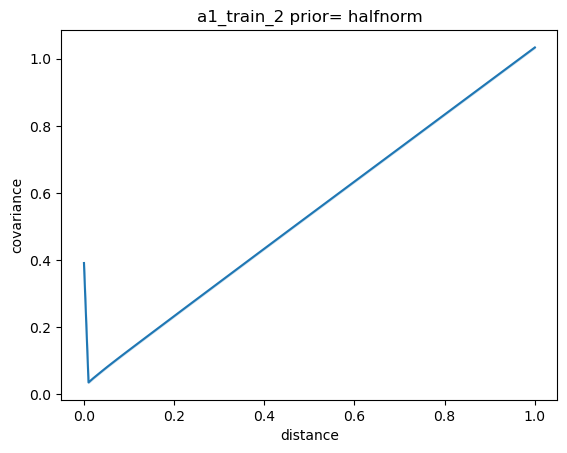

In [125]:
dist = torch.linspace(0,1,100)
lht_show_matern(kern, 'a1_train_2 prior= halfnorm', dist, prior=prior)

#### HalfNorm Prior - old

In [90]:
#| hide
fp = opt.a1_train_2
df = pd.read_csv(fp)
varogram_dist = 0.25
inducing_points = torch.load("model/ip500.pt")
folder = 'model/a1_train_2_norm'
if not os.path.isdir(folder):
    os.mkdir(folder)
records_norm_2 = train_LhtMatern(df=df, varogram_dist=varogram_dist, inducing_points=inducing_points, prior='halfnorm', lr=0.01,folder=folder)

100%|█████████████████████████████████████████████████████| 16/16 [00:00<00:00, 9032.15it/s]


         nu     sigma      beta    nugget
0  0.028007  0.043553  0.058862  0.107839
1  2.003139  3.115077  4.209993  7.713020


cross-validation:   0%|          | 0/16 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/57 [00:00<?, ?it/s]

test:   0%|          | 0/338 [00:00<?, ?it/s]

Test, MAE: 1.4275827407836914 ,  ACC: 0.9997186102307396, train:11276, test:67522
         nu     sigma      beta    nugget
0  0.017294  0.032095  0.071666  0.090792
1  1.236924  2.295526  5.125835  6.493744


Minibatch:   0%|          | 0/54 [00:00<?, ?it/s]

test:   0%|          | 0/28 [00:00<?, ?it/s]

Test, MAE: 0.7833399772644043 ,  ACC: 1.0, train:10754, test:5569
         nu     sigma      beta    nugget
0  0.010236  0.025698  0.076851  0.075386
1  0.732090  1.838014  5.496658  5.391859


Minibatch:   0%|          | 0/416 [00:00<?, ?it/s]

test:   0%|          | 0/3 [00:00<?, ?it/s]

Test, MAE: 0.9270453453063965 ,  ACC: 1.0, train:83046, test:481
         nu     sigma      beta    nugget
0  0.001808  0.014202  0.080766  0.011961
1  0.129320  1.015781  5.776690  0.855470


Minibatch:   0%|          | 0/444 [00:00<?, ?it/s]

test:   0%|          | 0/3 [00:00<?, ?it/s]

Test, MAE: 2.2927868366241455 ,  ACC: 1.0, train:88607, test:448
         nu     sigma      beta    nugget
0  0.000929  0.011309  0.081063  0.003380
1  0.066457  0.808828  5.797946  0.241767


Minibatch:   0%|          | 0/54 [00:00<?, ?it/s]

test:   0%|          | 0/29 [00:00<?, ?it/s]

Test, MAE: 0.9260453581809998 ,  ACC: 0.9900585833481271, train:10723, test:5633
         nu     sigma      beta    nugget
0  0.000877  0.011083  0.081080  0.003026
1  0.062731  0.792714  5.799162  0.216444


Minibatch:   0%|          | 0/361 [00:00<?, ?it/s]

test:   0%|          | 0/29 [00:00<?, ?it/s]

Test, MAE: 0.8389977216720581 ,  ACC: 0.9992950299612267, train:72143, test:5674
         nu     sigma      beta    nugget
0  0.000629  0.009854  0.081161  0.001656
1  0.044954  0.704791  5.804897  0.118465


Minibatch:   0%|          | 0/413 [00:00<?, ?it/s]

test:   0%|          | 0/3 [00:00<?, ?it/s]

Test, MAE: 1.4676891565322876 ,  ACC: 1.0, train:82449, test:456
         nu     sigma      beta    nugget
0  0.000468  0.008861  0.081212  0.000983
1  0.033457  0.633771  5.808543  0.070333


Minibatch:   0%|          | 0/441 [00:00<?, ?it/s]

test:   0%|          | 0/3 [00:00<?, ?it/s]

Test, MAE: 1.0639094114303589 ,  ACC: 1.0, train:88177, test:464
         nu     sigma      beta    nugget
0  0.000362  0.008065  0.081245  0.000628
1  0.025865  0.576837  5.810918  0.044904


Minibatch:   0%|          | 0/415 [00:00<?, ?it/s]

test:   0%|          | 0/3 [00:00<?, ?it/s]

Test, MAE: 1.0331835746765137 ,  ACC: 1.0, train:82940, test:448
         nu     sigma      beta    nugget
0  0.000294  0.007465  0.081266  0.000438
1  0.021001  0.533938  5.812427  0.031300


Minibatch:   0%|          | 0/413 [00:00<?, ?it/s]

test:   0%|          | 0/3 [00:00<?, ?it/s]

Test, MAE: 0.9619836807250977 ,  ACC: 0.979047619047619, train:82423, test:525
         nu     sigma      beta    nugget
0  0.000244  0.006963  0.081281  0.000318
1  0.017448  0.498036  5.813531  0.022724


Minibatch:   0%|          | 0/439 [00:00<?, ?it/s]

test:   0%|          | 0/3 [00:00<?, ?it/s]

Test, MAE: 1.7079572677612305 ,  ACC: 0.9684873949579832, train:87601, test:476
         nu     sigma      beta    nugget
0  0.000204  0.006504  0.081294  0.000233
1  0.014576  0.465162  5.814425  0.016650


Minibatch:   0%|          | 0/441 [00:00<?, ?it/s]

test:   0%|          | 0/3 [00:00<?, ?it/s]

Test, MAE: 0.859653890132904 ,  ACC: 1.0, train:88151, test:455
         nu     sigma      beta    nugget
0  0.000172  0.006098  0.081303  0.000174
1  0.012325  0.436170  5.815092  0.012452


Minibatch:   0%|          | 0/444 [00:00<?, ?it/s]

test:   0%|          | 0/3 [00:00<?, ?it/s]

Test, MAE: 1.9167625904083252 ,  ACC: 1.0, train:88644, test:454
         nu     sigma      beta    nugget
0  0.000147  0.005734  0.081311  0.000132
1  0.010512  0.410102  5.815649  0.009444


Minibatch:   0%|          | 0/441 [00:00<?, ?it/s]

test:   0%|          | 0/3 [00:00<?, ?it/s]

Test, MAE: 1.1208642721176147 ,  ACC: 0.9559471365638766, train:88080, test:454
         nu     sigma      beta    nugget
0  0.000126  0.005406  0.081317  0.000102
1  0.009041  0.386656  5.816085  0.007264


Minibatch:   0%|          | 0/441 [00:00<?, ?it/s]

test:   0%|          | 0/3 [00:00<?, ?it/s]

Test, MAE: 1.0908012390136719 ,  ACC: 0.917864476386037, train:88129, test:487
         nu     sigma      beta    nugget
0  0.000109  0.005106  0.081323  0.000079
1  0.007821  0.365188  5.816521  0.005639


Minibatch:   0%|          | 0/444 [00:00<?, ?it/s]

test:   0%|          | 0/3 [00:00<?, ?it/s]

Test, MAE: 1.192604422569275 ,  ACC: 1.0, train:88604, test:454
         nu     sigma      beta    nugget
0  0.000095  0.004827  0.081327  0.000062
1  0.006789  0.345249  5.816788  0.004401


In [91]:
ret = test_records(df, inducing_points, records_norm_2, model_type='lht', prior='halfnorm', cuda=False, mae_threshold=3)

verify:   0%|          | 0/16 [00:00<?, ?it/s]

0: mae: 1.4275827407836914, acc: 0.9997186102307396
num:89981, acc:0.9997888888888888, mae:1.306637167930603
1: mae: 0.7833399772644043, acc: 1.0
num:89999, acc:0.9999888888888889, mae:1.3834500312805176
2: mae: 0.9270453453063965, acc: 1.0
num:85187, acc:0.9465222222222223, mae:1.386605143547058
3: mae: 2.2927868366241455, acc: 1.0
num:84938, acc:0.9437555555555556, mae:1.3866039514541626
4: mae: 0.9260453581809998, acc: 0.9900585833481271
num:76496, acc:0.8499555555555556, mae:1.3866163492202759
5: mae: 0.8389977216720581, acc: 0.9992950299612267
num:84764, acc:0.9418222222222222, mae:1.3864601850509644
6: mae: 1.4676891565322876, acc: 1.0
num:83762, acc:0.9306888888888889, mae:1.3862841129302979
7: mae: 1.0639094114303589, acc: 1.0
num:81652, acc:0.9072444444444444, mae:1.3861485719680786
8: mae: 1.0331835746765137, acc: 1.0
num:83789, acc:0.9309888888888889, mae:1.3860198259353638
9: mae: 0.9619836807250977, acc: 0.979047619047619
num:85164, acc:0.9462666666666667, mae:1.3859021663

In [92]:
mae = ret['mae']
acc = ret['acc']
mae = np.array(mae)
acc = np.array(acc)
am = acc/mae
idx = am.argmax()
print(f"ids:{idx}, mae:{mae[idx]}, acc:{acc[idx]}")

ids:0, mae:1.306637167930603, acc:0.9997888888888888


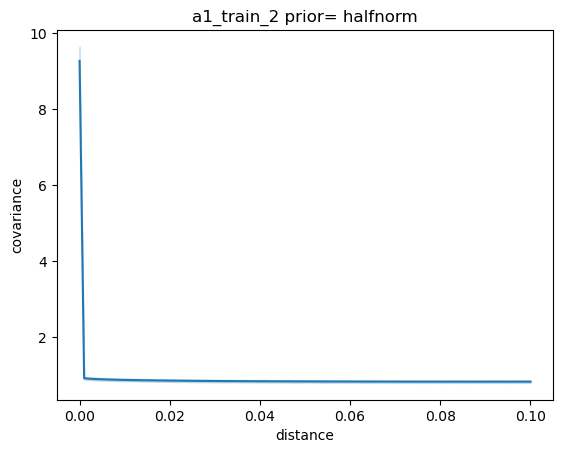

In [95]:
prior = 'halfnorm'
dist = torch.linspace(0,0.1,100)
state_dict_path = records_norm_2[0]['param']
state_dict = torch.load(state_dict_path)
model = GP_AFirst(inducing_points,nu=1, max_tries=200,prior=prior)
model.load_state_dict(state_dict)
kern = model.covar_module.base_kernel
lht_show_matern(kern, 'a1_train_2 prior= halfnorm', dist, prior=prior)

In [96]:
fp = opt.a1_train_2
df = pd.read_csv(fp)
points = df.to_numpy()
X = points[:,0:2]
Y = points[:,2]
tx = torch.from_numpy(X).float()
yy = torch.from_numpy(Y).float()
inducing_points = torch.load("model/ip500.pt")

state_dict_path = records_norm_2[0]['param']
state_dict = torch.load(state_dict_path)

model = GP_AFirst(inducing_points.cpu(),nu=1, max_tries=200, prior=prior)
model.load_state_dict(state_dict)
model.eval()
preds = model(tx)
means = preds.mean.cpu()
error = torch.mean(torch.abs(means - yy.cpu()))
l,v = preds.loc.cpu().detach().numpy(), preds.stddev.cpu().detach().numpy()
ci = norm.interval(0.95, loc=l, scale=v)
LB,UB = ci
a = np.logical_and(Y>=LB, Y<=UB)
acc = Y[a].shape[0] / len(Y)
df['LB'] = LB
df['UB'] = UB
print(f"num:{Y[a].shape[0]}, acc:{acc}, mae:{error.item()}")
df.head()

num:89981, acc:0.9997888888888888, mae:1.306637167930603


s1        s2         z         LB         UB
0  0.041801  0.013916 -1.644221  -6.587044   4.816356
1  0.203935  0.076529 -3.328776  -8.101844   6.281675
2  0.331229  0.054153 -0.441373  -6.860887   4.755145
3  0.186190  0.120166 -2.531590  -9.855434   8.221698
4  0.062082  0.194572 -0.341679 -13.612288  12.462145

### Gamma Prior

In [48]:
#| hide
fp = opt.a1_train_2
df = pd.read_csv(fp)
nugget = 0.25
varogram_dist = 0.25
inducing_points = torch.load("model/ip500.pt")
folder = 'model/a1_train_2_gamma'
if not os.path.isdir(folder):
    os.mkdir(folder)
#
prior='gamma'
lr = 0.01
base_lr=0.0001
lr_step=100
device = torch.device("cpu")

model = lhtcore.GP_AFirst(inducing_points,nu=1, max_tries=200,prior=prior,nugget=nugget)
likelihood = gpytorch.likelihoods.GaussianLikelihood()  
model.to(device)
likelihood.to(device)
params = list(model.parameters()) + list(likelihood.parameters())
optimizer = torch.optim.Adam(params, lr = lr, weight_decay=0.01 )
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=lr_step, eta_min=base_lr)

points = df.to_numpy()
best_params = {'acc':0, 'mae':2, 'acc_mae':0}

In [49]:
#| hide
num_epochs = 2 # 1200
num_iter = tqdm.notebook.tqdm(range(0,num_epochs))
for epoch in num_iter:
    lhtutil.lht_train_one_epoch(model,optimizer,likelihood,points,device,lr_scheduler,batch_size=200)
    ret_test = lhtutil.lht_test(model,points,device,flag=True)
    acc, mae = ret_test['acc'], ret_test['mae']
    if acc > best_params['acc']:
        best_params['acc'] = acc
        param_fp = os.path.join(folder, f'best_acc.pth')
        torch.save(model.state_dict(), param_fp) 
    #
    if mae < best_params['mae']:
        best_params['mae'] = mae
        param_fp = os.path.join(folder, f'best_mae.pth')
        torch.save(model.state_dict(), param_fp)
    #
    acc_mae = acc / mae
    if acc_mae > best_params['acc_mae']:
        best_params['acc_mae'] = acc_mae
        param_fp = os.path.join(folder, f'best_acc_mae.pth')
        torch.save(model.state_dict(), param_fp)
        

  0%|          | 0/2 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/450 [00:00<?, ?it/s]

test:   0%|          | 0/450 [00:00<?, ?it/s]

num:33848, acc:0.37608888888888886, mae:1.5011286735534668


Minibatch:   0%|          | 0/450 [00:00<?, ?it/s]

test:   0%|          | 0/450 [00:00<?, ?it/s]

num:32495, acc:0.3610555555555556, mae:1.4994709491729736


In [50]:
#folder = 'model/a1_train_2_norm'
state_dict_path = os.path.join(folder,'best_acc_mae.pth')
state_dict = torch.load(state_dict_path)
model = model = lhtcore.GP_AFirst(inducing_points,nu=1, max_tries=200,prior=prior,nugget=nugget)
model.load_state_dict(state_dict)
kern = model.covar_module.base_kernel

In [59]:
ret=lhtutil.lht_test(model,points,device,flag=True)

test:   0%|          | 0/450 [00:00<?, ?it/s]

num:81994, acc:0.9110444444444444, mae:1.2239649295806885


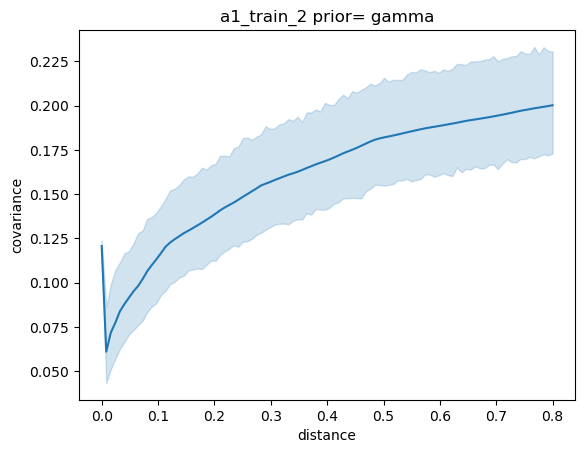

In [51]:
dist = torch.linspace(0,0.8,100)
lht_show_matern(kern, 'a1_train_2 prior= gamma', dist, prior=prior)

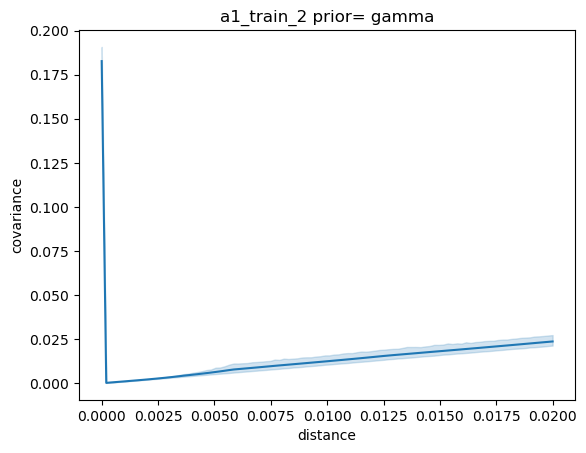

In [60]:
dist = torch.linspace(0,0.02,100)
lht_show_matern(kern, 'a1_train_2 prior= gamma', dist, prior=prior)

#### Gamma Prior-old

In [13]:
#| hide
fp = opt.a1_train_2
df = pd.read_csv(fp)
varogram_dist = 0.25
inducing_points = torch.load("model/ip500.pt")
folder = 'model/a1_train_2_gamma'
if not os.path.isdir(folder):
    os.mkdir(folder)
records_gamma_2 = train_LhtMatern(df=df, varogram_dist=varogram_dist, inducing_points=inducing_points, prior='gamma', lr=0.0001,folder=folder,num_epoch=2)

100%|█████████████████████████████████████████████████████| 16/16 [00:00<00:00, 9090.88it/s]


         nu     sigma      beta    nugget
0  0.100494  0.208841  0.013240  0.537782
1  2.611061  5.489023  1.572835  4.182970


cross-validation:   0%|          | 0/32 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/57 [00:00<?, ?it/s]

test:   0%|          | 0/338 [00:00<?, ?it/s]

Test, MAE: 1.7779006958007812 ,  ACC: 0.7832113977666538, train:11276, test:67522
         nu     sigma      beta    nugget
0  0.099551  0.206653  0.013454  0.535178
1  2.600450  5.460420  1.579380  4.169246


Minibatch:   0%|          | 0/54 [00:00<?, ?it/s]

test:   0%|          | 0/28 [00:00<?, ?it/s]

Test, MAE: 0.6967037916183472 ,  ACC: 0.9974860836775005, train:10754, test:5569
         nu     sigma      beta    nugget
0  0.098665  0.204605  0.013658  0.532733
1  2.590460  5.433580  1.585571  4.156352


Minibatch:   0%|          | 0/416 [00:00<?, ?it/s]

test:   0%|          | 0/3 [00:00<?, ?it/s]

Test, MAE: 0.6728793382644653 ,  ACC: 1.0, train:83046, test:481
         nu     sigma      beta    nugget
0  0.090567  0.189394  0.015285  0.514482
1  2.498033  5.232103  1.633522  4.059997


Minibatch:   0%|          | 0/444 [00:00<?, ?it/s]

test:   0%|          | 0/3 [00:00<?, ?it/s]

Test, MAE: 1.6673084497451782 ,  ACC: 0.9977678571428571, train:88607, test:448
         nu     sigma      beta    nugget
0  0.081765  0.174844  0.017045  0.495791
1  2.394857  5.035509  1.682838  3.961111


Minibatch:   0%|          | 0/54 [00:00<?, ?it/s]

test:   0%|          | 0/29 [00:00<?, ?it/s]

Test, MAE: 0.8687157034873962 ,  ACC: 0.9998224747026452, train:10723, test:5633
         nu     sigma      beta    nugget
0  0.080726  0.173231  0.017254  0.493548
1  2.382458  5.013449  1.688537  3.949230


Minibatch:   0%|          | 0/361 [00:00<?, ?it/s]

test:   0%|          | 0/29 [00:00<?, ?it/s]

Test, MAE: 1.0423648357391357 ,  ACC: 1.0, train:72143, test:5674
         nu     sigma      beta    nugget
0  0.074318  0.162492  0.018724  0.479042
1  2.304903  4.865183  1.727788  3.872265


Minibatch:   0%|          | 0/413 [00:00<?, ?it/s]

test:   0%|          | 0/3 [00:00<?, ?it/s]

Test, MAE: 1.1105865240097046 ,  ACC: 1.0, train:82449, test:456
         nu     sigma      beta    nugget
0  0.067719  0.151131  0.020448  0.463041
1  2.222788  4.705327  1.772144  3.787149


Minibatch:   0%|          | 0/441 [00:00<?, ?it/s]

test:   0%|          | 0/3 [00:00<?, ?it/s]

Test, MAE: 0.6819497346878052 ,  ACC: 1.0, train:88177, test:464
         nu     sigma      beta    nugget
0  0.061446  0.139953  0.022346  0.446594
1  2.142249  4.544643  1.819138  3.699368


Minibatch:   0%|          | 0/415 [00:00<?, ?it/s]

test:   0%|          | 0/3 [00:00<?, ?it/s]

Test, MAE: 0.9617842435836792 ,  ACC: 1.0, train:82940, test:448
         nu     sigma      beta    nugget
0  0.056160  0.130202  0.024198  0.431674
1  2.072171  4.401318  1.863372  3.619462


Minibatch:   0%|          | 0/413 [00:00<?, ?it/s]

test:   0%|          | 0/3 [00:00<?, ?it/s]

Test, MAE: 1.3112725019454956 ,  ACC: 0.9961904761904762, train:82423, test:525
         nu     sigma      beta    nugget
0  0.051419  0.121153  0.026113  0.417339
1  2.007311  4.265300  1.907633  3.542407


Minibatch:   0%|          | 0/439 [00:00<?, ?it/s]

test:   0%|          | 0/3 [00:00<?, ?it/s]

Test, MAE: 1.042711615562439 ,  ACC: 1.0, train:87601, test:476
         nu     sigma      beta    nugget
0  0.046867  0.112188  0.028234  0.402617
1  1.942936  4.127320  1.955086  3.462939


Minibatch:   0%|          | 0/441 [00:00<?, ?it/s]

test:   0%|          | 0/3 [00:00<?, ?it/s]

Test, MAE: 0.7799372673034668 ,  ACC: 1.0, train:88151, test:455
         nu     sigma      beta    nugget
0  0.042725  0.103789  0.030463  0.388332
1  1.882279  3.994726  2.003415  3.385480


Minibatch:   0%|          | 0/444 [00:00<?, ?it/s]

test:   0%|          | 0/3 [00:00<?, ?it/s]

Test, MAE: 1.3709676265716553 ,  ACC: 1.0, train:88644, test:454
         nu     sigma      beta    nugget
0  0.038934  0.095899  0.032816  0.374421
1  1.824726  3.866801  2.052883  3.309697


Minibatch:   0%|          | 0/441 [00:00<?, ?it/s]

test:   0%|          | 0/3 [00:00<?, ?it/s]

Test, MAE: 0.7593063116073608 ,  ACC: 1.0, train:88080, test:454
         nu     sigma      beta    nugget
0  0.035498  0.088574  0.035271  0.361061
1  1.770608  3.744731  2.102999  3.236572


Minibatch:   0%|          | 0/441 [00:00<?, ?it/s]

test:   0%|          | 0/3 [00:00<?, ?it/s]

Test, MAE: 1.151537537574768 ,  ACC: 0.9671457905544147, train:88129, test:487
         nu     sigma      beta    nugget
0  0.032354  0.081723  0.037851  0.348127
1  1.719171  3.627263  2.154214  3.165402


Minibatch:   0%|          | 0/444 [00:00<?, ?it/s]

test:   0%|          | 0/3 [00:00<?, ?it/s]

Test, MAE: 1.0678317546844482 ,  ACC: 1.0, train:88604, test:454
         nu     sigma      beta    nugget
0  0.029452  0.075278  0.040583  0.335521
1  1.669812  3.513428  2.206959  3.095667


Minibatch:   0%|          | 0/57 [00:00<?, ?it/s]

test:   0%|          | 0/338 [00:00<?, ?it/s]

Test, MAE: 1.8032723665237427 ,  ACC: 0.9317703859482835, train:11276, test:67522
         nu     sigma      beta    nugget
0  0.029107  0.074514  0.040930  0.333908
1  1.663810  3.499689  2.213548  3.086716


Minibatch:   0%|          | 0/54 [00:00<?, ?it/s]

test:   0%|          | 0/28 [00:00<?, ?it/s]

Test, MAE: 0.6867567300796509 ,  ACC: 0.9989226072903573, train:10754, test:5569
         nu     sigma      beta    nugget
0  0.028785  0.073795  0.041260  0.332384
1  1.658162  3.486721  2.219811  3.078250


Minibatch:   0%|          | 0/416 [00:00<?, ?it/s]

test:   0%|          | 0/3 [00:00<?, ?it/s]

Test, MAE: 0.6730189919471741 ,  ACC: 0.997920997920998, train:83046, test:481
         nu     sigma      beta    nugget
0  0.026332  0.068225  0.043985  0.321045
1  1.614337  3.384599  2.270763  3.015080


Minibatch:   0%|          | 0/444 [00:00<?, ?it/s]

test:   0%|          | 0/3 [00:00<?, ?it/s]

Test, MAE: 1.6727317571640015 ,  ACC: 0.9977678571428571, train:88607, test:448
         nu     sigma      beta    nugget
0  0.023920  0.062666  0.047042  0.309317
1  1.569427  3.279412  2.326494  2.949377


Minibatch:   0%|          | 0/54 [00:00<?, ?it/s]

test:   0%|          | 0/29 [00:00<?, ?it/s]

Test, MAE: 0.868934690952301 ,  ACC: 0.9998224747026452, train:10723, test:5633
         nu     sigma      beta    nugget
0  0.023646  0.062037  0.047412  0.307899
1  1.564190  3.267279  2.333149  2.941405


Minibatch:   0%|          | 0/361 [00:00<?, ?it/s]

test:   0%|          | 0/29 [00:00<?, ?it/s]

Test, MAE: 1.0401949882507324 ,  ACC: 0.9756785336623194, train:72143, test:5674
         nu     sigma      beta    nugget
0  0.021845  0.057822  0.050033  0.298673
1  1.529136  3.184731  2.379744  2.889421


Minibatch:   0%|          | 0/413 [00:00<?, ?it/s]

test:   0%|          | 0/3 [00:00<?, ?it/s]

Test, MAE: 1.1158689260482788 ,  ACC: 1.0, train:82449, test:456
         nu     sigma      beta    nugget
0  0.019932  0.053288  0.053167  0.288405
1  1.490387  3.093224  2.434276  2.831225


Minibatch:   0%|          | 0/441 [00:00<?, ?it/s]

test:   0%|          | 0/3 [00:00<?, ?it/s]

Test, MAE: 0.6896026134490967 ,  ACC: 1.0, train:88177, test:464
         nu     sigma      beta    nugget
0  0.018050  0.048777  0.056675  0.277755
1  1.450536  2.998950  2.493925  2.770541


Minibatch:   0%|          | 0/415 [00:00<?, ?it/s]

test:   0%|          | 0/3 [00:00<?, ?it/s]

Test, MAE: 0.9609783291816711 ,  ACC: 0.9955357142857143, train:82940, test:448
         nu     sigma      beta    nugget
0  0.016417  0.044817  0.060138  0.268032
1  1.414312  2.913185  2.551532  2.714791


Minibatch:   0%|          | 0/413 [00:00<?, ?it/s]

test:   0%|          | 0/3 [00:00<?, ?it/s]

Test, MAE: 1.288394570350647 ,  ACC: 0.8266666666666667, train:82423, test:525
         nu     sigma      beta    nugget
0  0.014916  0.041137  0.063750  0.258638
1  1.379440  2.830567  2.610347  2.660596


Minibatch:   0%|          | 0/439 [00:00<?, ?it/s]

test:   0%|          | 0/3 [00:00<?, ?it/s]

Test, MAE: 1.0856677293777466 ,  ACC: 1.0, train:87601, test:476
         nu     sigma      beta    nugget
0  0.013449  0.037500  0.067768  0.248954
1  1.343612  2.745718  2.674440  2.604358


Minibatch:   0%|          | 0/441 [00:00<?, ?it/s]

test:   0%|          | 0/3 [00:00<?, ?it/s]

Test, MAE: 0.7697321772575378 ,  ACC: 1.0, train:88151, test:455
         nu     sigma      beta    nugget
0  0.012097  0.034111  0.072004  0.239524
1  1.308800  2.663377  2.740587  2.549223


Minibatch:   0%|          | 0/444 [00:00<?, ?it/s]

test:   0%|          | 0/3 [00:00<?, ?it/s]

Test, MAE: 1.4275106191635132 ,  ACC: 0.9977973568281938, train:88644, test:454
         nu     sigma      beta    nugget
0  0.010850  0.030954  0.076475  0.230315
1  1.274887  2.583305  2.808996  2.494969


Minibatch:   0%|          | 0/441 [00:00<?, ?it/s]

test:   0%|          | 0/3 [00:00<?, ?it/s]

Test, MAE: 0.7872382402420044 ,  ACC: 0.9801762114537445, train:88080, test:454
         nu     sigma      beta    nugget
0  0.009718  0.028055  0.081131  0.221458
1  1.242263  2.506449  2.878821  2.442421


Minibatch:   0%|          | 0/441 [00:00<?, ?it/s]

test:   0%|          | 0/3 [00:00<?, ?it/s]

Test, MAE: 1.1182799339294434 ,  ACC: 1.0, train:88129, test:487
         nu     sigma      beta    nugget
0  0.008683  0.025378  0.086011  0.212874
1  1.210636  2.432140  2.950592  2.391108


Minibatch:   0%|          | 0/444 [00:00<?, ?it/s]

test:   0%|          | 0/3 [00:00<?, ?it/s]

Test, MAE: 1.0705238580703735 ,  ACC: 1.0, train:88604, test:454
         nu     sigma      beta    nugget
0  0.007734  0.022895  0.091155  0.204489
1  1.179772  2.359850  3.024829  2.340579


In [14]:
ret = test_records(df, inducing_points, records_gamma_2, model_type='lht', prior='gamma', cuda=False, mae_threshold=3)

verify:   0%|          | 0/32 [00:00<?, ?it/s]

0: mae: 1.7779006958007812, acc: 0.7832113977666538
num:74959, acc:0.8328777777777778, mae:1.560168743133545
1: mae: 0.6967037916183472, acc: 0.9974860836775005
num:66368, acc:0.7374222222222222, mae:1.5657047033309937
2: mae: 0.6728793382644653, acc: 1.0
num:83470, acc:0.9274444444444444, mae:1.575569987297058
3: mae: 1.6673084497451782, acc: 0.9977678571428571
num:83135, acc:0.9237222222222222, mae:1.5768390893936157
4: mae: 0.8687157034873962, acc: 0.9998224747026452
num:82524, acc:0.9169333333333334, mae:1.576992392539978
5: mae: 1.0423648357391357, acc: 1.0
num:84377, acc:0.9375222222222223, mae:1.5778834819793701
6: mae: 1.1105865240097046, acc: 1.0
num:83427, acc:0.9269666666666667, mae:1.5787849426269531
7: mae: 0.6819497346878052, acc: 1.0
num:83107, acc:0.9234111111111111, mae:1.5796091556549072
8: mae: 0.9617842435836792, acc: 1.0
num:83740, acc:0.9304444444444444, mae:1.580261468887329
9: mae: 1.3112725019454956, acc: 0.9961904761904762
num:83711, acc:0.9301222222222222, ma

In [15]:
mae = ret['mae']
acc = ret['acc']
mae = np.array(mae)
acc = np.array(acc)
am = acc/mae
idx = am.argmax()
print(f"ids:{idx}, mae:{mae[idx]}, acc:{acc[idx]}")

ids:31, mae:1.5223673582077026, acc:0.9684888888888888


In [17]:
fp = opt.a1_train_2
df = pd.read_csv(fp)
points = df.to_numpy()
X = points[:,0:2]
Y = points[:,2]
tx = torch.from_numpy(X).float()
yy = torch.from_numpy(Y).float()
inducing_points = torch.load("model/ip500.pt")

state_dict_path = records_gamma_2[31]['param']
state_dict = torch.load(state_dict_path)

model = GP_AFirst(inducing_points.cpu(),nu=1, max_tries=200, prior='gamma')
model.load_state_dict(state_dict)
model.eval()
preds = model(tx)
means = preds.mean.cpu()
error = torch.mean(torch.abs(means - yy.cpu()))
l,v = preds.loc.cpu().detach().numpy(), preds.stddev.cpu().detach().numpy()
ci = norm.interval(0.95, loc=l, scale=v)
LB,UB = ci
a = np.logical_and(Y>=LB, Y<=UB)
acc = Y[a].shape[0] / len(Y)
df['LB'] = LB
df['UB'] = UB
print(f"num:{Y[a].shape[0]}, acc:{acc}, mae:{error.item()}")
df.head()

num:87164, acc:0.9684888888888888, mae:1.5223673582077026


s1        s2         z        LB        UB
0  0.041801  0.013916 -1.644221 -5.562628  5.174247
1  0.203935  0.076529 -3.328776 -4.330056  3.939000
2  0.331229  0.054153 -0.441373 -4.785921  4.386805
3  0.186190  0.120166 -2.531590 -3.565106  3.176919
4  0.062082  0.194572 -0.341679 -2.465063  2.084697

In [18]:
idx=31
fp=f"model/a1_train_2_scv"
fp_ = f"{fp}_mae_acc.pth"
state_dict_path = records_gamma_2[idx]['param']
state_dict = torch.load(state_dict_path)
torch.save(state_dict, fp_)

In [19]:
inducing_points = torch.load("model/ip500.pt")
model = GP_AFirst(inducing_points.cpu(), prior='gamma')
riter = tqdm.notebook.tqdm(records_gamma_2, desc='verify')
for idx,i in enumerate(riter):
    state_dict_path = i['param']
    state_dict = torch.load(state_dict_path)
    model.load_state_dict(state_dict)
    kern = model.covar_module.base_kernel
    nu_a, nu_b = kern.nu_a.item(), kern.nu_b.item()
    print(f'nu_a:{nu_a}, nu_b:{nu_b}')

verify:   0%|          | 0/32 [00:00<?, ?it/s]

nu_a:1.8768314123153687, nu_b:2.059786558151245
nu_a:1.8721836805343628, nu_b:2.0645689964294434
nu_a:1.828251600265503, nu_b:2.1098713874816895
nu_a:1.777228832244873, nu_b:2.1628670692443848
nu_a:1.7709543704986572, nu_b:2.169419527053833
nu_a:1.7309901714324951, nu_b:2.2113447189331055
nu_a:1.6872950792312622, nu_b:2.2575931549072266
nu_a:1.643015742301941, nu_b:2.3049511909484863
nu_a:1.6033014059066772, nu_b:2.3478827476501465
nu_a:1.5655338764190674, nu_b:2.389151096343994
nu_a:1.5270626544952393, nu_b:2.4316670894622803
nu_a:1.489889144897461, nu_b:2.473236560821533
nu_a:1.453768253326416, nu_b:2.514119863510132
nu_a:1.4190350770950317, nu_b:2.5539283752441406
nu_a:1.3853185176849365, nu_b:2.5930681228637695
nu_a:1.3523063659667969, nu_b:2.6318893432617188
nu_a:1.3482468128204346, nu_b:2.6366984844207764
nu_a:1.3444188833236694, nu_b:2.6412408351898193
nu_a:1.3144166469573975, nu_b:2.677088975906372
nu_a:1.283127784729004, nu_b:2.714975118637085
nu_a:1.279442310333252, nu_b:2.71

# a1_train_3

In [27]:
#| hide
fp = opt.a1_train_3
df = pd.read_csv(fp)

Text(0.5, 1.0, 'a1_train_3')

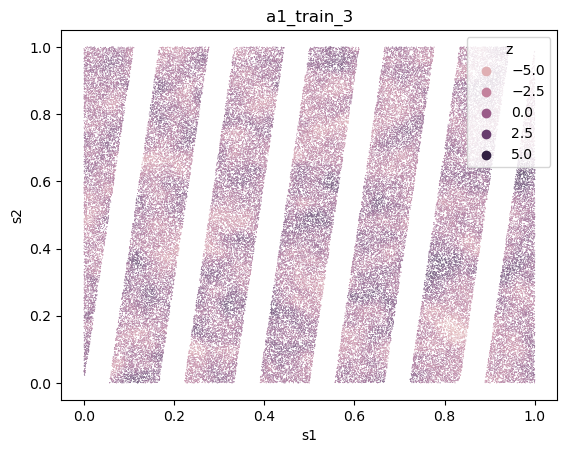

In [28]:
ax = sns.scatterplot(data=df, x='s1', y='s2', hue='z', s=0.5)
ax.set_title("a1_train_3")

<AxesSubplot:xlabel='z', ylabel='Density'>

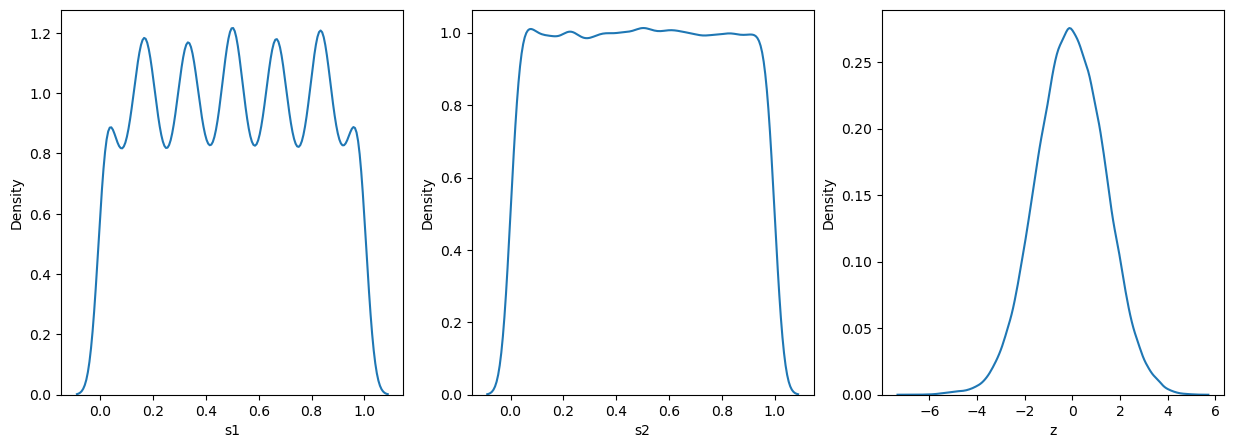

In [29]:
fig,axes = plt.subplots(1,3, figsize=(15,5))
sns.kdeplot(data=df, x='s1', ax=axes[0])
sns.kdeplot(data=df, x='s2', ax=axes[1])
sns.kdeplot(data=df, x='z', ax=axes[2])

## Spatial Cross Validation

### HalfNorm Prior

In [162]:
#| hide
fp = opt.a1_train_3
df = pd.read_csv(fp)
points = df.to_numpy()
nugget = 0.75
varogram_dist = 0.15
inducing_points = torch.load("model/ip500.pt")
folder = 'model/a1_train_3_norm'
if not os.path.isdir(folder):
    os.mkdir(folder)
#
prior='halfnorm'
lr = 0.01
base_lr=0.0001
lr_step=100
device = torch.device("cpu")

best_params = {'acc':0, 'mae':2, 'acc_mae':0}

In [59]:
#| hide
model = lhtcore.GP_AFirst(inducing_points,nu=1, max_tries=200,prior=prior,nugget=nugget)
likelihood = gpytorch.likelihoods.GaussianLikelihood()  
model.to(device)
likelihood.to(device)
params = list(model.parameters()) + list(likelihood.parameters())
optimizer = torch.optim.Adam(params, lr = lr, weight_decay=0.01 )
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=lr_step, eta_min=base_lr)

In [167]:
#| hide
lr=0.001
num_epochs = 5 # 1200
num_iter = tqdm.notebook.tqdm(range(0,num_epochs))
for epoch in num_iter:
    model = lhtcore.GP_AFirst(inducing_points,nu=1, max_tries=200,prior=prior,nugget=nugget)
    likelihood = gpytorch.likelihoods.GaussianLikelihood()  
    mll = gpytorch.mlls.PredictiveLogLikelihood(likelihood, model, num_data=len(points))
    model.to(device)
    likelihood.to(device)
    params = list(model.parameters()) + list(likelihood.parameters())
    optimizer = torch.optim.Adam(params, lr = lr, weight_decay=0.01 )
    lhtutil.lht_train_one_epoch(model,optimizer,likelihood,mll,points,device,lr_scheduler=None,batch_size=200)
    ret_test = lhtutil.lht_test(model,points,device,flag=True)
    acc, mae = ret_test['acc'], ret_test['mae']
    if acc > best_params['acc']:
        best_params['acc'] = acc
        param_fp = os.path.join(folder, f'best_acc.pth')
        torch.save(model.state_dict(), param_fp) 
    #
    if mae < best_params['mae']:
        best_params['mae'] = mae
        param_fp = os.path.join(folder, f'best_mae.pth')
        torch.save(model.state_dict(), param_fp)
    #
    acc_mae = acc / mae
    if acc_mae > best_params['acc_mae']:
        best_params['acc_mae'] = acc_mae
        param_fp = os.path.join(folder, f'best_acc_mae.pth')
        torch.save(model.state_dict(), param_fp)
        

  0%|          | 0/5 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/450 [00:00<?, ?it/s]

test:   0%|          | 0/450 [00:00<?, ?it/s]

num:90000, acc:1.0, mae:1.1460853815078735


Minibatch:   0%|          | 0/450 [00:00<?, ?it/s]

test:   0%|          | 0/450 [00:00<?, ?it/s]

num:81030, acc:0.9003333333333333, mae:1.146174669265747


Minibatch:   0%|          | 0/450 [00:00<?, ?it/s]

test:   0%|          | 0/450 [00:00<?, ?it/s]

num:87454, acc:0.9717111111111111, mae:1.1345492601394653


Minibatch:   0%|          | 0/450 [00:00<?, ?it/s]

test:   0%|          | 0/450 [00:00<?, ?it/s]

num:89888, acc:0.9987555555555555, mae:1.1460951566696167


Minibatch:   0%|          | 0/450 [00:00<?, ?it/s]

test:   0%|          | 0/450 [00:00<?, ?it/s]

num:81112, acc:0.9012444444444444, mae:1.1449939012527466


In [206]:
folder = 'model/a1_train_3_norm'
nugget = 0.75
prior='halfnorm'
state_dict_path = os.path.join(folder,'best_mae.pth')
state_dict = torch.load(state_dict_path)
model = lhtcore.GP_AFirst(inducing_points,nu=1, max_tries=200,prior=prior,nugget=nugget)
model.load_state_dict(state_dict)
kern = model.covar_module.base_kernel

ret_test = lhtutil.lht_test(model,points,device,flag=True)

test:   0%|          | 0/450 [00:00<?, ?it/s]

num:88961, acc:0.9884555555555555, mae:1.1033633947372437


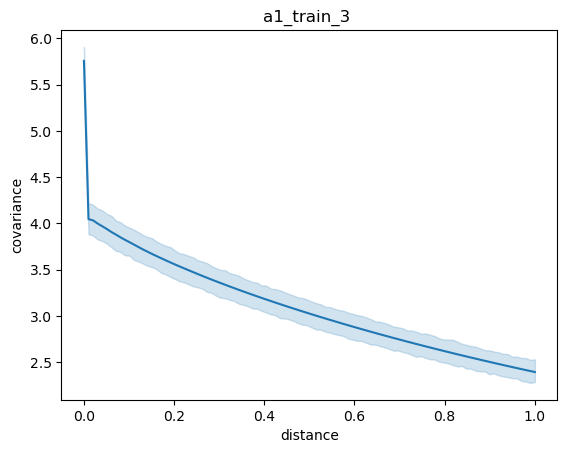

In [169]:
dist = torch.linspace(0,1,100)
lht_show_matern(model.covar_module.base_kernel, 'a1_train_3 ', dist, prior=prior)

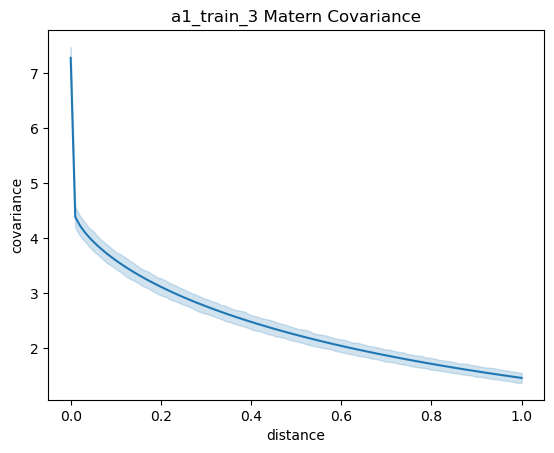

In [208]:
dist = torch.linspace(0,1,100)
lht_show_matern(kern, 'a1_train_3 Matern Covariance', dist, prior=prior)

In [176]:
lhtutil.showCI_NSBN(model)

nu     sigma      beta    nugget
0  0.022203  0.071881  0.038107  0.798061
1  1.588005  5.141184  2.725573  4.187526

### HalfNorm Prior- varigrom

In [126]:
#| hide
fp = opt.a1_train_3
df = pd.read_csv(fp)
nugget = 0.75
varogram_dist = 0.15
inducing_points = torch.load("model/ip500.pt")
folder = 'model/a1_train_3_norm/new'
if not os.path.isdir(folder):
    os.mkdir(folder)
#
prior='halfnorm'
lr = 0.01
base_lr=0.0001
lr_step=100
device = torch.device("cpu")
records = lhtutil.train_LhtMatern_step(df=df, varogram_dist=varogram_dist, inducing_points=inducing_points,base_lr=base_lr,
                               prior=prior, lr=lr, folder=folder,nugget=nugget,device=device, show_ci=False)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:00<00:00, 14153.36it/s]


cross-validation:   0%|          | 0/49 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/412 [00:00<?, ?it/s]

test:   0%|          | 0/10 [00:00<?, ?it/s]

----Test:1953-----


test:   0%|          | 0/10 [00:00<?, ?it/s]

num:1952, acc:0.9994879672299027, mae:1.371806263923645
----All:90000-----


test:   0%|          | 0/450 [00:00<?, ?it/s]

num:89760, acc:0.9973333333333333, mae:1.1530851125717163
------------------------------


Minibatch:   0%|          | 0/393 [00:00<?, ?it/s]

test:   0%|          | 0/10 [00:00<?, ?it/s]

----Test:1923-----


test:   0%|          | 0/10 [00:00<?, ?it/s]

num:1863, acc:0.968798751950078, mae:1.0236202478408813
----All:90000-----


test:   0%|          | 0/450 [00:00<?, ?it/s]

num:84002, acc:0.9333555555555556, mae:1.1529979705810547
------------------------------


Minibatch:   0%|          | 0/394 [00:00<?, ?it/s]

test:   0%|          | 0/10 [00:00<?, ?it/s]

----Test:1895-----


test:   0%|          | 0/10 [00:00<?, ?it/s]

num:1520, acc:0.8021108179419525, mae:1.0330256223678589
----All:90000-----


test:   0%|          | 0/450 [00:00<?, ?it/s]

num:66116, acc:0.7346222222222222, mae:1.1529616117477417
------------------------------


Minibatch:   0%|          | 0/393 [00:00<?, ?it/s]

test:   0%|          | 0/10 [00:00<?, ?it/s]

----Test:1923-----


test:   0%|          | 0/10 [00:00<?, ?it/s]

num:1451, acc:0.7545501820072803, mae:1.112534999847412
----All:90000-----


test:   0%|          | 0/450 [00:00<?, ?it/s]

num:68374, acc:0.7597111111111111, mae:1.152920126914978
------------------------------


Minibatch:   0%|          | 0/392 [00:00<?, ?it/s]

test:   0%|          | 0/10 [00:00<?, ?it/s]

----Test:1909-----


test:   0%|          | 0/10 [00:00<?, ?it/s]

num:1486, acc:0.7784180199057098, mae:0.9831618666648865
----All:90000-----


test:   0%|          | 0/450 [00:00<?, ?it/s]

num:64789, acc:0.7198777777777777, mae:1.1528760194778442
------------------------------


Minibatch:   0%|          | 0/396 [00:00<?, ?it/s]

test:   0%|          | 0/10 [00:00<?, ?it/s]

----Test:1921-----


test:   0%|          | 0/10 [00:00<?, ?it/s]

num:1491, acc:0.7761582509109839, mae:0.8055131435394287
----All:90000-----


test:   0%|          | 0/450 [00:00<?, ?it/s]

num:56126, acc:0.6236222222222222, mae:1.1528292894363403
------------------------------


Minibatch:   0%|          | 0/415 [00:00<?, ?it/s]

test:   0%|          | 0/8 [00:00<?, ?it/s]

----Test:1427-----


test:   0%|          | 0/8 [00:00<?, ?it/s]

num:829, acc:0.5809390329362298, mae:0.853762149810791
----All:90000-----


test:   0%|          | 0/450 [00:00<?, ?it/s]

num:43448, acc:0.48275555555555555, mae:1.1527729034423828
------------------------------


Minibatch:   0%|          | 0/393 [00:00<?, ?it/s]

test:   0%|          | 0/10 [00:00<?, ?it/s]

----Test:1949-----


test:   0%|          | 0/10 [00:00<?, ?it/s]

num:925, acc:0.4746023601847101, mae:1.298134446144104
----All:90000-----


test:   0%|          | 0/450 [00:00<?, ?it/s]

num:49975, acc:0.5552777777777778, mae:1.1527200937271118
------------------------------


Minibatch:   0%|          | 0/364 [00:00<?, ?it/s]

test:   0%|          | 0/9 [00:00<?, ?it/s]

----Test:1798-----


test:   0%|          | 0/9 [00:00<?, ?it/s]

num:1240, acc:0.6896551724137931, mae:1.0426231622695923
----All:90000-----


test:   0%|          | 0/450 [00:00<?, ?it/s]

num:58091, acc:0.6454555555555556, mae:1.152661919593811
------------------------------


Minibatch:   0%|          | 0/365 [00:00<?, ?it/s]

test:   0%|          | 0/10 [00:00<?, ?it/s]

----Test:1936-----


test:   0%|          | 0/10 [00:00<?, ?it/s]

num:688, acc:0.35537190082644626, mae:1.534306526184082
----All:90000-----


test:   0%|          | 0/450 [00:00<?, ?it/s]

num:47724, acc:0.5302666666666667, mae:1.1525661945343018
------------------------------


Minibatch:   0%|          | 0/363 [00:00<?, ?it/s]

test:   0%|          | 0/10 [00:00<?, ?it/s]

----Test:1908-----


test:   0%|          | 0/10 [00:00<?, ?it/s]

num:897, acc:0.470125786163522, mae:1.1564068794250488
----All:90000-----


test:   0%|          | 0/450 [00:00<?, ?it/s]

num:43888, acc:0.48764444444444444, mae:1.1523994207382202
------------------------------


Minibatch:   0%|          | 0/361 [00:00<?, ?it/s]

test:   0%|          | 0/10 [00:00<?, ?it/s]

----Test:1882-----


test:   0%|          | 0/10 [00:00<?, ?it/s]

num:677, acc:0.35972369819341127, mae:1.3180413246154785
----All:90000-----


test:   0%|          | 0/450 [00:00<?, ?it/s]

num:36932, acc:0.41035555555555553, mae:1.1522306203842163
------------------------------


Minibatch:   0%|          | 0/367 [00:00<?, ?it/s]

test:   0%|          | 0/11 [00:00<?, ?it/s]

----Test:2153-----


test:   0%|          | 0/11 [00:00<?, ?it/s]

num:1244, acc:0.5777984208081747, mae:1.1315362453460693
----All:90000-----


test:   0%|          | 0/450 [00:00<?, ?it/s]

num:54719, acc:0.6079888888888889, mae:1.1520822048187256
------------------------------


Minibatch:   0%|          | 0/397 [00:00<?, ?it/s]

test:   0%|          | 0/8 [00:00<?, ?it/s]

----Test:1509-----


test:   0%|          | 0/8 [00:00<?, ?it/s]

num:811, acc:0.5374420145791915, mae:0.9283550977706909
----All:90000-----


test:   0%|          | 0/450 [00:00<?, ?it/s]

num:43669, acc:0.4852111111111111, mae:1.1518973112106323
------------------------------


Minibatch:   0%|          | 0/393 [00:00<?, ?it/s]

test:   0%|          | 0/10 [00:00<?, ?it/s]

----Test:1929-----


test:   0%|          | 0/10 [00:00<?, ?it/s]

num:998, acc:0.5173665111456713, mae:1.0225406885147095
----All:90000-----


test:   0%|          | 0/450 [00:00<?, ?it/s]

num:39321, acc:0.4369, mae:1.1517198085784912
------------------------------


Minibatch:   0%|          | 0/364 [00:00<?, ?it/s]

test:   0%|          | 0/10 [00:00<?, ?it/s]

----Test:1897-----


test:   0%|          | 0/10 [00:00<?, ?it/s]

num:788, acc:0.415392725355825, mae:1.4432692527770996
----All:90000-----


test:   0%|          | 0/450 [00:00<?, ?it/s]

num:45560, acc:0.5062222222222222, mae:1.1514915227890015
------------------------------


Minibatch:   0%|          | 0/363 [00:00<?, ?it/s]

test:   0%|          | 0/10 [00:00<?, ?it/s]

----Test:1930-----


test:   0%|          | 0/10 [00:00<?, ?it/s]

num:1133, acc:0.5870466321243524, mae:0.9105699062347412
----All:90000-----


test:   0%|          | 0/450 [00:00<?, ?it/s]

num:40557, acc:0.45063333333333333, mae:1.1512343883514404
------------------------------


Minibatch:   0%|          | 0/359 [00:00<?, ?it/s]

test:   0%|          | 0/10 [00:00<?, ?it/s]

----Test:1896-----


test:   0%|          | 0/10 [00:00<?, ?it/s]

num:913, acc:0.48154008438818563, mae:1.215794563293457
----All:90000-----


test:   0%|          | 0/450 [00:00<?, ?it/s]

num:42141, acc:0.46823333333333333, mae:1.150773048400879
------------------------------


Minibatch:   0%|          | 0/355 [00:00<?, ?it/s]

test:   0%|          | 0/12 [00:00<?, ?it/s]

----Test:2203-----


test:   0%|          | 0/12 [00:00<?, ?it/s]

num:1131, acc:0.513390830685429, mae:1.0056676864624023
----All:90000-----


test:   0%|          | 0/450 [00:00<?, ?it/s]

num:42614, acc:0.4734888888888889, mae:1.150259256362915
------------------------------


Minibatch:   0%|          | 0/363 [00:00<?, ?it/s]

test:   0%|          | 0/11 [00:00<?, ?it/s]

----Test:2186-----


test:   0%|          | 0/11 [00:00<?, ?it/s]

num:1136, acc:0.5196706312900274, mae:1.1093896627426147
----All:90000-----


test:   0%|          | 0/450 [00:00<?, ?it/s]

num:48973, acc:0.5441444444444444, mae:1.1497845649719238
------------------------------


Minibatch:   0%|          | 0/395 [00:00<?, ?it/s]

test:   0%|          | 0/8 [00:00<?, ?it/s]

----Test:1439-----


test:   0%|          | 0/8 [00:00<?, ?it/s]

num:718, acc:0.49895760945100764, mae:0.7690874934196472
----All:90000-----


test:   0%|          | 0/450 [00:00<?, ?it/s]

num:36349, acc:0.4038777777777778, mae:1.1493202447891235
------------------------------


Minibatch:   0%|          | 0/393 [00:00<?, ?it/s]

test:   0%|          | 0/10 [00:00<?, ?it/s]

----Test:1941-----


test:   0%|          | 0/10 [00:00<?, ?it/s]

num:1365, acc:0.7032457496136012, mae:1.047890305519104
----All:90000-----


test:   0%|          | 0/450 [00:00<?, ?it/s]

num:60740, acc:0.6748888888888889, mae:1.149052619934082
------------------------------


Minibatch:   0%|          | 0/363 [00:00<?, ?it/s]

test:   0%|          | 0/10 [00:00<?, ?it/s]

----Test:1942-----


test:   0%|          | 0/10 [00:00<?, ?it/s]

num:830, acc:0.427394438722966, mae:1.3016819953918457
----All:90000-----


test:   0%|          | 0/450 [00:00<?, ?it/s]

num:42028, acc:0.46697777777777777, mae:1.148855447769165
------------------------------


Minibatch:   0%|          | 0/360 [00:00<?, ?it/s]

test:   0%|          | 0/10 [00:00<?, ?it/s]

----Test:1976-----


test:   0%|          | 0/10 [00:00<?, ?it/s]

num:1137, acc:0.5754048582995951, mae:0.981139600276947
----All:90000-----


test:   0%|          | 0/450 [00:00<?, ?it/s]

num:44275, acc:0.49194444444444446, mae:1.148795485496521
------------------------------


Minibatch:   0%|          | 0/355 [00:00<?, ?it/s]

test:   0%|          | 0/11 [00:00<?, ?it/s]

----Test:2197-----


test:   0%|          | 0/11 [00:00<?, ?it/s]

num:907, acc:0.41283568502503415, mae:1.5183907747268677
----All:90000-----


test:   0%|          | 0/450 [00:00<?, ?it/s]

num:47945, acc:0.5327222222222222, mae:1.1483122110366821
------------------------------


Minibatch:   0%|          | 0/353 [00:00<?, ?it/s]

test:   0%|          | 0/12 [00:00<?, ?it/s]

----Test:2289-----


test:   0%|          | 0/12 [00:00<?, ?it/s]

num:1240, acc:0.5417212756662297, mae:1.2233240604400635
----All:90000-----


test:   0%|          | 0/450 [00:00<?, ?it/s]

num:53604, acc:0.5956, mae:1.1475095748901367
------------------------------


Minibatch:   0%|          | 0/364 [00:00<?, ?it/s]

test:   0%|          | 0/12 [00:00<?, ?it/s]

----Test:2291-----


test:   0%|          | 0/12 [00:00<?, ?it/s]

num:636, acc:0.2776080314273243, mae:1.3135377168655396
----All:90000-----


test:   0%|          | 0/450 [00:00<?, ?it/s]

num:33857, acc:0.3761888888888889, mae:1.1468536853790283
------------------------------


Minibatch:   0%|          | 0/397 [00:00<?, ?it/s]

test:   0%|          | 0/8 [00:00<?, ?it/s]

----Test:1464-----


test:   0%|          | 0/8 [00:00<?, ?it/s]

num:607, acc:0.4146174863387978, mae:1.3776909112930298
----All:90000-----


test:   0%|          | 0/450 [00:00<?, ?it/s]

num:52494, acc:0.5832666666666667, mae:1.1464132070541382
------------------------------


Minibatch:   0%|          | 0/391 [00:00<?, ?it/s]

test:   0%|          | 0/10 [00:00<?, ?it/s]

----Test:1914-----


test:   0%|          | 0/10 [00:00<?, ?it/s]

num:967, acc:0.5052246603970741, mae:0.9051229357719421
----All:90000-----


test:   0%|          | 0/450 [00:00<?, ?it/s]

num:34171, acc:0.3796777777777778, mae:1.1460994482040405
------------------------------


Minibatch:   0%|          | 0/360 [00:00<?, ?it/s]

test:   0%|          | 0/10 [00:00<?, ?it/s]

----Test:1945-----


test:   0%|          | 0/10 [00:00<?, ?it/s]

num:642, acc:0.3300771208226221, mae:1.3015965223312378
----All:90000-----


test:   0%|          | 0/450 [00:00<?, ?it/s]

num:33336, acc:0.3704, mae:1.1460387706756592
------------------------------


Minibatch:   0%|          | 0/355 [00:00<?, ?it/s]

test:   0%|          | 0/11 [00:00<?, ?it/s]

----Test:2101-----


test:   0%|          | 0/11 [00:00<?, ?it/s]

num:1294, acc:0.6158971918134222, mae:0.9458963871002197
----All:90000-----


test:   0%|          | 0/450 [00:00<?, ?it/s]

num:48858, acc:0.5428666666666667, mae:1.1461342573165894
------------------------------


Minibatch:   0%|          | 0/352 [00:00<?, ?it/s]

test:   0%|          | 0/12 [00:00<?, ?it/s]

----Test:2280-----


test:   0%|          | 0/12 [00:00<?, ?it/s]

num:1257, acc:0.5513157894736842, mae:0.9716810584068298
----All:90000-----


test:   0%|          | 0/450 [00:00<?, ?it/s]

num:40994, acc:0.4554888888888889, mae:1.146378993988037
------------------------------


Minibatch:   0%|          | 0/353 [00:00<?, ?it/s]

test:   0%|          | 0/11 [00:00<?, ?it/s]

----Test:2192-----


test:   0%|          | 0/11 [00:00<?, ?it/s]

num:1805, acc:0.8234489051094891, mae:0.994564414024353
----All:90000-----


test:   0%|          | 0/450 [00:00<?, ?it/s]

num:66060, acc:0.734, mae:1.1461747884750366
------------------------------


Minibatch:   0%|          | 0/366 [00:00<?, ?it/s]

test:   0%|          | 0/11 [00:00<?, ?it/s]

----Test:2027-----


test:   0%|          | 0/11 [00:00<?, ?it/s]

num:986, acc:0.48643315244203256, mae:1.1483017206192017
----All:90000-----


test:   0%|          | 0/450 [00:00<?, ?it/s]

num:50069, acc:0.5563222222222223, mae:1.1460464000701904
------------------------------


Minibatch:   0%|          | 0/399 [00:00<?, ?it/s]

test:   0%|          | 0/7 [00:00<?, ?it/s]

----Test:1289-----


test:   0%|          | 0/7 [00:00<?, ?it/s]

num:747, acc:0.5795190069821567, mae:0.7130873203277588
----All:90000-----


test:   0%|          | 0/450 [00:00<?, ?it/s]

num:41772, acc:0.46413333333333334, mae:1.1461023092269897
------------------------------


Minibatch:   0%|          | 0/392 [00:00<?, ?it/s]

test:   0%|          | 0/10 [00:00<?, ?it/s]

----Test:1926-----


test:   0%|          | 0/10 [00:00<?, ?it/s]

num:638, acc:0.3312564901349948, mae:1.3971383571624756
----All:90000-----


test:   0%|          | 0/450 [00:00<?, ?it/s]

num:33832, acc:0.3759111111111111, mae:1.1466681957244873
------------------------------


Minibatch:   0%|          | 0/363 [00:00<?, ?it/s]

test:   0%|          | 0/11 [00:00<?, ?it/s]

----Test:2185-----


test:   0%|          | 0/11 [00:00<?, ?it/s]

num:356, acc:0.16292906178489702, mae:1.9849908351898193
----All:90000-----


test:   0%|          | 0/450 [00:00<?, ?it/s]

num:34101, acc:0.3789, mae:1.1461361646652222
------------------------------


Minibatch:   0%|          | 0/364 [00:00<?, ?it/s]

test:   0%|          | 0/12 [00:00<?, ?it/s]

----Test:2256-----


test:   0%|          | 0/12 [00:00<?, ?it/s]

num:603, acc:0.26728723404255317, mae:1.7208670377731323
----All:90000-----


test:   0%|          | 0/450 [00:00<?, ?it/s]

num:40134, acc:0.44593333333333335, mae:1.146512746810913
------------------------------


Minibatch:   0%|          | 0/367 [00:00<?, ?it/s]

test:   0%|          | 0/12 [00:00<?, ?it/s]

----Test:2282-----


test:   0%|          | 0/12 [00:00<?, ?it/s]

num:1322, acc:0.5793163891323401, mae:0.7892975211143494
----All:90000-----


test:   0%|          | 0/450 [00:00<?, ?it/s]

num:39610, acc:0.4401111111111111, mae:1.1489213705062866
------------------------------


Minibatch:   0%|          | 0/372 [00:00<?, ?it/s]

test:   0%|          | 0/11 [00:00<?, ?it/s]

----Test:2123-----


test:   0%|          | 0/11 [00:00<?, ?it/s]

num:932, acc:0.43900141309467733, mae:0.9938293099403381
----All:90000-----


test:   0%|          | 0/450 [00:00<?, ?it/s]

num:39496, acc:0.4388444444444444, mae:1.146769642829895
------------------------------


Minibatch:   0%|          | 0/384 [00:00<?, ?it/s]

test:   0%|          | 0/10 [00:00<?, ?it/s]

----Test:1902-----


test:   0%|          | 0/10 [00:00<?, ?it/s]

num:964, acc:0.5068349106203995, mae:1.0461704730987549
----All:90000-----


test:   0%|          | 0/450 [00:00<?, ?it/s]

num:45827, acc:0.5091888888888889, mae:1.1461665630340576
------------------------------


Minibatch:   0%|          | 0/410 [00:00<?, ?it/s]

test:   0%|          | 0/7 [00:00<?, ?it/s]

----Test:1289-----


test:   0%|          | 0/7 [00:00<?, ?it/s]

num:643, acc:0.49883630721489525, mae:1.054429531097412
----All:90000-----


test:   0%|          | 0/450 [00:00<?, ?it/s]

num:47139, acc:0.5237666666666667, mae:1.146039366722107
------------------------------


Minibatch:   0%|          | 0/411 [00:00<?, ?it/s]

test:   0%|          | 0/10 [00:00<?, ?it/s]

----Test:1998-----


test:   0%|          | 0/10 [00:00<?, ?it/s]

num:741, acc:0.3708708708708709, mae:1.0965698957443237
----All:90000-----


test:   0%|          | 0/450 [00:00<?, ?it/s]

num:39139, acc:0.43487777777777775, mae:1.1479161977767944
------------------------------


Minibatch:   0%|          | 0/393 [00:00<?, ?it/s]

test:   0%|          | 0/9 [00:00<?, ?it/s]

----Test:1722-----


test:   0%|          | 0/9 [00:00<?, ?it/s]

num:1135, acc:0.6591173054587689, mae:0.8874016404151917
----All:90000-----


test:   0%|          | 0/450 [00:00<?, ?it/s]

num:49979, acc:0.5553222222222223, mae:1.146407961845398
------------------------------


Minibatch:   0%|          | 0/396 [00:00<?, ?it/s]

test:   0%|          | 0/8 [00:00<?, ?it/s]

----Test:1407-----


test:   0%|          | 0/8 [00:00<?, ?it/s]

num:604, acc:0.4292821606254442, mae:1.3768216371536255
----All:90000-----


test:   0%|          | 0/450 [00:00<?, ?it/s]

num:49182, acc:0.5464666666666667, mae:1.146007776260376
------------------------------


Minibatch:   0%|          | 0/400 [00:00<?, ?it/s]

test:   0%|          | 0/6 [00:00<?, ?it/s]

----Test:1091-----


test:   0%|          | 0/6 [00:00<?, ?it/s]

num:390, acc:0.35747021081576535, mae:1.1886796951293945
----All:90000-----


test:   0%|          | 0/450 [00:00<?, ?it/s]

num:34762, acc:0.38624444444444445, mae:1.148723840713501
------------------------------


Minibatch:   0%|          | 0/404 [00:00<?, ?it/s]

test:   0%|          | 0/5 [00:00<?, ?it/s]

----Test:886-----


test:   0%|          | 0/5 [00:00<?, ?it/s]

num:202, acc:0.22799097065462753, mae:1.9416351318359375
----All:90000-----


test:   0%|          | 0/450 [00:00<?, ?it/s]

num:46207, acc:0.5134111111111112, mae:1.1463525295257568
------------------------------


Minibatch:   0%|          | 0/412 [00:00<?, ?it/s]

test:   0%|          | 0/5 [00:00<?, ?it/s]

----Test:948-----


test:   0%|          | 0/5 [00:00<?, ?it/s]

num:443, acc:0.46729957805907174, mae:0.9408854842185974
----All:90000-----


test:   0%|          | 0/450 [00:00<?, ?it/s]

num:40389, acc:0.44876666666666665, mae:1.1471264362335205
------------------------------


Minibatch:   0%|          | 0/427 [00:00<?, ?it/s]

test:   0%|          | 0/3 [00:00<?, ?it/s]

----Test:571-----


test:   0%|          | 0/3 [00:00<?, ?it/s]

num:212, acc:0.3712784588441331, mae:1.2296313047409058
----All:90000-----


test:   0%|          | 0/450 [00:00<?, ?it/s]

num:46389, acc:0.5154333333333333, mae:1.146046757698059
------------------------------


In [119]:
mae = [ret['mae'] for ret in records]
acc = [ret['acc'] for ret in records]
mae = np.array(mae)
acc = np.array(acc)
am = acc/mae
idx = am.argmax()
print(f"ids:{idx}, mae:{mae[idx]}, acc:{acc[idx]}")

ids:3, mae:1.2018855810165405, acc:0.9146444444444445


#### HalfNorm Prior-old

In [97]:
#| hide
fp = opt.a1_train_3
df = pd.read_csv(fp)
varogram_dist = 0.15
inducing_points = torch.load("model/ip500.pt")
folder = 'model/a1_train_3_norm'
if not os.path.isdir(folder):
    os.mkdir(folder)
records_norm_3 = train_LhtMatern(df=df, varogram_dist=varogram_dist, inducing_points=inducing_points, prior='halfnorm',lr=0.01, folder=folder)

100%|████████████████████████████████████████████████████| 49/49 [00:00<00:00, 15017.97it/s]


         nu     sigma      beta    nugget
0  0.037255  0.032778  0.034164  0.076971
1  2.664590  2.344375  2.443515  5.505261


cross-validation:   0%|          | 0/49 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/421 [00:00<?, ?it/s]

test:   0%|          | 0/10 [00:00<?, ?it/s]

Test, MAE: 1.3870506286621094 ,  ACC: 0.9006656426011265, train:84175, test:1953
          nu     sigma      beta    nugget
0   0.150847  0.005327  0.101425  0.010638
1  10.789120  0.381013  7.254261  0.760901


Minibatch:   0%|          | 0/413 [00:00<?, ?it/s]

test:   0%|          | 0/10 [00:00<?, ?it/s]

Test, MAE: 1.071815848350525 ,  ACC: 0.8803952158086323, train:82431, test:1923
          nu     sigma      beta    nugget
0   0.197872  0.002933  0.125309  0.003077
1  14.152483  0.209745  8.962576  0.220084


Minibatch:   0%|          | 0/412 [00:00<?, ?it/s]

test:   0%|          | 0/10 [00:00<?, ?it/s]

Test, MAE: 1.0225805044174194 ,  ACC: 0.9313984168865436, train:82323, test:1895
          nu     sigma       beta    nugget
0   0.227763  0.002049   0.139931  0.001462
1  16.290427  0.146565  10.008363  0.104591


Minibatch:   0%|          | 0/412 [00:00<?, ?it/s]

test:   0%|          | 0/10 [00:00<?, ?it/s]

Test, MAE: 1.1492124795913696 ,  ACC: 0.8949557982319293, train:82365, test:1923
          nu     sigma       beta    nugget
0   0.250516  0.001574   0.150831  0.000852
1  17.917784  0.112594  10.787967  0.060969


Minibatch:   0%|          | 0/412 [00:00<?, ?it/s]

test:   0%|          | 0/10 [00:00<?, ?it/s]

Test, MAE: 0.9332373142242432 ,  ACC: 0.8947092718700891, train:82365, test:1909
          nu     sigma       beta    nugget
0   0.269253  0.001273   0.159701  0.000553
1  19.257906  0.091049  11.422379  0.039537


Minibatch:   0%|          | 0/413 [00:00<?, ?it/s]

test:   0%|          | 0/10 [00:00<?, ?it/s]

Test, MAE: 0.8120313286781311 ,  ACC: 0.9541905257678293, train:82590, test:1921
          nu     sigma       beta    nugget
0   0.285402  0.001063   0.167299  0.000382
1  20.412953  0.076019  11.965778  0.027314


Minibatch:   0%|          | 0/426 [00:00<?, ?it/s]

test:   0%|          | 0/8 [00:00<?, ?it/s]

Test, MAE: 0.9516273736953735 ,  ACC: 0.9838822704975473, train:85143, test:1427
          nu     sigma       beta    nugget
0   0.300061  0.000904   0.174181  0.000272
1  21.461446  0.064630  12.458033  0.019488


Minibatch:   0%|          | 0/412 [00:00<?, ?it/s]

test:   0%|          | 0/10 [00:00<?, ?it/s]

Test, MAE: 1.303518295288086 ,  ACC: 0.7644946126218574, train:82371, test:1949
          nu     sigma       beta    nugget
0   0.312724  0.000786   0.180138  0.000202
1  22.367146  0.056205  12.884075  0.014467


Minibatch:   0%|          | 0/403 [00:00<?, ?it/s]

test:   0%|          | 0/9 [00:00<?, ?it/s]

Test, MAE: 0.9491338729858398 ,  ACC: 0.8787541713014461, train:80497, test:1798
          nu     sigma       beta    nugget
0   0.323930  0.000695   0.185427  0.000154
1  23.168615  0.049678  13.262396  0.011029


Minibatch:   0%|          | 0/403 [00:00<?, ?it/s]

test:   0%|          | 0/10 [00:00<?, ?it/s]

Test, MAE: 1.6641826629638672 ,  ACC: 0.7350206611570248, train:80533, test:1936
          nu     sigma       beta    nugget
0   0.334140  0.000621   0.190268  0.000119
1  23.898857  0.044390  13.608631  0.008536


Minibatch:   0%|          | 0/403 [00:00<?, ?it/s]

test:   0%|          | 0/10 [00:00<?, ?it/s]

Test, MAE: 1.213476300239563 ,  ACC: 0.8611111111111112, train:80455, test:1908
          nu     sigma       beta    nugget
0   0.343473  0.000560   0.194717  0.000093
1  24.566385  0.040042  13.926860  0.006683


Minibatch:   0%|          | 0/400 [00:00<?, ?it/s]

test:   0%|          | 0/10 [00:00<?, ?it/s]

Test, MAE: 1.3145595788955688 ,  ACC: 0.6482465462274176, train:79945, test:1882
          nu     sigma       beta    nugget
0   0.351966  0.000510   0.198790  0.000074
1  25.173842  0.036445  14.218149  0.005289


Minibatch:   0%|          | 0/402 [00:00<?, ?it/s]

test:   0%|          | 0/11 [00:00<?, ?it/s]

Test, MAE: 1.1041221618652344 ,  ACC: 0.7505805852299118, train:80349, test:2153
          nu     sigma       beta    nugget
0   0.359809  0.000467   0.202574  0.000059
1  25.734806  0.033401  14.488814  0.004210


Minibatch:   0%|          | 0/418 [00:00<?, ?it/s]

test:   0%|          | 0/8 [00:00<?, ?it/s]

Test, MAE: 0.9716868996620178 ,  ACC: 0.9264413518886679, train:83472, test:1509
          nu     sigma       beta    nugget
0   0.367309  0.000429   0.206216  0.000047
1  26.271256  0.030716  14.749300  0.003340


Minibatch:   0%|          | 0/412 [00:00<?, ?it/s]

test:   0%|          | 0/10 [00:00<?, ?it/s]

Test, MAE: 1.0229756832122803 ,  ACC: 0.9528252980819077, train:82284, test:1929
          nu     sigma       beta    nugget
0   0.374156  0.000398   0.209563  0.000037
1  26.760982  0.028443  14.988676  0.002669


Minibatch:   0%|          | 0/403 [00:00<?, ?it/s]

test:   0%|          | 0/10 [00:00<?, ?it/s]

Test, MAE: 1.396117091178894 ,  ACC: 0.8703215603584608, train:80504, test:1897
          nu     sigma       beta    nugget
0   0.380357  0.000371   0.212612  0.000030
1  27.204467  0.026522  15.206776  0.002151


Minibatch:   0%|          | 0/402 [00:00<?, ?it/s]

test:   0%|          | 0/10 [00:00<?, ?it/s]

Test, MAE: 0.8865823149681091 ,  ACC: 0.9678756476683937, train:80365, test:1930
          nu     sigma       beta    nugget
0   0.386094  0.000347   0.215450  0.000024
1  27.614818  0.024853  15.409762  0.001739


Minibatch:   0%|          | 0/400 [00:00<?, ?it/s]

test:   0%|          | 0/10 [00:00<?, ?it/s]

Test, MAE: 1.2518115043640137 ,  ACC: 0.8037974683544303, train:79866, test:1896
          nu     sigma       beta    nugget
0   0.391405  0.000327   0.218092  0.000020
1  27.994651  0.023395  15.598693  0.001411


Minibatch:   0%|          | 0/398 [00:00<?, ?it/s]

test:   0%|          | 0/12 [00:00<?, ?it/s]

Test, MAE: 0.9968769550323486 ,  ACC: 0.9069450748978666, train:79544, test:2203
          nu     sigma       beta    nugget
0   0.396329  0.000309   0.220554  0.000016
1  28.346826  0.022114  15.774813  0.001148


Minibatch:   0%|          | 0/399 [00:00<?, ?it/s]

test:   0%|          | 0/11 [00:00<?, ?it/s]

Test, MAE: 1.124829888343811 ,  ACC: 0.8215919487648673, train:79728, test:2186
          nu     sigma       beta    nugget
0   0.400946  0.000293   0.222874  0.000013
1  28.677044  0.020973  15.940714  0.000935


Minibatch:   0%|          | 0/418 [00:00<?, ?it/s]

test:   0%|          | 0/8 [00:00<?, ?it/s]

Test, MAE: 0.7722780704498291 ,  ACC: 0.8860319666435025, train:83402, test:1439
          nu     sigma       beta    nugget
0   0.405490  0.000278   0.225168  0.000011
1  29.002055  0.019902  16.104838  0.000755


Minibatch:   0%|          | 0/412 [00:00<?, ?it/s]

test:   0%|          | 0/10 [00:00<?, ?it/s]

Test, MAE: 1.0450242757797241 ,  ACC: 0.9629057187017002, train:82274, test:1941
          nu     sigma       beta    nugget
0   0.409739  0.000265   0.227324  0.000009
1  29.305960  0.018947  16.259004  0.000612


Minibatch:   0%|          | 0/402 [00:00<?, ?it/s]

test:   0%|          | 0/10 [00:00<?, ?it/s]

Test, MAE: 1.3274136781692505 ,  ACC: 0.8944387229660145, train:80299, test:1942
          nu     sigma       beta    nugget
0   0.413661  0.000253   0.229322  0.000007
1  29.586460  0.018103  16.401924  0.000499


Minibatch:   0%|          | 0/400 [00:00<?, ?it/s]

test:   0%|          | 0/10 [00:00<?, ?it/s]

Test, MAE: 0.9965111613273621 ,  ACC: 0.9741902834008097, train:79854, test:1976
          nu     sigma       beta    nugget
0   0.417362  0.000242   0.231216  0.000006
1  29.851183  0.017338  16.537358  0.000408


Minibatch:   0%|          | 0/397 [00:00<?, ?it/s]

test:   0%|          | 0/11 [00:00<?, ?it/s]

Test, MAE: 1.5334314107894897 ,  ACC: 0.7633136094674556, train:79362, test:2197
          nu     sigma       beta    nugget
0   0.420855  0.000233   0.233009  0.000005
1  30.101018  0.016644  16.665642  0.000334


Minibatch:   0%|          | 0/395 [00:00<?, ?it/s]

test:   0%|          | 0/12 [00:00<?, ?it/s]

Test, MAE: 1.2273681163787842 ,  ACC: 0.9248580166011359, train:78828, test:2289
          nu     sigma       beta    nugget
0   0.424166  0.000224   0.234715  0.000004
1  30.337841  0.016010  16.787673  0.000273


Minibatch:   0%|          | 0/399 [00:00<?, ?it/s]

test:   0%|          | 0/12 [00:00<?, ?it/s]

Test, MAE: 1.4002975225448608 ,  ACC: 0.6870362287210825, train:79743, test:2291
          nu     sigma       beta    nugget
0   0.427362  0.000216   0.236368  0.000003
1  30.566464  0.015418  16.905878  0.000224


Minibatch:   0%|          | 0/418 [00:00<?, ?it/s]

test:   0%|          | 0/8 [00:00<?, ?it/s]

Test, MAE: 1.4147605895996094 ,  ACC: 0.6782786885245902, train:83517, test:1464
          nu     sigma       beta    nugget
0   0.430585  0.000208   0.238040  0.000003
1  30.796922  0.014843  17.025424  0.000182


Minibatch:   0%|          | 0/412 [00:00<?, ?it/s]

test:   0%|          | 0/10 [00:00<?, ?it/s]

Test, MAE: 0.9177772402763367 ,  ACC: 0.987460815047022, train:82274, test:1914
          nu     sigma       beta    nugget
0   0.433661  0.000200   0.239640  0.000002
1  31.016957  0.014312  17.139887  0.000148


Minibatch:   0%|          | 0/400 [00:00<?, ?it/s]

test:   0%|          | 0/10 [00:00<?, ?it/s]

Test, MAE: 1.291370153427124 ,  ACC: 0.9033419023136247, train:79913, test:1945
          nu     sigma       beta    nugget
0   0.436544  0.000193   0.241144  0.000002
1  31.223145  0.013830  17.247451  0.000121


Minibatch:   0%|          | 0/398 [00:00<?, ?it/s]

test:   0%|          | 0/11 [00:00<?, ?it/s]

Test, MAE: 0.9661780595779419 ,  ACC: 0.9985721085197525, train:79442, test:2101
          nu     sigma       beta    nugget
0   0.439316  0.000187   0.242594  0.000001
1  31.421432  0.013381  17.351184  0.000099


Minibatch:   0%|          | 0/395 [00:00<?, ?it/s]

test:   0%|          | 0/12 [00:00<?, ?it/s]

Test, MAE: 0.975432813167572 ,  ACC: 0.9618421052631579, train:78948, test:2280
          nu     sigma       beta    nugget
0   0.441981  0.000181   0.243991  0.000001
1  31.612030  0.012963  17.451106  0.000081


Minibatch:   0%|          | 0/396 [00:00<?, ?it/s]

test:   0%|          | 0/11 [00:00<?, ?it/s]

Test, MAE: 1.0034589767456055 ,  ACC: 0.9603102189781022, train:79089, test:2192
          nu     sigma       beta        nugget
0   0.444571  0.000176   0.245352  9.320223e-07
1  31.797310  0.012568  17.548457  6.666151e-05


Minibatch:   0%|          | 0/402 [00:00<?, ?it/s]

test:   0%|          | 0/11 [00:00<?, ?it/s]

Test, MAE: 1.1742466688156128 ,  ACC: 0.9629995066600888, train:80299, test:2027
          nu     sigma       beta        nugget
0   0.447126  0.000170   0.246697  7.627246e-07
1  31.980006  0.012189  17.644637  5.455275e-05


Minibatch:   0%|          | 0/420 [00:00<?, ?it/s]

test:   0%|          | 0/7 [00:00<?, ?it/s]

Test, MAE: 0.7126682996749878 ,  ACC: 0.9495733126454616, train:83931, test:1289
          nu     sigma       beta        nugget
0   0.449723  0.000165   0.248068  6.184521e-07
1  32.165806  0.011815  17.742690  4.423387e-05


Minibatch:   0%|          | 0/410 [00:00<?, ?it/s]

test:   0%|          | 0/10 [00:00<?, ?it/s]

Test, MAE: 1.5481975078582764 ,  ACC: 0.8276220145379024, train:81977, test:1926
          nu     sigma       beta        nugget
0   0.452199  0.000160   0.249376  5.038550e-07
1  32.342899  0.011469  17.836282  3.603748e-05


Minibatch:   0%|          | 0/400 [00:00<?, ?it/s]

test:   0%|          | 0/11 [00:00<?, ?it/s]

Test, MAE: 2.078866720199585 ,  ACC: 0.5890160183066362, train:79966, test:2185
          nu     sigma       beta        nugget
0   0.454550  0.000156   0.250621  4.125714e-07
1  32.510995  0.011149  17.925290  2.950856e-05


Minibatch:   0%|          | 0/399 [00:00<?, ?it/s]

test:   0%|          | 0/12 [00:00<?, ?it/s]

Test, MAE: 1.6692475080490112 ,  ACC: 0.7557624113475178, train:79769, test:2256
          nu     sigma       beta        nugget
0   0.456828  0.000152   0.251829  3.380251e-07
1  32.673970  0.010847  18.011671  2.417675e-05


Minibatch:   0%|          | 0/400 [00:00<?, ?it/s]

test:   0%|          | 0/12 [00:00<?, ?it/s]

Test, MAE: 0.8357567191123962 ,  ACC: 0.9916739702015775, train:79968, test:2282
          nu     sigma       beta        nugget
0   0.459047  0.000148   0.253006  2.768796e-07
1  32.832657  0.010560  18.095900  1.980341e-05


Minibatch:   0%|          | 0/404 [00:00<?, ?it/s]

test:   0%|          | 0/11 [00:00<?, ?it/s]

Test, MAE: 0.9188604354858398 ,  ACC: 0.9618464437117287, train:80615, test:2123
          nu     sigma       beta        nugget
0   0.461221  0.000144   0.254161  2.263568e-07
1  32.988139  0.010287  18.178500  1.618983e-05


Minibatch:   0%|          | 0/409 [00:00<?, ?it/s]

test:   0%|          | 0/10 [00:00<?, ?it/s]

Test, MAE: 0.9814601540565491 ,  ACC: 0.9936908517350158, train:81711, test:1902
          nu     sigma       beta        nugget
0   0.463358  0.000140   0.255297  1.846136e-07
1  33.140960  0.010025  18.259749  1.320422e-05


Minibatch:   0%|          | 0/425 [00:00<?, ?it/s]

test:   0%|          | 0/7 [00:00<?, ?it/s]

Test, MAE: 1.1803677082061768 ,  ACC: 0.9247478665632273, train:84949, test:1289
          nu     sigma       beta        nugget
0   0.465521  0.000137   0.256449  1.493533e-07
1  33.295694  0.009766  18.342165  1.068227e-05


Minibatch:   0%|          | 0/422 [00:00<?, ?it/s]

test:   0%|          | 0/10 [00:00<?, ?it/s]

Test, MAE: 1.0651609897613525 ,  ACC: 0.9944944944944945, train:84354, test:1998
          nu     sigma       beta        nugget
0   0.467624  0.000133   0.257570  1.209597e-07
1  33.446122  0.009520  18.422285  8.651465e-06


Minibatch:   0%|          | 0/414 [00:00<?, ?it/s]

test:   0%|          | 0/9 [00:00<?, ?it/s]

Test, MAE: 0.9342226982116699 ,  ACC: 0.9721254355400697, train:82688, test:1722
          nu     sigma       beta        nugget
0   0.469639  0.000130   0.258643  9.836388e-08
1  33.590249  0.009291  18.499075  7.035331e-06


Minibatch:   0%|          | 0/418 [00:00<?, ?it/s]

test:   0%|          | 0/8 [00:00<?, ?it/s]

Test, MAE: 1.5311014652252197 ,  ACC: 0.8002842928216063, train:83524, test:1407
          nu     sigma       beta        nugget
0   0.471628  0.000127   0.259703  7.983762e-08
1  33.732517  0.009070  18.574874  5.710267e-06


Minibatch:   0%|          | 0/422 [00:00<?, ?it/s]

test:   0%|          | 0/6 [00:00<?, ?it/s]

Test, MAE: 1.1563160419464111 ,  ACC: 0.84967919340055, train:84334, test:1091
          nu     sigma       beta        nugget
0   0.473590  0.000124   0.260749  6.467755e-08
1  33.872844  0.008857  18.649701  4.625966e-06


Minibatch:   0%|          | 0/425 [00:00<?, ?it/s]

test:   0%|          | 0/5 [00:00<?, ?it/s]

Test, MAE: 1.899641990661621 ,  ACC: 0.7009029345372461, train:84952, test:886
          nu     sigma       beta        nugget
0   0.475522  0.000121   0.261779  5.232327e-08
1  34.011034  0.008652  18.723383  3.742344e-06


Minibatch:   0%|          | 0/429 [00:00<?, ?it/s]

test:   0%|          | 0/5 [00:00<?, ?it/s]

Test, MAE: 0.9629256129264832 ,  ACC: 0.9546413502109705, train:85693, test:948
          nu     sigma       beta        nugget
0   0.477433  0.000118   0.262798  4.224457e-08
1  34.147665  0.008454  18.796238  3.021481e-06


Minibatch:   0%|          | 0/436 [00:00<?, ?it/s]

test:   0%|          | 0/3 [00:00<?, ?it/s]

Test, MAE: 1.0681121349334717 ,  ACC: 0.9316987740805605, train:87192, test:571
          nu     sigma       beta        nugget
0   0.479344  0.000115   0.263817  3.398078e-08
1  34.284403  0.008260  18.869146  2.430425e-06


In [98]:
ret = test_records(df, inducing_points, records_norm_3, model_type='lht', prior='halfnorm', cuda=False, mae_threshold=3)

verify:   0%|          | 0/49 [00:00<?, ?it/s]

0: mae: 1.3870506286621094, acc: 0.9006656426011265
num:85092, acc:0.9454666666666667, mae:1.1440114974975586
1: mae: 1.071815848350525, acc: 0.8803952158086323
num:75355, acc:0.8372777777777778, mae:1.1471065282821655
2: mae: 1.0225805044174194, acc: 0.9313984168865436
num:78449, acc:0.8716555555555555, mae:1.1382802724838257
3: mae: 1.1492124795913696, acc: 0.8949557982319293
num:78729, acc:0.8747666666666667, mae:1.1368893384933472
4: mae: 0.9332373142242432, acc: 0.8947092718700891
num:80974, acc:0.8997111111111111, mae:1.1389917135238647
5: mae: 0.8120313286781311, acc: 0.9541905257678293
num:79236, acc:0.8804, mae:1.1353263854980469
6: mae: 0.9516273736953735, acc: 0.9838822704975473
num:79012, acc:0.8779111111111111, mae:1.1381241083145142
7: mae: 1.303518295288086, acc: 0.7644946126218574
num:78882, acc:0.8764666666666666, mae:1.135432243347168
8: mae: 0.9491338729858398, acc: 0.8787541713014461
num:76987, acc:0.8554111111111111, mae:1.1334863901138306
9: mae: 1.664182662963867

In [99]:
mae = ret['mae']
acc = ret['acc']
mae = np.array(mae)
acc = np.array(acc)
am = acc/mae
idx = am.argmax()
print(f"ids:{idx}, mae:{mae[idx]}, acc:{acc[idx]}")

ids:40, mae:1.1363800764083862, acc:0.9440777777777778


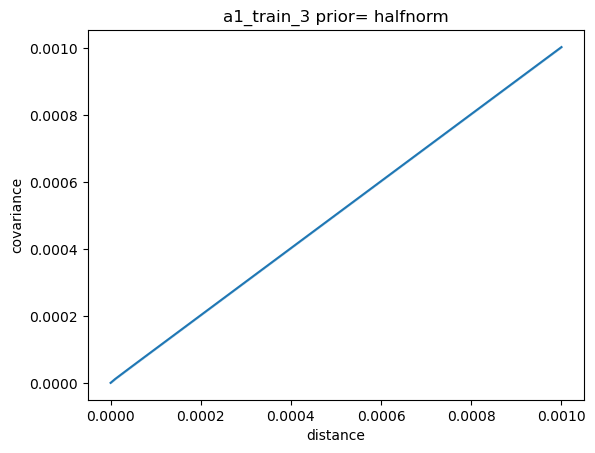

In [101]:
prior = 'halfnorm'
dist = torch.linspace(0,0.001,100)
state_dict_path = records_norm_3[40]['param']
state_dict = torch.load(state_dict_path)
model = GP_AFirst(inducing_points,nu=1, max_tries=200,prior=prior)
model.load_state_dict(state_dict)
kern = model.covar_module.base_kernel
lht_show_matern(kern, 'a1_train_3 prior= halfnorm', dist, prior=prior)

In [102]:
fp = opt.a1_train_3
df = pd.read_csv(fp)
points = df.to_numpy()
X = points[:,0:2]
Y = points[:,2]
tx = torch.from_numpy(X).float()
yy = torch.from_numpy(Y).float()
inducing_points = torch.load("model/ip500.pt")

state_dict_path = records_norm_3[40]['param']
state_dict = torch.load(state_dict_path)

model = GP_AFirst(inducing_points.cpu(),nu=1, max_tries=200, prior=prior)
model.load_state_dict(state_dict)
model.eval()
preds = model(tx)
means = preds.mean.cpu()
error = torch.mean(torch.abs(means - yy.cpu()))
l,v = preds.loc.cpu().detach().numpy(), preds.stddev.cpu().detach().numpy()
ci = norm.interval(0.95, loc=l, scale=v)
LB,UB = ci
a = np.logical_and(Y>=LB, Y<=UB)
acc = Y[a].shape[0] / len(Y)
df['LB'] = LB
df['UB'] = UB
print(f"num:{Y[a].shape[0]}, acc:{acc}, mae:{error.item()}")
df.head()

num:84967, acc:0.9440777777777778, mae:1.1363800764083862


s1        s2         z        LB        UB
0  0.634854  0.209266 -1.785809 -3.149053  3.058847
1  0.578312  0.101311 -3.332635 -3.039082  2.819753
2  0.844671  0.367299  0.875230 -3.251605  3.307930
3  0.345902  0.758828 -0.093856 -2.583996  2.394538
4  0.669697  0.577932  0.583697 -3.016253  3.106797

### Gamma Prior

In [68]:
#| hide
fp = opt.a1_train_3
df = pd.read_csv(fp)
nugget = 0.75
varogram_dist = 0.25
inducing_points = torch.load("model/ip500.pt")
folder = 'model/a1_train_3_gamma'
if not os.path.isdir(folder):
    os.mkdir(folder)
#
prior='gamma'
lr = 0.01
base_lr=0.0001
lr_step=100
device = torch.device("cpu")

model = lhtcore.GP_AFirst(inducing_points,nu=1, max_tries=200,prior=prior,nugget=nugget)
likelihood = gpytorch.likelihoods.GaussianLikelihood()  
model.to(device)
likelihood.to(device)
params = list(model.parameters()) + list(likelihood.parameters())
optimizer = torch.optim.Adam(params, lr = lr, weight_decay=0.01 )
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=lr_step, eta_min=base_lr)

points = df.to_numpy()
best_params = {'acc':0, 'mae':2, 'acc_mae':0}

In [69]:
#| hide
num_epochs = 10 # 1200
num_iter = tqdm.notebook.tqdm(range(0,num_epochs))
for epoch in num_iter:
    lhtutil.lht_train_one_epoch(model,optimizer,likelihood,points,device,lr_scheduler,batch_size=200)
    ret_test = lhtutil.lht_test(model,points,device,flag=True)
    acc, mae = ret_test['acc'], ret_test['mae']
    if acc > best_params['acc']:
        best_params['acc'] = acc
        param_fp = os.path.join(folder, f'best_acc.pth')
        torch.save(model.state_dict(), param_fp) 
    #
    if mae < best_params['mae']:
        best_params['mae'] = mae
        param_fp = os.path.join(folder, f'best_mae.pth')
        torch.save(model.state_dict(), param_fp)
    #
    acc_mae = acc / mae
    if acc_mae > best_params['acc_mae']:
        best_params['acc_mae'] = acc_mae
        param_fp = os.path.join(folder, f'best_acc_mae.pth')
        torch.save(model.state_dict(), param_fp)
        

  0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/450 [00:00<?, ?it/s]

test:   0%|          | 0/450 [00:00<?, ?it/s]

num:71084, acc:0.7898222222222222, mae:1.1461613178253174


Minibatch:   0%|          | 0/450 [00:00<?, ?it/s]

test:   0%|          | 0/450 [00:00<?, ?it/s]

num:70955, acc:0.7883888888888889, mae:1.1464056968688965


Minibatch:   0%|          | 0/450 [00:00<?, ?it/s]

test:   0%|          | 0/450 [00:00<?, ?it/s]

num:72137, acc:0.8015222222222222, mae:1.1462916135787964


Minibatch:   0%|          | 0/450 [00:00<?, ?it/s]

test:   0%|          | 0/450 [00:00<?, ?it/s]

num:76429, acc:0.8492111111111111, mae:1.1468654870986938


Minibatch:   0%|          | 0/450 [00:00<?, ?it/s]

test:   0%|          | 0/450 [00:00<?, ?it/s]

num:75906, acc:0.8434, mae:1.1469001770019531


Minibatch:   0%|          | 0/450 [00:00<?, ?it/s]

test:   0%|          | 0/450 [00:00<?, ?it/s]

num:73493, acc:0.8165888888888889, mae:1.1467483043670654


Minibatch:   0%|          | 0/450 [00:00<?, ?it/s]

test:   0%|          | 0/450 [00:00<?, ?it/s]

num:73583, acc:0.8175888888888889, mae:1.1461634635925293


Minibatch:   0%|          | 0/450 [00:00<?, ?it/s]

test:   0%|          | 0/450 [00:00<?, ?it/s]

num:70830, acc:0.787, mae:1.1519242525100708


Minibatch:   0%|          | 0/450 [00:00<?, ?it/s]

test:   0%|          | 0/450 [00:00<?, ?it/s]

num:70387, acc:0.7820777777777778, mae:1.145891547203064


Minibatch:   0%|          | 0/450 [00:00<?, ?it/s]

test:   0%|          | 0/450 [00:00<?, ?it/s]

num:73887, acc:0.8209666666666666, mae:1.1460741758346558


In [86]:
folder = 'model/a1_train_3_gamma'
nugget = 0.75
prior='gamma'
state_dict_path = os.path.join(folder,'best_acc_mae.pth')
state_dict = torch.load(state_dict_path)
model = lhtcore.GP_AFirst(inducing_points,nu=1, max_tries=200,prior=prior,nugget=nugget)
model.load_state_dict(state_dict)
kern = model.covar_module.base_kernel
ret_test = lhtutil.lht_test(model,points,device,flag=True)

test:   0%|          | 0/450 [00:00<?, ?it/s]

num:79270, acc:0.8807777777777778, mae:1.1078239679336548


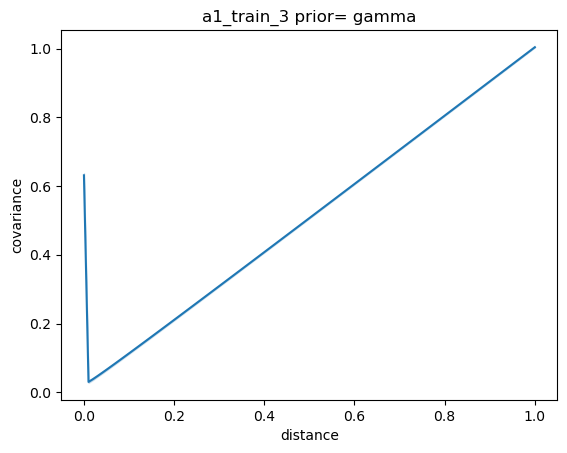

In [71]:
dist = torch.linspace(0,1,100)
lht_show_matern(kern, 'a1_train_3 prior= gamma', dist, prior=prior)

#### Gamma Prior-old

In [5]:
#| hide
fp = opt.a1_train_3
df = pd.read_csv(fp)
varogram_dist = 0.15
inducing_points = torch.load("model/ip500.pt")
folder = 'model/a1_train_3_gamma'
if not os.path.isdir(folder):
    os.mkdir(folder)
records_gamma = train_LhtMatern(df=df, varogram_dist=varogram_dist, inducing_points=inducing_points, prior='gamma',lr=0.001, folder=folder)

100%|████████████████████████████████████████████████████| 49/49 [00:00<00:00, 15034.45it/s]


         nu     sigma      beta    nugget
0  0.110730  0.857814  0.019339  0.079953
1  5.591796  9.686447  3.321640  4.074060


cross-validation:   0%|          | 0/49 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/421 [00:00<?, ?it/s]

test:   0%|          | 0/10 [00:00<?, ?it/s]

Test, MAE: 1.378507137298584 ,  ACC: 0.7660010240655402, train:84175, test:1953
         nu     sigma      beta    nugget
0  0.357165  0.497686  0.074720  0.029754
1  9.788509  6.844769  5.256178  2.888796


Minibatch:   0%|          | 0/413 [00:00<?, ?it/s]

test:   0%|          | 0/10 [00:00<?, ?it/s]

Test, MAE: 1.052281141281128 ,  ACC: 0.9360374414976599, train:82431, test:1923
          nu     sigma      beta    nugget
0   1.232316  0.317002  0.249057  0.010761
1  20.514879  5.307943  9.071321  2.204482


Minibatch:   0%|          | 0/412 [00:00<?, ?it/s]

test:   0%|          | 0/10 [00:00<?, ?it/s]

Test, MAE: 1.0229169130325317 ,  ACC: 0.9108179419525066, train:82323, test:1895
          nu     sigma       beta    nugget
0   2.137872  0.264741   0.431303  0.003526
1  29.788165  4.838620  12.198896  1.753592


Minibatch:   0%|          | 0/412 [00:00<?, ?it/s]

test:   0%|          | 0/10 [00:00<?, ?it/s]

Test, MAE: 1.138419270515442 ,  ACC: 0.8465938637545501, train:82365, test:1923
          nu     sigma       beta  nugget
0   2.302070  0.258774   0.466535  0.0010
1  31.387866  4.784171  12.762819  1.4335


Minibatch:   0%|          | 0/412 [00:00<?, ?it/s]

test:   0%|          | 0/10 [00:00<?, ?it/s]

Test, MAE: 0.9482941627502441 ,  ACC: 0.8727082242011525, train:82365, test:1909
          nu     sigma       beta    nugget
0   2.380228  0.256173   0.483553  0.000236
1  32.143326  4.760377  13.032038  1.194724


Minibatch:   0%|          | 0/413 [00:00<?, ?it/s]

test:   0%|          | 0/10 [00:00<?, ?it/s]

Test, MAE: 0.8053058385848999 ,  ACC: 0.9229567933368037, train:82590, test:1921
          nu     sigma       beta    nugget
0   2.431153  0.254556   0.494703  0.000044
1  32.633611  4.745568  13.207403  1.009478


Minibatch:   0%|          | 0/426 [00:00<?, ?it/s]

test:   0%|          | 0/8 [00:00<?, ?it/s]

Test, MAE: 0.8518739342689514 ,  ACC: 0.8149964961457603, train:85143, test:1427
          nu     sigma       beta    nugget
0   2.469935  0.253365   0.503219  0.000006
1  33.005984  4.734647  13.340784  0.857689


Minibatch:   0%|          | 0/412 [00:00<?, ?it/s]

test:   0%|          | 0/10 [00:00<?, ?it/s]

Test, MAE: 1.3014051914215088 ,  ACC: 0.8753206772703951, train:82371, test:1949
          nu     sigma       beta        nugget
0   2.500284  0.252455   0.509893  6.103566e-07
1  33.296794  4.726309  13.445019  7.379242e-01


Minibatch:   0%|          | 0/403 [00:00<?, ?it/s]

test:   0%|          | 0/9 [00:00<?, ?it/s]

Test, MAE: 1.02495276927948 ,  ACC: 0.9087875417130145, train:80497, test:1798
          nu     sigma       beta        nugget
0   2.525527  0.251715   0.515449  4.595096e-08
1  33.538274  4.719516  13.531577  6.401953e-01


Minibatch:   0%|          | 0/403 [00:00<?, ?it/s]

test:   0%|          | 0/10 [00:00<?, ?it/s]

Test, MAE: 1.5713943243026733 ,  ACC: 0.797004132231405, train:80533, test:1936
          nu     sigma       beta        nugget
0   2.547834  0.251073   0.520361  2.281558e-09
1  33.751384  4.713616  13.607944  5.573002e-01


Minibatch:   0%|          | 0/403 [00:00<?, ?it/s]

test:   0%|          | 0/10 [00:00<?, ?it/s]

Test, MAE: 1.187626838684082 ,  ACC: 0.8291404612159329, train:80455, test:1908
          nu     sigma       beta        nugget
0   2.568060  0.250499   0.524815  6.974721e-11
1  33.944407  4.708350  13.677081  4.860453e-01


Minibatch:   0%|          | 0/400 [00:00<?, ?it/s]

test:   0%|          | 0/10 [00:00<?, ?it/s]

Test, MAE: 1.3406673669815063 ,  ACC: 0.7013815090329437, train:79945, test:1882
          nu     sigma       beta        nugget
0   2.586507  0.249983   0.528877  1.254407e-12
1  34.120242  4.703612  13.740022  4.245733e-01


Minibatch:   0%|          | 0/402 [00:00<?, ?it/s]

test:   0%|          | 0/11 [00:00<?, ?it/s]

Test, MAE: 1.0904752016067505 ,  ACC: 0.8518346493265211, train:80349, test:2153
          nu     sigma       beta        nugget
0   2.603805  0.249507   0.532683  1.153398e-14
1  34.284964  4.699231  13.798910  3.703641e-01


Minibatch:   0%|          | 0/418 [00:00<?, ?it/s]

test:   0%|          | 0/8 [00:00<?, ?it/s]

Test, MAE: 0.9276720285415649 ,  ACC: 0.7408880053015242, train:83472, test:1509
          nu     sigma       beta        nugget
0   2.620826  0.249045   0.536428  3.917737e-17
1  34.446906  4.694980  13.856769  3.206580e-01


Minibatch:   0%|          | 0/412 [00:00<?, ?it/s]

test:   0%|          | 0/10 [00:00<?, ?it/s]

Test, MAE: 1.005160927772522 ,  ACC: 0.9808190772420944, train:82284, test:1929
          nu     sigma       beta        nugget
0   2.636860  0.248614   0.539951  5.516646e-20
1  34.599293  4.691019  13.911147  2.771637e-01


Minibatch:   0%|          | 0/403 [00:00<?, ?it/s]

test:   0%|          | 0/10 [00:00<?, ?it/s]

Test, MAE: 1.4316368103027344 ,  ACC: 0.8276225619399051, train:80504, test:1897
          nu     sigma       beta        nugget
0   2.652004  0.248212   0.543277  3.081434e-23
1  34.743052  4.687325  13.962391  2.392519e-01


Minibatch:   0%|          | 0/402 [00:00<?, ?it/s]

test:   0%|          | 0/10 [00:00<?, ?it/s]

Test, MAE: 0.8848596215248108 ,  ACC: 0.9746113989637306, train:80365, test:1930
          nu     sigma       beta        nugget
0   2.666720  0.247821   0.546514  5.171837e-27
1  34.882779  4.683747  14.012211  2.054508e-01


Minibatch:   0%|          | 0/400 [00:00<?, ?it/s]

test:   0%|          | 0/10 [00:00<?, ?it/s]

Test, MAE: 1.2346783876419067 ,  ACC: 0.8370253164556962, train:79866, test:1896
          nu     sigma       beta        nugget
0   2.681094  0.247454   0.549677  2.218317e-31
1  35.019166  4.680343  14.060834  1.753558e-01


Minibatch:   0%|          | 0/398 [00:00<?, ?it/s]

test:   0%|          | 0/12 [00:00<?, ?it/s]

Test, MAE: 1.0024352073669434 ,  ACC: 0.9182932364956877, train:79544, test:2203
          nu     sigma       beta        nugget
0   2.695188  0.247092   0.552771  1.990646e-36
1  35.152632  4.677008  14.108374  1.485765e-01


Minibatch:   0%|          | 0/399 [00:00<?, ?it/s]

test:   0%|          | 0/11 [00:00<?, ?it/s]

Test, MAE: 1.1328119039535522 ,  ACC: 0.8458371454711803, train:79728, test:2186
          nu     sigma       beta        nugget
0   2.709036  0.246733   0.555807  2.634102e-42
1  35.283641  4.673737  14.154953  1.246058e-01


Minibatch:   0%|          | 0/418 [00:00<?, ?it/s]

test:   0%|          | 0/8 [00:00<?, ?it/s]

Test, MAE: 0.7676134705543518 ,  ACC: 0.9242529534398888, train:83402, test:1439
          nu     sigma       beta        nugget
0   2.723205  0.246383   0.558918  1.709219e-49
1  35.417770  4.670483  14.202616  1.023265e-01


Minibatch:   0%|          | 0/412 [00:00<?, ?it/s]

test:   0%|          | 0/10 [00:00<?, ?it/s]

Test, MAE: 1.039602518081665 ,  ACC: 0.9829984544049459, train:82274, test:1941
          nu     sigma       beta        nugget
0   2.736869  0.246043   0.561909  8.342515e-58
1  35.547030  4.667355  14.248414  8.296547e-02


Minibatch:   0%|          | 0/402 [00:00<?, ?it/s]

test:   0%|          | 0/10 [00:00<?, ?it/s]

Test, MAE: 1.3162493705749512 ,  ACC: 0.8970133882595263, train:80299, test:1942
          nu     sigma       beta        nugget
0   2.749971  0.245715   0.564770  2.828508e-67
1  35.670620  4.664362  14.292166  6.645310e-02


Minibatch:   0%|          | 0/400 [00:00<?, ?it/s]

test:   0%|          | 0/10 [00:00<?, ?it/s]

Test, MAE: 1.0012719631195068 ,  ACC: 0.9772267206477733, train:79854, test:1976
          nu     sigma       beta        nugget
0   2.762759  0.245405   0.567567  3.024508e-78
1  35.791532  4.661490  14.334899  5.223801e-02


Minibatch:   0%|          | 0/397 [00:00<?, ?it/s]

test:   0%|          | 0/11 [00:00<?, ?it/s]

Test, MAE: 1.448265790939331 ,  ACC: 0.7942649066909422, train:79362, test:2197
          nu     sigma       beta        nugget
0   2.775378  0.245109   0.570303  6.581543e-91
1  35.910295  4.658737  14.376678  4.019920e-02


Minibatch:   0%|          | 0/395 [00:00<?, ?it/s]

test:   0%|          | 0/12 [00:00<?, ?it/s]

Test, MAE: 1.2564830780029297 ,  ACC: 0.8719965050240279, train:78828, test:2289
          nu     sigma       beta         nugget
0   2.787685  0.244816   0.572998  1.513016e-105
1  36.026665  4.656033  14.417748   3.014996e-02


Minibatch:   0%|          | 0/399 [00:00<?, ?it/s]

test:   0%|          | 0/12 [00:00<?, ?it/s]

Test, MAE: 1.3912678956985474 ,  ACC: 0.6647752073330423, train:79743, test:2291
          nu     sigma       beta         nugget
0   2.800083  0.244523   0.575685  9.921708e-123
1  36.143494  4.653331  14.458703   2.182967e-02


Minibatch:   0%|          | 0/418 [00:00<?, ?it/s]

test:   0%|          | 0/8 [00:00<?, ?it/s]

Test, MAE: 1.364450454711914 ,  ACC: 0.7049180327868853, train:83517, test:1464
          nu     sigma       beta         nugget
0   2.813030  0.244217   0.578479  8.729667e-144
1  36.265058  4.650531  14.501235   1.491969e-02


Minibatch:   0%|          | 0/412 [00:00<?, ?it/s]

test:   0%|          | 0/10 [00:00<?, ?it/s]

Test, MAE: 0.9139366149902344 ,  ACC: 0.9796238244514106, train:82274, test:1914
          nu     sigma       beta         nugget
0   2.825636  0.243918   0.581215  3.673403e-168
1  36.383865  4.647809  14.542863   9.739349e-03


Minibatch:   0%|          | 0/400 [00:00<?, ?it/s]

test:   0%|          | 0/10 [00:00<?, ?it/s]

Test, MAE: 1.2710089683532715 ,  ACC: 0.8884318766066838, train:79913, test:1945
          nu     sigma       beta         nugget
0   2.837813  0.243628   0.583860  8.404287e-196
1  36.498642  4.645169  14.583019   6.077745e-03


Minibatch:   0%|          | 0/398 [00:00<?, ?it/s]

test:   0%|          | 0/11 [00:00<?, ?it/s]

Test, MAE: 0.9642497301101685 ,  ACC: 0.9933365064255116, train:79442, test:2101
          nu     sigma       beta         nugget
0   2.849916  0.243363   0.586468  7.776725e-228
1  36.612424  4.642690  14.622657   3.555698e-03


Minibatch:   0%|          | 0/395 [00:00<?, ?it/s]

test:   0%|          | 0/12 [00:00<?, ?it/s]

Test, MAE: 0.9776521325111389 ,  ACC: 0.9543859649122807, train:78948, test:2280
          nu     sigma       beta         nugget
0   2.861914  0.243103   0.589056  8.230476e-265
1  36.724925  4.640258  14.661830   1.931963e-03


Minibatch:   0%|          | 0/396 [00:00<?, ?it/s]

test:   0%|          | 0/11 [00:00<?, ?it/s]

Test, MAE: 1.0281058549880981 ,  ACC: 0.9557481751824818, train:79089, test:2192
          nu     sigma       beta         nugget
0   2.873953  0.242842   0.591619  6.290946e-308
1  36.837582  4.637822  14.700754   9.555309e-04


Minibatch:   0%|          | 0/402 [00:00<?, ?it/s]

test:   0%|          | 0/11 [00:00<?, ?it/s]

Test, MAE: 1.2098968029022217 ,  ACC: 0.9240256536753824, train:80299, test:2027
          nu     sigma       beta    nugget
0   2.885953  0.242578   0.594218  0.000000
1  36.950486  4.635371  14.740077  0.000418


Minibatch:   0%|          | 0/420 [00:00<?, ?it/s]

test:   0%|          | 0/7 [00:00<?, ?it/s]

Test, MAE: 0.7121347188949585 ,  ACC: 0.9658650116369278, train:83931, test:1289
          nu     sigma       beta    nugget
0   2.898525  0.242306   0.596937  0.000000
1  37.068763  4.632856  14.781134  0.000153


Minibatch:   0%|          | 0/410 [00:00<?, ?it/s]

test:   0%|          | 0/10 [00:00<?, ?it/s]

Test, MAE: 1.4896366596221924 ,  ACC: 0.7492211838006231, train:81977, test:1926
          nu     sigma       beta    nugget
0   2.910847  0.242040   0.599577  0.000000
1  37.184605  4.630401  14.821049  0.000048


Minibatch:   0%|          | 0/400 [00:00<?, ?it/s]

test:   0%|          | 0/11 [00:00<?, ?it/s]

Test, MAE: 2.0202720165252686 ,  ACC: 0.5757437070938215, train:79966, test:2185
          nu     sigma       beta    nugget
0   2.922812  0.241780   0.602138  0.000000
1  37.296652  4.628008  14.859771  0.000013


Minibatch:   0%|          | 0/399 [00:00<?, ?it/s]

test:   0%|          | 0/12 [00:00<?, ?it/s]

Test, MAE: 1.6843959093093872 ,  ACC: 0.7061170212765957, train:79769, test:2256
          nu     sigma       beta    nugget
0   2.934771  0.241523   0.604697  0.000000
1  37.408477  4.625636  14.898362  0.000003


Minibatch:   0%|          | 0/400 [00:00<?, ?it/s]

test:   0%|          | 0/12 [00:00<?, ?it/s]

Test, MAE: 0.8024026155471802 ,  ACC: 0.9978089395267309, train:79968, test:2282
          nu     sigma       beta        nugget
0   2.946807  0.241267   0.607255  0.000000e+00
1  37.520932  4.623308  14.936895  4.879312e-07


Minibatch:   0%|          | 0/404 [00:00<?, ?it/s]

test:   0%|          | 0/11 [00:00<?, ?it/s]

Test, MAE: 0.9701591730117798 ,  ACC: 0.9722091380122468, train:80615, test:2123
          nu     sigma       beta        nugget
0   2.958900  0.241009   0.609811  0.000000e+00
1  37.633465  4.620957  14.975479  6.068002e-08


Minibatch:   0%|          | 0/409 [00:00<?, ?it/s]

test:   0%|          | 0/10 [00:00<?, ?it/s]

Test, MAE: 1.0025391578674316 ,  ACC: 0.9190325972660357, train:81711, test:1902
          nu     sigma       beta        nugget
0   2.971045  0.240748   0.612402  0.000000e+00
1  37.747010  4.618578  15.014464  5.161870e-09


Minibatch:   0%|          | 0/425 [00:00<?, ?it/s]

test:   0%|          | 0/7 [00:00<?, ?it/s]

Test, MAE: 1.1652008295059204 ,  ACC: 0.843289371605896, train:84949, test:1289
         nu     sigma       beta        nugget
0   2.98363  0.240477   0.615099  0.000000e+00
1  37.86504  4.616109  15.054964  2.543479e-10


Minibatch:   0%|          | 0/422 [00:00<?, ?it/s]

test:   0%|          | 0/10 [00:00<?, ?it/s]

Test, MAE: 1.0538439750671387 ,  ACC: 0.998998998998999, train:84354, test:1998
          nu     sigma       beta        nugget
0   2.996176  0.240227   0.617779  0.000000e+00
1  37.982616  4.613782  15.095175  7.503906e-12


Minibatch:   0%|          | 0/414 [00:00<?, ?it/s]

test:   0%|          | 0/9 [00:00<?, ?it/s]

Test, MAE: 0.8864188194274902 ,  ACC: 0.9941927990708479, train:82688, test:1722
          nu     sigma       beta        nugget
0   3.008482  0.239990   0.620380  0.000000e+00
1  38.097680  4.611558  15.134336  1.296399e-13


Minibatch:   0%|          | 0/418 [00:00<?, ?it/s]

test:   0%|          | 0/8 [00:00<?, ?it/s]

Test, MAE: 1.4110549688339233 ,  ACC: 0.8805970149253731, train:83524, test:1407
          nu     sigma       beta        nugget
0   3.020870  0.239751   0.623006  0.000000e+00
1  38.213144  4.609315  15.173767  1.055142e-15


Minibatch:   0%|          | 0/422 [00:00<?, ?it/s]

test:   0%|          | 0/6 [00:00<?, ?it/s]

Test, MAE: 1.1062771081924438 ,  ACC: 0.84967919340055, train:84334, test:1091
          nu     sigma       beta        nugget
0   3.033426  0.239510   0.625665  0.000000e+00
1  38.330080  4.607051  15.213588  3.484713e-18


Minibatch:   0%|          | 0/425 [00:00<?, ?it/s]

test:   0%|          | 0/5 [00:00<?, ?it/s]

Test, MAE: 1.8682410717010498 ,  ACC: 0.6241534988713319, train:84952, test:886
          nu     sigma       beta        nugget
0   3.046120  0.239268   0.628327  0.000000e+00
1  38.448221  4.604782  15.253418  3.977246e-21


Minibatch:   0%|          | 0/429 [00:00<?, ?it/s]

test:   0%|          | 0/5 [00:00<?, ?it/s]

Test, MAE: 0.964379608631134 ,  ACC: 0.8143459915611815, train:85693, test:948
          nu     sigma       beta        nugget
0   3.058879  0.239027   0.630993  0.000000e+00
1  38.566519  4.602549  15.293412  1.242394e-24


Minibatch:   0%|          | 0/436 [00:00<?, ?it/s]

test:   0%|          | 0/3 [00:00<?, ?it/s]

Test, MAE: 1.0881553888320923 ,  ACC: 0.7635726795096323, train:87192, test:571
          nu     sigma       beta        nugget
0   3.071861  0.238782   0.633706  0.000000e+00
1  38.686660  4.600282  15.334019  7.574548e-29


In [6]:
ret = test_records(df, inducing_points, records_gamma, model_type='lht', prior='gamma', cuda=False, mae_threshold=3)

verify:   0%|          | 0/49 [00:00<?, ?it/s]

0: mae: 1.378507137298584, acc: 0.7660010240655402
num:79724, acc:0.8858222222222222, mae:1.1457798480987549
1: mae: 1.052281141281128, acc: 0.9360374414976599
num:76936, acc:0.8548444444444444, mae:1.1541500091552734
2: mae: 1.0229169130325317, acc: 0.9108179419525066
num:80085, acc:0.8898333333333334, mae:1.1459994316101074
3: mae: 1.138419270515442, acc: 0.8465938637545501
num:79176, acc:0.8797333333333334, mae:1.1455644369125366
4: mae: 0.9482941627502441, acc: 0.8727082242011525
num:78495, acc:0.8721666666666666, mae:1.1456745862960815
5: mae: 0.8053058385848999, acc: 0.9229567933368037
num:79795, acc:0.8866111111111111, mae:1.1474909782409668
6: mae: 0.8518739342689514, acc: 0.8149964961457603
num:75579, acc:0.8397666666666667, mae:1.1458181142807007
7: mae: 1.3014051914215088, acc: 0.8753206772703951
num:79894, acc:0.8877111111111111, mae:1.145763874053955
8: mae: 1.02495276927948, acc: 0.9087875417130145
num:77596, acc:0.8621777777777778, mae:1.1460998058319092
9: mae: 1.571394

In [7]:
mae = ret['mae']
acc = ret['acc']
mae = np.array(mae)
acc = np.array(acc)
am = acc/mae
idx = am.argmax()
print(f"ids:{idx}, mae:{mae[idx]}, acc:{acc[idx]}")

ids:39, mae:1.1367924213409424, acc:0.9066


In [8]:
fp = opt.a1_train_3
df = pd.read_csv(fp)
points = df.to_numpy()
X = points[:,0:2]
Y = points[:,2]
tx = torch.from_numpy(X).float()
yy = torch.from_numpy(Y).float()
inducing_points = torch.load("model/ip500.pt")

state_dict_path = records_gamma[39]['param']
state_dict = torch.load(state_dict_path)

model = GP_AFirst(inducing_points.cpu(),nu=1, max_tries=200, prior='gamma')
model.load_state_dict(state_dict)
model.eval()
preds = model(tx)
means = preds.mean.cpu()
error = torch.mean(torch.abs(means - yy.cpu()))
l,v = preds.loc.cpu().detach().numpy(), preds.stddev.cpu().detach().numpy()
ci = norm.interval(0.95, loc=l, scale=v)
LB,UB = ci
a = np.logical_and(Y>=LB, Y<=UB)
acc = Y[a].shape[0] / len(Y)
df['LB'] = LB
df['UB'] = UB
print(f"num:{Y[a].shape[0]}, acc:{acc}, mae:{error.item()}")
df.head()

num:81594, acc:0.9066, mae:1.1367924213409424


s1        s2         z        LB        UB
0  0.634854  0.209266 -1.785809 -2.746596  2.507237
1  0.578312  0.101311 -3.332635 -2.503644  2.214301
2  0.844671  0.367299  0.875230 -2.823195  2.607171
3  0.345902  0.758828 -0.093856 -2.575467  2.060297
4  0.669697  0.577932  0.583697 -2.755207  2.496907

In [9]:
idx=39
fp=f"model/a1_train_3_scv"
fp_ = f"{fp}_mae_acc.pth"
state_dict_path = records_gamma[idx]['param']
state_dict = torch.load(state_dict_path)
torch.save(state_dict, fp_)

# a1_train_4

In [38]:
#| hide
fp = opt.a1_train_4
df = pd.read_csv(fp)

Text(0.5, 1.0, 'a1_train_4')

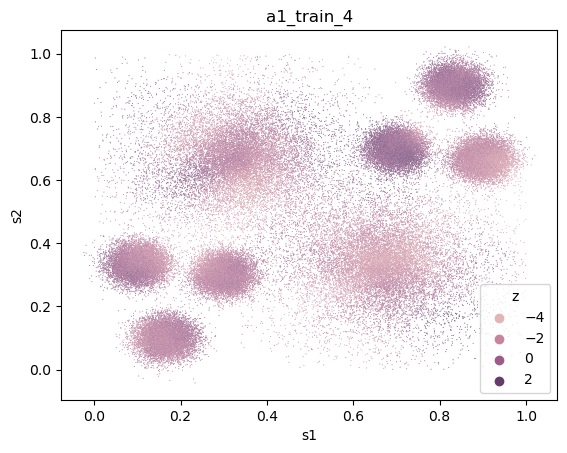

In [39]:
ax = sns.scatterplot(data=df, x='s1', y='s2', hue='z', s=0.5)
ax.set_title("a1_train_4")

<AxesSubplot:xlabel='z', ylabel='Density'>

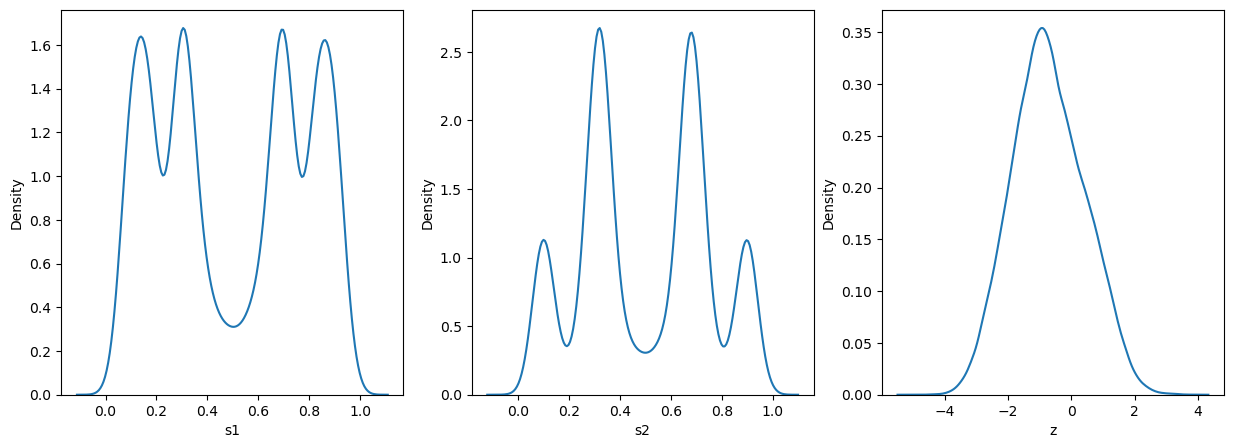

In [40]:
fig,axes = plt.subplots(1,3, figsize=(15,5))
sns.kdeplot(data=df, x='s1', ax=axes[0])
sns.kdeplot(data=df, x='s2', ax=axes[1])
sns.kdeplot(data=df, x='z', ax=axes[2])

## Spatial Cross Validation

### HalfNorm Prior

In [178]:
#| hide
fp = opt.a1_train_4
df = pd.read_csv(fp)
points = df.to_numpy()
nugget = 0.3
varogram_dist = 0.3
inducing_points = torch.load("model/ip500.pt")
folder = 'model/a1_train_4_norm'
if not os.path.isdir(folder):
    os.mkdir(folder)
#
prior='halfnorm'
lr = 0.01
base_lr=0.0001
lr_step=100
device = torch.device("cpu")

best_params = {'acc':0, 'mae':2, 'acc_mae':0}

In [71]:
model = lhtcore.GP_AFirst(inducing_points,nu=1, max_tries=200,prior=prior,nugget=nugget)
likelihood = gpytorch.likelihoods.GaussianLikelihood()  
model.to(device)
likelihood.to(device)
params = list(model.parameters()) + list(likelihood.parameters())
optimizer = torch.optim.Adam(params, lr = lr, weight_decay=0.01 )
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=lr_step, eta_min=base_lr)

In [182]:
#| hide
lr=0.001
num_epochs = 5 # 1200
num_iter = tqdm.notebook.tqdm(range(0,num_epochs))
for epoch in num_iter:
    model = lhtcore.GP_AFirst(inducing_points,nu=1, max_tries=200,prior=prior,nugget=nugget)
    likelihood = gpytorch.likelihoods.GaussianLikelihood()  
    mll = gpytorch.mlls.PredictiveLogLikelihood(likelihood, model, num_data=len(points))
    model.to(device)
    likelihood.to(device)
    params = list(model.parameters()) + list(likelihood.parameters())
    optimizer = torch.optim.Adam(params, lr = lr, weight_decay=0.01 )
    lhtutil.lht_train_one_epoch(model,optimizer,likelihood,mll,points,device,lr_scheduler=None,batch_size=200)
    
    ret_test = lhtutil.lht_test(model,points,device,flag=True)
    acc, mae = ret_test['acc'], ret_test['mae']
    if acc > best_params['acc']:
        best_params['acc'] = acc
        param_fp = os.path.join(folder, f'best_acc.pth')
        torch.save(model.state_dict(), param_fp) 
    #
    if mae < best_params['mae']:
        best_params['mae'] = mae
        param_fp = os.path.join(folder, f'best_mae.pth')
        torch.save(model.state_dict(), param_fp)
    #
    acc_mae = acc / mae
    if acc_mae > best_params['acc_mae']:
        best_params['acc_mae'] = acc_mae
        param_fp = os.path.join(folder, f'best_acc_mae.pth')
        torch.save(model.state_dict(), param_fp)
        

  0%|          | 0/5 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/450 [00:00<?, ?it/s]

test:   0%|          | 0/450 [00:00<?, ?it/s]

num:58710, acc:0.6523333333333333, mae:0.8929687738418579


Minibatch:   0%|          | 0/450 [00:00<?, ?it/s]

test:   0%|          | 0/450 [00:00<?, ?it/s]

num:89308, acc:0.9923111111111111, mae:0.6693899035453796


Minibatch:   0%|          | 0/450 [00:00<?, ?it/s]

test:   0%|          | 0/450 [00:00<?, ?it/s]

num:55829, acc:0.6203222222222222, mae:0.8878609538078308


Minibatch:   0%|          | 0/450 [00:00<?, ?it/s]

test:   0%|          | 0/450 [00:00<?, ?it/s]

num:89830, acc:0.9981111111111111, mae:0.9234703183174133


Minibatch:   0%|          | 0/450 [00:00<?, ?it/s]

test:   0%|          | 0/450 [00:00<?, ?it/s]

num:89986, acc:0.9998444444444444, mae:0.9390217065811157


In [202]:
folder = 'model/a1_train_4_norm'
nugget = 0.3
prior='halfnorm'
state_dict_path = os.path.join(folder,'best_mae.pth')
state_dict = torch.load(state_dict_path)
model = lhtcore.GP_AFirst(inducing_points,nu=1, max_tries=200,prior=prior,nugget=nugget)
model.load_state_dict(state_dict)
kern = model.covar_module.base_kernel

In [203]:
ret_test = lhtutil.lht_test(model,points,device,flag=True)

test:   0%|          | 0/450 [00:00<?, ?it/s]

num:89308, acc:0.9923111111111111, mae:0.6693899035453796


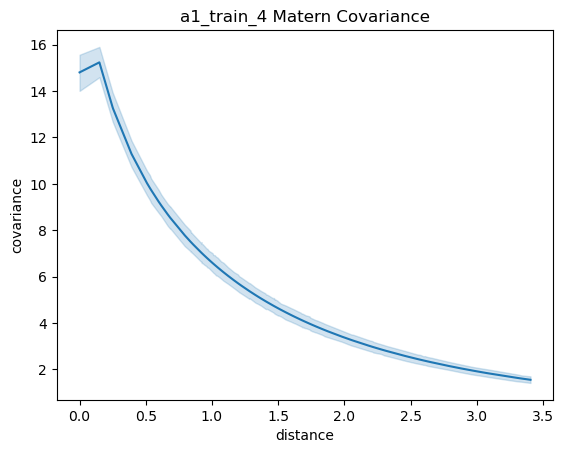

In [204]:
a = torch.randn(100,2)
a = a - a[0]
b = torch.linalg.norm(a,dim=1)
lht_show_matern(kern, 'a1_train_4 Matern Covariance', b, prior=prior)

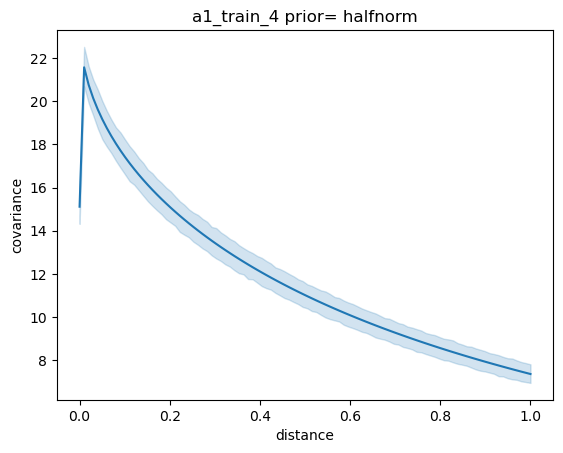

In [185]:
dist = torch.linspace(0,1,100)
lht_show_matern(kern, 'a1_train_4 prior= halfnorm', dist, prior=prior)

In [186]:
lhtutil.showCI_NSBN(model)

nu      sigma      beta    nugget
0  0.019953   0.157213  0.040637  0.318266
1  1.427098  11.244395  2.906499  1.606441

#### HalfNorm Prior-old

In [104]:
#| hide
fp = opt.a1_train_4
df = pd.read_csv(fp)
varogram_dist = 0.3
inducing_points = torch.load("model/ip500.pt")
folder = 'model/a1_train_4_norm'
if not os.path.isdir(folder):
    os.mkdir(folder)
records_gamma = train_LhtMatern(df=df, varogram_dist=varogram_dist, inducing_points=inducing_points, prior='halfnorm',lr=0.001, folder=folder)

100%|█████████████████████████████████████████████████████| 16/16 [00:00<00:00, 6765.01it/s]


         nu     sigma      beta    nugget
0  0.049927  0.071095  0.049041  0.038515
1  3.570963  5.084954  3.507588  2.754714


cross-validation:   0%|          | 0/16 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/327 [00:00<?, ?it/s]

test:   0%|          | 0/53 [00:00<?, ?it/s]

Test, MAE: 0.7757078409194946 ,  ACC: 0.001244019138755981, train:65374, test:10450
         nu     sigma      beta    nugget
0  0.059117  0.062079  0.057358  0.031772
1  4.228268  4.440133  4.102456  2.272427


Minibatch:   0%|          | 0/268 [00:00<?, ?it/s]

test:   0%|          | 0/64 [00:00<?, ?it/s]

Test, MAE: 0.7343734502792358 ,  ACC: 0.7139045825486503, train:53536, test:12744
         nu     sigma      beta    nugget
0  0.067593  0.055164  0.064256  0.027005
1  4.834524  3.945504  4.595798  1.931477


Minibatch:   0%|          | 0/326 [00:00<?, ?it/s]

test:   0%|          | 0/16 [00:00<?, ?it/s]

Test, MAE: 0.9528703689575195 ,  ACC: 0.5332258064516129, train:65025, test:3100
         nu     sigma      beta    nugget
0  0.078180  0.047566  0.072398  0.022146
1  5.591684  3.402109  5.178130  1.583995


Minibatch:   0%|          | 0/432 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Test, MAE: 1.4182339906692505 ,  ACC: 0.4835164835164835, train:86367, test:182
         nu     sigma      beta    nugget
0  0.091325  0.039101  0.082262  0.017046
1  6.531856  2.796627  5.883697  1.219188


Minibatch:   0%|          | 0/329 [00:00<?, ?it/s]

test:   0%|          | 0/8 [00:00<?, ?it/s]

Test, MAE: 0.7930382490158081 ,  ACC: 0.9217877094972067, train:65619, test:1432
         nu     sigma      beta    nugget
0  0.100262  0.033817  0.088943  0.013983
1  7.171084  2.418700  6.361506  1.000088


Minibatch:   0%|          | 0/238 [00:00<?, ?it/s]

test:   0%|          | 0/51 [00:00<?, ?it/s]

Test, MAE: 0.6466028690338135 ,  ACC: 0.755850540806293, train:47439, test:10170
         nu     sigma      beta    nugget
0  0.106174  0.030538  0.093348  0.012143
1  7.593946  2.184203  6.676594  0.868502


Minibatch:   0%|          | 0/269 [00:00<?, ?it/s]

test:   0%|          | 0/45 [00:00<?, ?it/s]

Test, MAE: 0.8997223973274231 ,  ACC: 0.6585093306514694, train:53709, test:8949
         nu     sigma      beta    nugget
0  0.112422  0.027297  0.097953  0.010404
1  8.040851  1.952370  7.005908  0.744097


Minibatch:   0%|          | 0/362 [00:00<?, ?it/s]

test:   0%|          | 0/2 [00:00<?, ?it/s]

Test, MAE: 0.9559570550918579 ,  ACC: 0.9259259259259259, train:72254, test:351
         nu     sigma      beta    nugget
0  0.120106  0.023602  0.103589  0.008497
1  8.590428  1.688089  7.409061  0.607762


Minibatch:   0%|          | 0/385 [00:00<?, ?it/s]

test:   0%|          | 0/12 [00:00<?, ?it/s]

Test, MAE: 0.986701488494873 ,  ACC: 0.9029626449119794, train:76841, test:2329
         nu     sigma      beta    nugget
0  0.127456  0.020362  0.108982  0.006889
1  9.116091  1.456348  7.794806  0.492730


Minibatch:   0%|          | 0/271 [00:00<?, ?it/s]

test:   0%|          | 0/47 [00:00<?, ?it/s]

Test, MAE: 1.3198578357696533 ,  ACC: 0.9766889704295273, train:54184, test:9266
         nu     sigma      beta    nugget
0  0.132224  0.018425  0.112471  0.005968
1  9.457155  1.317844  8.044333  0.426848


Minibatch:   0%|          | 0/211 [00:00<?, ?it/s]

test:   0%|          | 0/69 [00:00<?, ?it/s]

Test, MAE: 1.2007331848144531 ,  ACC: 0.9280664674586401, train:42146, test:13721
         nu     sigma      beta    nugget
0  0.135775  0.017080  0.115042  0.005357
1  9.711100  1.221627  8.228215  0.383176


Minibatch:   0%|          | 0/334 [00:00<?, ?it/s]

test:   0%|          | 0/42 [00:00<?, ?it/s]

Test, MAE: 0.782769501209259 ,  ACC: 0.9399806389157793, train:66738, test:8264
          nu     sigma      beta    nugget
0   0.141051  0.015203  0.118876  0.004523
1  10.088465  1.087408  8.502465  0.323503


Minibatch:   0%|          | 0/437 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Test, MAE: 2.3654062747955322 ,  ACC: 0.6515151515151515, train:87209, test:132
          nu     sigma      beta    nugget
0   0.147433  0.013134  0.123529  0.003638
1  10.544919  0.939384  8.835204  0.260169


Minibatch:   0%|          | 0/364 [00:00<?, ?it/s]

test:   0%|          | 0/2 [00:00<?, ?it/s]

Test, MAE: 1.191257119178772 ,  ACC: 0.9242424242424242, train:72618, test:330
          nu     sigma      beta    nugget
0   0.152412  0.011679  0.127146  0.003050
1  10.901046  0.835324  9.093900  0.218124


Minibatch:   0%|          | 0/337 [00:00<?, ?it/s]

test:   0%|          | 0/39 [00:00<?, ?it/s]

Test, MAE: 1.2926172018051147 ,  ACC: 0.8909067154429057, train:67369, test:7654
          nu     sigma      beta    nugget
0   0.156803  0.010509  0.130324  0.002600
1  11.215080  0.751632  9.321200  0.185989


Minibatch:   0%|          | 0/366 [00:00<?, ?it/s]

test:   0%|          | 0/5 [00:00<?, ?it/s]

Test, MAE: 1.1131043434143066 ,  ACC: 0.7289416846652268, train:73156, test:926
          nu     sigma      beta    nugget
0   0.161362  0.009398  0.133619  0.002193
1  11.541167  0.672202  9.556934  0.156861


In [105]:
ret = test_records(df, inducing_points, records_gamma, model_type='lht', prior='halfnorm', cuda=False, mae_threshold=3)

verify:   0%|          | 0/16 [00:00<?, ?it/s]

0: mae: 0.7757078409194946, acc: 0.001244019138755981
num:42479, acc:0.4719888888888889, mae:0.9023576974868774
1: mae: 0.7343734502792358, acc: 0.7139045825486503
num:76843, acc:0.8538111111111111, mae:0.9320546984672546
2: mae: 0.9528703689575195, acc: 0.5332258064516129
num:51636, acc:0.5737333333333333, mae:0.915112316608429
3: mae: 1.4182339906692505, acc: 0.4835164835164835
num:56854, acc:0.6317111111111111, mae:0.9099704623222351
4: mae: 0.7930382490158081, acc: 0.9217877094972067
num:74936, acc:0.8326222222222223, mae:0.9119332432746887
5: mae: 0.6466028690338135, acc: 0.755850540806293
num:61414, acc:0.6823777777777777, mae:0.9152439832687378
6: mae: 0.8997223973274231, acc: 0.6585093306514694
num:49542, acc:0.5504666666666667, mae:0.9182078838348389
7: mae: 0.9559570550918579, acc: 0.9259259259259259
num:61036, acc:0.6781777777777778, mae:0.92124342918396
8: mae: 0.986701488494873, acc: 0.9029626449119794
num:62266, acc:0.6918444444444445, mae:0.9242500066757202
9: mae: 1.319

In [106]:
mae = ret['mae']
acc = ret['acc']
mae = np.array(mae)
acc = np.array(acc)
am = acc/mae
idx = am.argmax()
print(f"ids:{idx}, mae:{mae[idx]}, acc:{acc[idx]}")

ids:1, mae:0.9320546984672546, acc:0.8538111111111111


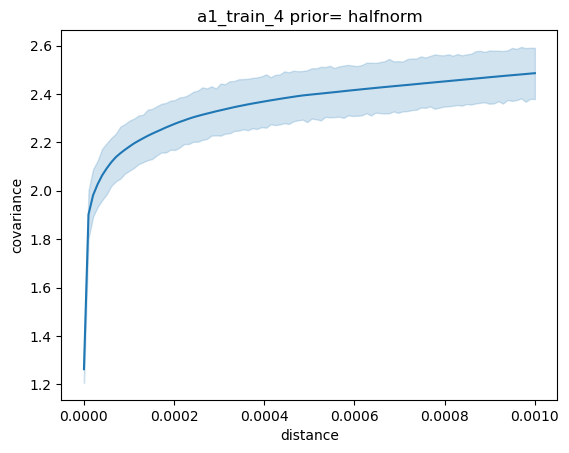

In [107]:
prior = 'halfnorm'
dist = torch.linspace(0,0.001,100)
state_dict_path = records_gamma[1]['param']
state_dict = torch.load(state_dict_path)
model = GP_AFirst(inducing_points,nu=1, max_tries=200,prior=prior)
model.load_state_dict(state_dict)
kern = model.covar_module.base_kernel
lht_show_matern(kern, 'a1_train_4 prior= halfnorm', dist, prior=prior)

In [108]:
fp = opt.a1_train_4
df = pd.read_csv(fp)
points = df.to_numpy()
X = points[:,0:2]
Y = points[:,2]
tx = torch.from_numpy(X).float()
yy = torch.from_numpy(Y).float()
inducing_points = torch.load("model/ip500.pt")

state_dict_path = records_gamma[1]['param']
state_dict = torch.load(state_dict_path)

model = GP_AFirst(inducing_points.cpu(),nu=1, max_tries=200, prior=prior)
model.load_state_dict(state_dict)
model.eval()
preds = model(tx)
means = preds.mean.cpu()
error = torch.mean(torch.abs(means - yy.cpu()))
l,v = preds.loc.cpu().detach().numpy(), preds.stddev.cpu().detach().numpy()
ci = norm.interval(0.95, loc=l, scale=v)
LB,UB = ci
a = np.logical_and(Y>=LB, Y<=UB)
acc = Y[a].shape[0] / len(Y)
df['LB'] = LB
df['UB'] = UB
print(f"num:{Y[a].shape[0]}, acc:{acc}, mae:{error.item()}")
df.head()

num:76843, acc:0.8538111111111111, mae:0.9320546984672546


s1        s2         z        LB        UB
0  0.244728  0.290552 -1.692733 -2.162481  0.113023
1  0.698403  0.369927 -3.135199 -3.076398  1.010859
2  0.374877  0.354492  0.178706 -2.442231  0.413273
3  0.163774  0.129513 -0.454076 -1.958999 -0.175470
4  0.094686  0.323892  0.023852 -1.938702 -0.075944

### Gamma Prior

In [92]:
#| hide
fp = opt.a1_train_4
df = pd.read_csv(fp)
nugget = 0.3
varogram_dist = 0.3
inducing_points = torch.load("model/ip500.pt")
folder = 'model/a1_train_4_gamma'
if not os.path.isdir(folder):
    os.mkdir(folder)
#
prior='gamma'
lr = 0.01
base_lr=0.0001
lr_step=100
device = torch.device("cpu")

model = lhtcore.GP_AFirst(inducing_points,nu=1, max_tries=200,prior=prior,nugget=nugget)
likelihood = gpytorch.likelihoods.GaussianLikelihood()  
model.to(device)
likelihood.to(device)
params = list(model.parameters()) + list(likelihood.parameters())
optimizer = torch.optim.Adam(params, lr = lr, weight_decay=0.01 )
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=lr_step, eta_min=base_lr)

points = df.to_numpy()
best_params = {'acc':0, 'mae':2, 'acc_mae':0}

In [93]:
#| hide
num_epochs = 10 # 1200
num_iter = tqdm.notebook.tqdm(range(0,num_epochs))
for epoch in num_iter:
    lhtutil.lht_train_one_epoch(model,optimizer,likelihood,points,device,lr_scheduler,batch_size=200)
    ret_test = lhtutil.lht_test(model,points,device,flag=True)
    acc, mae = ret_test['acc'], ret_test['mae']
    if acc > best_params['acc']:
        best_params['acc'] = acc
        param_fp = os.path.join(folder, f'best_acc.pth')
        torch.save(model.state_dict(), param_fp) 
    #
    if mae < best_params['mae']:
        best_params['mae'] = mae
        param_fp = os.path.join(folder, f'best_mae.pth')
        torch.save(model.state_dict(), param_fp)
    #
    acc_mae = acc / mae
    if acc_mae > best_params['acc_mae']:
        best_params['acc_mae'] = acc_mae
        param_fp = os.path.join(folder, f'best_acc_mae.pth')
        torch.save(model.state_dict(), param_fp)
        

  0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/450 [00:00<?, ?it/s]

test:   0%|          | 0/450 [00:00<?, ?it/s]

num:65412, acc:0.7268, mae:0.9030441045761108


Minibatch:   0%|          | 0/450 [00:00<?, ?it/s]

test:   0%|          | 0/450 [00:00<?, ?it/s]

num:68678, acc:0.7630888888888889, mae:0.8942081332206726


Minibatch:   0%|          | 0/450 [00:00<?, ?it/s]

test:   0%|          | 0/450 [00:00<?, ?it/s]

num:80275, acc:0.8919444444444444, mae:0.8986499309539795


Minibatch:   0%|          | 0/450 [00:00<?, ?it/s]

test:   0%|          | 0/450 [00:00<?, ?it/s]

num:53711, acc:0.5967888888888889, mae:0.9020832180976868


Minibatch:   0%|          | 0/450 [00:00<?, ?it/s]

test:   0%|          | 0/450 [00:00<?, ?it/s]

num:76013, acc:0.8445888888888888, mae:0.8933618068695068


Minibatch:   0%|          | 0/450 [00:00<?, ?it/s]

test:   0%|          | 0/450 [00:00<?, ?it/s]

num:63996, acc:0.7110666666666666, mae:0.896452009677887


Minibatch:   0%|          | 0/450 [00:00<?, ?it/s]

test:   0%|          | 0/450 [00:00<?, ?it/s]

num:58161, acc:0.6462333333333333, mae:0.8959797024726868


Minibatch:   0%|          | 0/450 [00:00<?, ?it/s]

test:   0%|          | 0/450 [00:00<?, ?it/s]

num:68720, acc:0.7635555555555555, mae:0.9036619663238525


Minibatch:   0%|          | 0/450 [00:00<?, ?it/s]

test:   0%|          | 0/450 [00:00<?, ?it/s]

num:84688, acc:0.9409777777777778, mae:0.8988637328147888


Minibatch:   0%|          | 0/450 [00:00<?, ?it/s]

test:   0%|          | 0/450 [00:00<?, ?it/s]

num:61355, acc:0.6817222222222222, mae:0.8920373320579529


In [94]:
folder = 'model/a1_train_4_gamma'
nugget = 0.3
prior='gamma'
state_dict_path = os.path.join(folder,'best_acc_mae.pth')
state_dict = torch.load(state_dict_path)
model = lhtcore.GP_AFirst(inducing_points,nu=1, max_tries=200,prior=prior,nugget=nugget)
model.load_state_dict(state_dict)
kern = model.covar_module.base_kernel
ret_test = lhtutil.lht_test(model,points,device,flag=True)

test:   0%|          | 0/450 [00:00<?, ?it/s]

num:84688, acc:0.9409777777777778, mae:0.8988637328147888


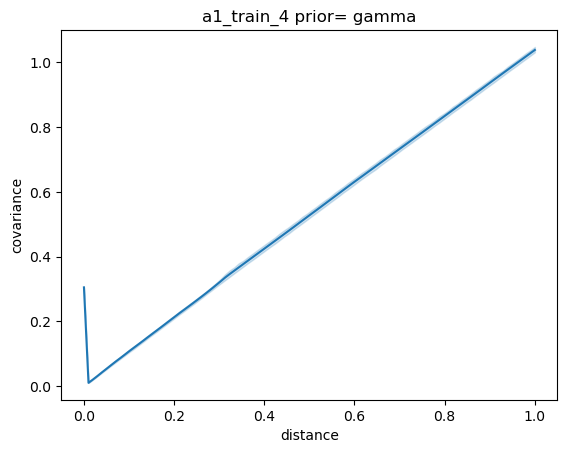

In [96]:
dist = torch.linspace(0,1,100)
lht_show_matern(kern, 'a1_train_4 prior= gamma', dist, prior=prior)

#### Gamma Prior-old

In [14]:
#| hide
fp = opt.a1_train_4
df = pd.read_csv(fp)
varogram_dist = 0.3
inducing_points = torch.load("model/ip500.pt")
folder = 'model/a1_train_4_gamma'
if not os.path.isdir(folder):
    os.mkdir(folder)
records_gamma = train_LhtMatern(df=df, varogram_dist=varogram_dist, inducing_points=inducing_points, prior='gamma',lr=0.001, folder=folder)

100%|█████████████████████████████████████████████████████| 16/16 [00:00<00:00, 3773.77it/s]


         nu     sigma      beta    nugget
0  0.030269  0.009280  0.050679  0.206920
1  4.682483  1.448537  3.195937  4.420285


cross-validation:   0%|          | 0/16 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/327 [00:00<?, ?it/s]

test:   0%|          | 0/53 [00:00<?, ?it/s]

Test, MAE: 0.4935162365436554 ,  ACC: 0.9951196172248804, train:65374, test:10450
         nu     sigma      beta    nugget
0  0.112757  0.003085  0.113450  0.122744
1  7.531621  1.151086  4.412308  3.453654


Minibatch:   0%|          | 0/268 [00:00<?, ?it/s]

test:   0%|          | 0/64 [00:00<?, ?it/s]

Test, MAE: 0.7470673322677612 ,  ACC: 0.9416980539861896, train:53536, test:12744
          nu     sigma      beta    nugget
0   0.345196  0.001139  0.221254  0.080201
1  12.615090  0.976824  6.090807  2.902422


Minibatch:   0%|          | 0/326 [00:00<?, ?it/s]

test:   0%|          | 0/16 [00:00<?, ?it/s]

Test, MAE: 1.0847305059432983 ,  ACC: 0.9990322580645161, train:65025, test:3100
          nu     sigma      beta    nugget
0   1.132622  0.000354  0.481255  0.047320
1  24.565082  0.835243  9.444796  2.409774


Minibatch:   0%|          | 0/432 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Test, MAE: 1.017401099205017 ,  ACC: 0.9560439560439561, train:86367, test:182
          nu     sigma       beta    nugget
0   1.739612  0.000226   0.664592  0.022345
1  32.213755  0.792781  11.562343  1.936623


Minibatch:   0%|          | 0/329 [00:00<?, ?it/s]

test:   0%|          | 0/8 [00:00<?, ?it/s]

Test, MAE: 0.583575963973999 ,  ACC: 0.6229050279329609, train:65619, test:1432
          nu     sigma       beta    nugget
0   1.834797  0.000214   0.694033  0.011803
1  33.359454  0.787945  11.893157  1.661818


Minibatch:   0%|          | 0/238 [00:00<?, ?it/s]

test:   0%|          | 0/51 [00:00<?, ?it/s]

Test, MAE: 0.6501618027687073 ,  ACC: 0.9525073746312684, train:47439, test:10170
         nu     sigma       beta    nugget
0   1.87671  0.000209   0.707065  0.007114
1  33.86043  0.785930  12.038968  1.496476


Minibatch:   0%|          | 0/269 [00:00<?, ?it/s]

test:   0%|          | 0/45 [00:00<?, ?it/s]

Test, MAE: 1.3909043073654175 ,  ACC: 0.9297128170745335, train:53709, test:8949
          nu     sigma       beta    nugget
0   1.911328  0.000205   0.717850  0.003838
1  34.272689  0.784315  12.159358  1.337923


Minibatch:   0%|          | 0/362 [00:00<?, ?it/s]

test:   0%|          | 0/2 [00:00<?, ?it/s]

Test, MAE: 2.020937204360962 ,  ACC: 0.8689458689458689, train:72254, test:351
          nu     sigma       beta    nugget
0   1.946198  0.000201   0.728723  0.001514
1  34.686583  0.782735  12.280477  1.159243


Minibatch:   0%|          | 0/385 [00:00<?, ?it/s]

test:   0%|          | 0/12 [00:00<?, ?it/s]

Test, MAE: 1.4310041666030884 ,  ACC: 0.9802490339201374, train:76841, test:2329
          nu     sigma       beta    nugget
0   1.975420  0.000198   0.737838  0.000481
1  35.032388  0.781445  12.381820  1.001857


Minibatch:   0%|          | 0/271 [00:00<?, ?it/s]

test:   0%|          | 0/47 [00:00<?, ?it/s]

Test, MAE: 0.8752356767654419 ,  ACC: 0.9953593783725447, train:54184, test:9266
          nu     sigma       beta    nugget
0   1.992801  0.000196   0.743259  0.000193
1  35.237638  0.780693  12.442018  0.907677


Minibatch:   0%|          | 0/211 [00:00<?, ?it/s]

test:   0%|          | 0/69 [00:00<?, ?it/s]

Test, MAE: 1.0279812812805176 ,  ACC: 0.43335033889658187, train:42146, test:13721
          nu     sigma       beta    nugget
0   2.004753  0.000195   0.746988  0.000089
1  35.378594  0.780182  12.483390  0.843086


Minibatch:   0%|          | 0/334 [00:00<?, ?it/s]

test:   0%|          | 0/42 [00:00<?, ?it/s]

Test, MAE: 0.5142073631286621 ,  ACC: 0.9975798644724104, train:66738, test:8264
          nu     sigma       beta    nugget
0   2.022131  0.000194   0.752406  0.000023
1  35.583266  0.779446  12.543442  0.751253


Minibatch:   0%|          | 0/437 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Test, MAE: 3.341158628463745 ,  ACC: 0.9318181818181818, train:87209, test:132
          nu     sigma       beta    nugget
0   2.042762  0.000192   0.758833  0.000003
1  35.825914  0.778589  12.614621  0.647831


Minibatch:   0%|          | 0/364 [00:00<?, ?it/s]

test:   0%|          | 0/2 [00:00<?, ?it/s]

Test, MAE: 1.4412474632263184 ,  ACC: 0.990909090909091, train:72618, test:330
          nu     sigma       beta        nugget
0   2.058322  0.000190   0.763678  3.491681e-07
1  36.008589  0.777952  12.668199  5.745206e-01


Minibatch:   0%|          | 0/337 [00:00<?, ?it/s]

test:   0%|          | 0/39 [00:00<?, ?it/s]

Test, MAE: 1.4244993925094604 ,  ACC: 0.63744447347792, train:67369, test:7654
          nu     sigma       beta        nugget
0   2.071661  0.000189   0.767826  3.968743e-08
1  36.165008  0.777413  12.714055  5.150732e-01


Minibatch:   0%|          | 0/366 [00:00<?, ?it/s]

test:   0%|          | 0/5 [00:00<?, ?it/s]

Test, MAE: 0.5339756011962891 ,  ACC: 0.9827213822894169, train:73156, test:926
          nu     sigma       beta        nugget
0   2.085298  0.000188   0.772061  2.633816e-09
1  36.324711  0.776866  12.760829  4.578059e-01


In [18]:
ret = test_records(df, inducing_points, records_gamma, model_type='lht', prior='gamma', cuda=False, mae_threshold=3)

verify:   0%|          | 0/16 [00:00<?, ?it/s]

0: mae: 0.4935162365436554, acc: 0.9951196172248804
num:81785, acc:0.9087222222222222, mae:0.9072107672691345
1: mae: 0.7470673322677612, acc: 0.9416980539861896
num:80971, acc:0.8996777777777778, mae:0.8995630145072937
2: mae: 1.0847305059432983, acc: 0.9990322580645161
num:82475, acc:0.9163888888888889, mae:0.8883066177368164
3: mae: 1.017401099205017, acc: 0.9560439560439561
num:73485, acc:0.8165, mae:0.8678698539733887
4: mae: 0.583575963973999, acc: 0.6229050279329609
num:74255, acc:0.8250555555555555, mae:0.929617702960968
5: mae: 0.6501618027687073, acc: 0.9525073746312684
num:79518, acc:0.8835333333333333, mae:0.9285817742347717
6: mae: 1.3909043073654175, acc: 0.9297128170745335
num:75936, acc:0.8437333333333333, mae:0.9246947169303894
7: mae: 2.020937204360962, acc: 0.8689458689458689
num:76140, acc:0.846, mae:0.9231659770011902
8: mae: 1.4310041666030884, acc: 0.9802490339201374
num:73985, acc:0.8220555555555555, mae:0.919390082359314
9: mae: 0.8752356767654419, acc: 0.99535

In [21]:
fp = opt.a1_train_4
df = pd.read_csv(fp)
points = df.to_numpy()
X = points[:,0:2]
Y = points[:,2]
tx = torch.from_numpy(X).float()
yy = torch.from_numpy(Y).float()
inducing_points = torch.load("model/ip500.pt")

state_dict_path = records_gamma[2]['param']
state_dict = torch.load(state_dict_path)

model = GP_AFirst(inducing_points.cpu(),nu=1, max_tries=200, prior='gamma')
model.load_state_dict(state_dict)
model.eval()
preds = model(tx)
means = preds.mean.cpu()
error = torch.mean(torch.abs(means - yy.cpu()))
l,v = preds.loc.cpu().detach().numpy(), preds.stddev.cpu().detach().numpy()
ci = norm.interval(0.95, loc=l, scale=v)
LB,UB = ci
a = np.logical_and(Y>=LB, Y<=UB)
acc = Y[a].shape[0] / len(Y)
df['LB'] = LB
df['UB'] = UB
print(f"num:{Y[a].shape[0]}, acc:{acc}, mae:{error.item()}")
df.head()

num:82475, acc:0.9163888888888889, mae:0.8883066177368164


s1        s2         z        LB        UB
0  0.244728  0.290552 -1.692733 -1.922645  0.443054
1  0.698403  0.369927 -3.135199 -3.265088  1.203871
2  0.374877  0.354492  0.178706 -1.973769  0.426626
3  0.163774  0.129513 -0.454076 -1.714450 -0.123421
4  0.094686  0.323892  0.023852 -2.498932  1.558803

In [26]:
mae = ret['mae']
acc = ret['acc']
mae = np.array(mae)
acc = np.array(acc)
am = acc/mae
idx = am.argmax()
print(f"ids:{idx}, mae:{mae[idx]}, acc:{acc[idx]}")

ids:2, mae:0.8883066177368164, acc:0.9163888888888889


In [22]:
idx=2
fp=f"model/a1_train_4_scv"
fp_ = f"{fp}_mae_acc.pth"
state_dict_path = records_gamma[2]['param']
state_dict = torch.load(state_dict_path)
torch.save(state_dict, fp_)

# a1_train_5

In [23]:
#| hide
fp = opt.a1_train_5
df = pd.read_csv(fp)

Text(0.5, 1.0, 'a1_train_5')

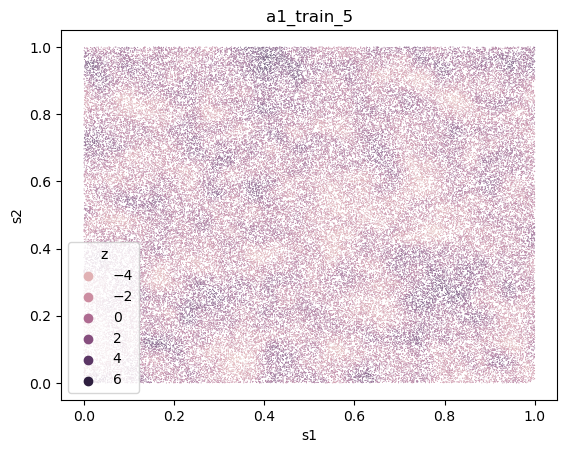

In [24]:
ax = sns.scatterplot(data=df, x='s1', y='s2', hue='z', s=0.5)
ax.set_title("a1_train_5")

<AxesSubplot:xlabel='z', ylabel='Density'>

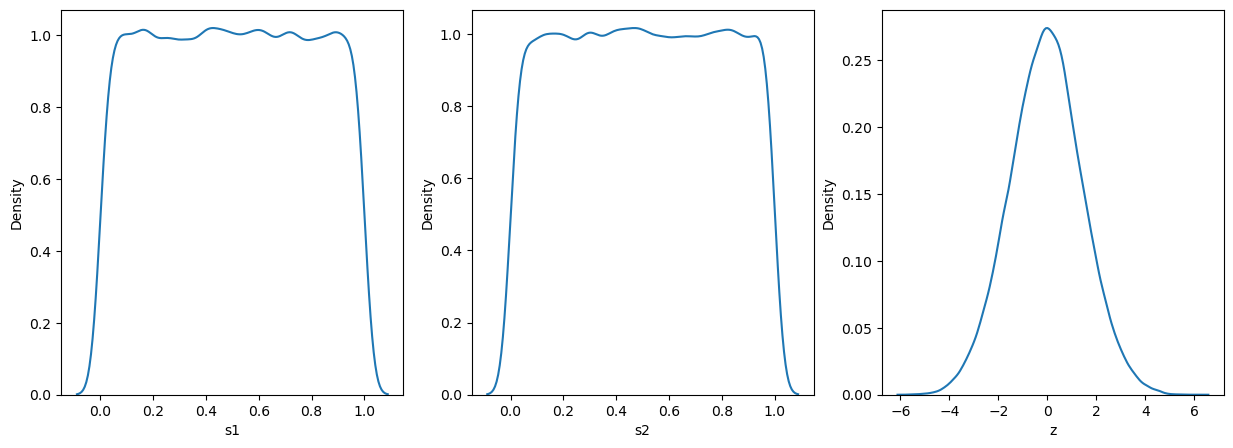

In [25]:
fig,axes = plt.subplots(1,3, figsize=(15,5))
sns.kdeplot(data=df, x='s1', ax=axes[0])
sns.kdeplot(data=df, x='s2', ax=axes[1])
sns.kdeplot(data=df, x='z', ax=axes[2])

## Spatial Cross Validation

### HalfNorm Prior

In [194]:
#| hide
fp = opt.a1_train_5
df = pd.read_csv(fp)
nugget = 0.75
varogram_dist = 0.2
inducing_points = torch.load("model/ip500.pt")
folder = 'model/a1_train_5_norm'
if not os.path.isdir(folder):
    os.mkdir(folder)
#
prior='halfnorm'
lr = 0.001
base_lr=0.0001
lr_step=100
device = torch.device("cpu")
best_params = {'acc':0, 'mae':2, 'acc_mae':0}

In [74]:
model = lhtcore.GP_AFirst(inducing_points,nu=1, max_tries=200,prior=prior,nugget=nugget)
likelihood = gpytorch.likelihoods.GaussianLikelihood()  
model.to(device)
likelihood.to(device)
params = list(model.parameters()) + list(likelihood.parameters())
optimizer = torch.optim.Adam(params, lr = lr, weight_decay=0.01 )
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=lr_step, eta_min=base_lr)

points = df.to_numpy()
best_params = {'acc':0, 'mae':2, 'acc_mae':0}

In [195]:
#| hide
num_epochs = 5 # 1200
num_iter = tqdm.notebook.tqdm(range(0,num_epochs))
for epoch in num_iter:
    model = lhtcore.GP_AFirst(inducing_points,nu=1, max_tries=200,prior=prior,nugget=nugget)
    likelihood = gpytorch.likelihoods.GaussianLikelihood()  
    mll = gpytorch.mlls.PredictiveLogLikelihood(likelihood, model, num_data=len(points))
    model.to(device)
    likelihood.to(device)
    params = list(model.parameters()) + list(likelihood.parameters())
    optimizer = torch.optim.Adam(params, lr = lr, weight_decay=0.01 )
    lhtutil.lht_train_one_epoch(model,optimizer,likelihood,mll,points,device,lr_scheduler=None,batch_size=200)
   
    ret_test = lhtutil.lht_test(model,points,device,flag=True)
    acc, mae = ret_test['acc'], ret_test['mae']
    if acc > best_params['acc']:
        best_params['acc'] = acc
        param_fp = os.path.join(folder, f'best_acc.pth')
        torch.save(model.state_dict(), param_fp) 
    #
    if mae < best_params['mae']:
        best_params['mae'] = mae
        param_fp = os.path.join(folder, f'best_mae.pth')
        torch.save(model.state_dict(), param_fp)
    #
    acc_mae = acc / mae
    if acc_mae > best_params['acc_mae']:
        best_params['acc_mae'] = acc_mae
        param_fp = os.path.join(folder, f'best_acc_mae.pth')
        torch.save(model.state_dict(), param_fp)
        

  0%|          | 0/5 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/450 [00:00<?, ?it/s]

test:   0%|          | 0/450 [00:00<?, ?it/s]

num:90000, acc:1.0, mae:0.9345133900642395


Minibatch:   0%|          | 0/450 [00:00<?, ?it/s]

test:   0%|          | 0/450 [00:00<?, ?it/s]

num:85115, acc:0.9457222222222222, mae:0.9003742933273315


Minibatch:   0%|          | 0/450 [00:00<?, ?it/s]

test:   0%|          | 0/450 [00:00<?, ?it/s]

num:88067, acc:0.9785222222222222, mae:0.9168823957443237


Minibatch:   0%|          | 0/450 [00:00<?, ?it/s]

test:   0%|          | 0/450 [00:00<?, ?it/s]

num:88023, acc:0.9780333333333333, mae:0.9308483600616455


Minibatch:   0%|          | 0/450 [00:00<?, ?it/s]

test:   0%|          | 0/450 [00:00<?, ?it/s]

num:90000, acc:1.0, mae:0.9387418627738953


In [197]:
folder = 'model/a1_train_5_norm'
nugget = 0.75
prior='halfnorm'
state_dict_path = os.path.join(folder,'best_mae01.pth')
state_dict = torch.load(state_dict_path)
model = lhtcore.GP_AFirst(inducing_points,nu=1, max_tries=200,prior=prior,nugget=nugget)
model.load_state_dict(state_dict)
kern = model.covar_module.base_kernel
ret_test = lhtutil.lht_test(model,points,device,flag=True)

test:   0%|          | 0/450 [00:00<?, ?it/s]

num:85115, acc:0.9457222222222222, mae:0.9003742933273315


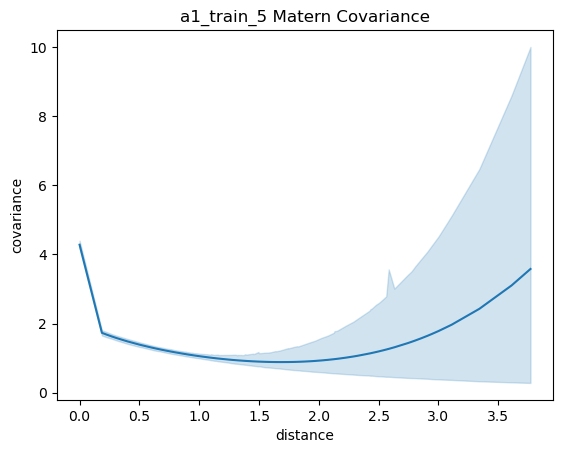

In [200]:
a = torch.randn(100,2)
a = a - a[0]
b = torch.linalg.norm(a,dim=1)
lht_show_matern(kern, 'a1_train_5 Matern Covariance', b, prior=prior)

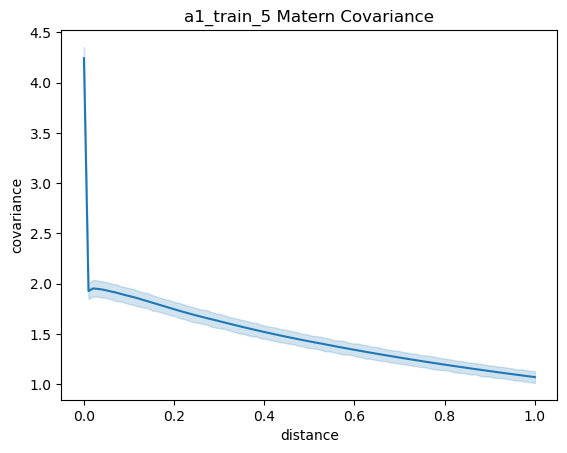

In [198]:
dist = torch.linspace(0,1,100)
lht_show_matern(model.covar_module.base_kernel, 'a1_train_5 Matern Covariance', dist, prior=prior)

In [201]:
lhtutil.showCI_NSBN(model)

nu     sigma      beta    nugget
0  0.085129  0.046453  0.030928  0.791846
1  6.088741  3.322461  2.212068  3.742959

#### HalfNorm Prior-old

In [109]:
#| hide
fp = opt.a1_train_5
df = pd.read_csv(fp)
varogram_dist = 0.2
inducing_points = torch.load("model/ip500.pt")
folder = 'model/a1_train_5_norm'
if not os.path.isdir(folder):
    os.mkdir(folder)
records_norm_5 = train_LhtMatern(df=df, varogram_dist=varogram_dist, inducing_points=inducing_points, prior='halfnorm',lr=0.001, folder=folder)

100%|████████████████████████████████████████████████████| 25/25 [00:00<00:00, 11486.21it/s]


         nu     sigma      beta    nugget
0  0.068963  0.128421  0.034882  0.032390
1  4.932456  9.185123  2.494897  2.316672


cross-validation:   0%|          | 0/25 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/397 [00:00<?, ?it/s]

test:   0%|          | 0/19 [00:00<?, ?it/s]

Test, MAE: 1.2927253246307373 ,  ACC: 0.976380115352925, train:79272, test:3641
         nu     sigma      beta    nugget
0  0.081366  0.115897  0.043926  0.025186
1  5.819592  8.289379  3.141748  1.801368


Minibatch:   0%|          | 0/379 [00:00<?, ?it/s]

test:   0%|          | 0/18 [00:00<?, ?it/s]

Test, MAE: 1.252879023551941 ,  ACC: 0.8879237881759596, train:75672, test:3569
         nu     sigma      beta   nugget
0  0.094684  0.103889  0.053356  0.01976
1  6.772113  7.430509  3.816244  1.41332


Minibatch:   0%|          | 0/378 [00:00<?, ?it/s]

test:   0%|          | 0/19 [00:00<?, ?it/s]

Test, MAE: 1.1945581436157227 ,  ACC: 0.9220348354990323, train:75565, test:3617
         nu     sigma      beta    nugget
0  0.107941  0.092474  0.062782  0.015559
1  7.720300  6.614058  4.490407  1.112853


Minibatch:   0%|          | 0/379 [00:00<?, ?it/s]

test:   0%|          | 0/18 [00:00<?, ?it/s]

Test, MAE: 1.2881306409835815 ,  ACC: 0.8328173374613003, train:75693, test:3553
         nu     sigma      beta    nugget
0  0.120434  0.081892  0.071761  0.012320
1  8.613853  5.857188  5.132614  0.881147


Minibatch:   0%|          | 0/397 [00:00<?, ?it/s]

test:   0%|          | 0/19 [00:00<?, ?it/s]

Test, MAE: 1.3162306547164917 ,  ACC: 0.824230662600499, train:79269, test:3607
         nu     sigma      beta    nugget
0  0.132369  0.071839  0.080422  0.009728
1  9.467527  5.138172  5.752061  0.695774


Minibatch:   0%|          | 0/379 [00:00<?, ?it/s]

test:   0%|          | 0/18 [00:00<?, ?it/s]

Test, MAE: 1.492444396018982 ,  ACC: 0.7288231949971575, train:75758, test:3518
          nu     sigma      beta    nugget
0   0.142619  0.063228  0.087925  0.007820
1  10.200601  4.522276  6.288703  0.559348


Minibatch:   0%|          | 0/361 [00:00<?, ?it/s]

test:   0%|          | 0/18 [00:00<?, ?it/s]

Test, MAE: 1.3349391222000122 ,  ACC: 0.840902599257355, train:72124, test:3501
          nu     sigma      beta    nugget
0   0.151452  0.055880  0.094409  0.006399
1  10.832350  3.996706  6.752462  0.457678


Minibatch:   0%|          | 0/360 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
ret = test_records(df, inducing_points, records_norm_5, model_type='lht', prior='halfnorm', cuda=False, mae_threshold=3)

### Gamma Prior

In [96]:
#| hide
fp = opt.a1_train_5
df = pd.read_csv(fp)
nugget = 0.75
varogram_dist = 0.2
inducing_points = torch.load("model/ip500.pt")
folder = 'model/a1_train_5_gamma'
if not os.path.isdir(folder):
    os.mkdir(folder)
#
prior='gamma'
lr = 0.001
base_lr=0.0001
lr_step=100
device = torch.device("cpu")

model = lhtcore.GP_AFirst(inducing_points,nu=1, max_tries=200,prior=prior,nugget=nugget)
likelihood = gpytorch.likelihoods.GaussianLikelihood()  
model.to(device)
likelihood.to(device)
params = list(model.parameters()) + list(likelihood.parameters())
optimizer = torch.optim.Adam(params, lr = lr, weight_decay=0.01 )
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=lr_step, eta_min=base_lr)

points = df.to_numpy()

In [89]:
best_params = {'acc':0, 'mae':2, 'acc_mae':0}

In [107]:
#| hide
num_epochs = 10 # 1200
num_iter = tqdm.notebook.tqdm(range(0,num_epochs))
for epoch in num_iter:
    lhtutil.lht_train_one_epoch(model,optimizer,likelihood,points,device,lr_scheduler,batch_size=200)
    ret_test = lhtutil.lht_test(model,points,device,flag=True)
    acc, mae = ret_test['acc'], ret_test['mae']
    if acc > best_params['acc']:
        best_params['acc'] = acc
        param_fp = os.path.join(folder, f'best_acc.pth')
        torch.save(model.state_dict(), param_fp) 
    #
    if mae < best_params['mae']:
        best_params['mae'] = mae
        param_fp = os.path.join(folder, f'best_mae.pth')
        torch.save(model.state_dict(), param_fp)
    #
    acc_mae = acc / mae
    if acc_mae > best_params['acc_mae']:
        best_params['acc_mae'] = acc_mae
        param_fp = os.path.join(folder, f'best_acc_mae.pth')
        torch.save(model.state_dict(), param_fp)
        

  0%|          | 0/10 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/450 [00:00<?, ?it/s]

test:   0%|          | 0/450 [00:00<?, ?it/s]

num:77376, acc:0.8597333333333333, mae:1.1747313737869263


Minibatch:   0%|          | 0/450 [00:00<?, ?it/s]

test:   0%|          | 0/450 [00:00<?, ?it/s]

num:74087, acc:0.8231888888888889, mae:1.1749335527420044


Minibatch:   0%|          | 0/450 [00:00<?, ?it/s]

test:   0%|          | 0/450 [00:00<?, ?it/s]

num:73997, acc:0.8221888888888889, mae:1.174517035484314


Minibatch:   0%|          | 0/450 [00:00<?, ?it/s]

test:   0%|          | 0/450 [00:00<?, ?it/s]

num:72997, acc:0.8110777777777778, mae:1.1793060302734375


Minibatch:   0%|          | 0/450 [00:00<?, ?it/s]

test:   0%|          | 0/450 [00:00<?, ?it/s]

num:72007, acc:0.8000777777777778, mae:1.174746036529541


Minibatch:   0%|          | 0/450 [00:00<?, ?it/s]

test:   0%|          | 0/450 [00:00<?, ?it/s]

num:72711, acc:0.8079, mae:1.1750857830047607


Minibatch:   0%|          | 0/450 [00:00<?, ?it/s]

test:   0%|          | 0/450 [00:00<?, ?it/s]

num:74657, acc:0.8295222222222223, mae:1.1749811172485352


Minibatch:   0%|          | 0/450 [00:00<?, ?it/s]

test:   0%|          | 0/450 [00:00<?, ?it/s]

num:78835, acc:0.8759444444444444, mae:1.1760090589523315


Minibatch:   0%|          | 0/450 [00:00<?, ?it/s]

test:   0%|          | 0/450 [00:00<?, ?it/s]

num:76206, acc:0.8467333333333333, mae:1.1745522022247314


Minibatch:   0%|          | 0/450 [00:00<?, ?it/s]

test:   0%|          | 0/450 [00:00<?, ?it/s]

num:72851, acc:0.8094555555555556, mae:1.1740189790725708


In [90]:
#| hide
num_epochs = 1 # 1200
num_iter = tqdm.notebook.tqdm(range(0,num_epochs))
for epoch in num_iter:
    lhtutil.lht_train_one_epoch(model,optimizer,likelihood,points,device,lr_scheduler,batch_size=200)
    ret_test = lhtutil.lht_test(model,points,device,flag=True)
    acc, mae = ret_test['acc'], ret_test['mae']
    if acc > best_params['acc']:
        best_params['acc'] = acc
        param_fp = os.path.join(folder, f'best_acc.pth')
        torch.save(model.state_dict(), param_fp) 
    #
    if mae < best_params['mae']:
        best_params['mae'] = mae
        param_fp = os.path.join(folder, f'best_mae.pth')
        torch.save(model.state_dict(), param_fp)
    #
    acc_mae = acc / mae
    if acc_mae > best_params['acc_mae']:
        best_params['acc_mae'] = acc_mae
        param_fp = os.path.join(folder, f'best_acc_mae.pth')
        torch.save(model.state_dict(), param_fp)
        

  0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/450 [00:00<?, ?it/s]

test:   0%|          | 0/450 [00:00<?, ?it/s]

num:60269, acc:0.6696555555555556, mae:1.1810630559921265


In [97]:
#| hide
num_epochs = 3 # 1200
num_iter = tqdm.notebook.tqdm(range(0,num_epochs))
for epoch in num_iter:
    lhtutil.lht_train_one_epoch(model,optimizer,likelihood,points,device,lr_scheduler=None,batch_size=200)
    ret_test = lhtutil.lht_test(model,points,device,flag=True)
    acc, mae = ret_test['acc'], ret_test['mae']
    if acc > best_params['acc']:
        best_params['acc'] = acc
        param_fp = os.path.join(folder, f'best_acc.pth')
        torch.save(model.state_dict(), param_fp) 
    #
    if mae < best_params['mae']:
        best_params['mae'] = mae
        param_fp = os.path.join(folder, f'best_mae.pth')
        torch.save(model.state_dict(), param_fp)
    #
    acc_mae = acc / mae
    if acc_mae > best_params['acc_mae']:
        best_params['acc_mae'] = acc_mae
        param_fp = os.path.join(folder, f'best_acc_mae.pth')
        torch.save(model.state_dict(), param_fp)
        

  0%|          | 0/3 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/450 [00:00<?, ?it/s]

test:   0%|          | 0/450 [00:00<?, ?it/s]

num:79624, acc:0.8847111111111111, mae:1.1795445680618286


Minibatch:   0%|          | 0/450 [00:00<?, ?it/s]

test:   0%|          | 0/450 [00:00<?, ?it/s]

num:76809, acc:0.8534333333333334, mae:1.176757574081421


Minibatch:   0%|          | 0/450 [00:00<?, ?it/s]

test:   0%|          | 0/450 [00:00<?, ?it/s]

num:74813, acc:0.8312555555555555, mae:1.1809561252593994


In [98]:
folder = 'model/a1_train_5_gamma'
nugget = 0.75
prior='gamma'
state_dict_path = os.path.join(folder,'best_acc_mae.pth')
state_dict = torch.load(state_dict_path)
model = lhtcore.GP_AFirst(inducing_points,nu=1, max_tries=200,prior=prior,nugget=nugget)
model.load_state_dict(state_dict)
kern = model.covar_module.base_kernel

In [108]:
ret_test = lhtutil.lht_test(model,points,device,flag=True)

test:   0%|          | 0/450 [00:00<?, ?it/s]

num:78835, acc:0.8759444444444444, mae:1.1760090589523315


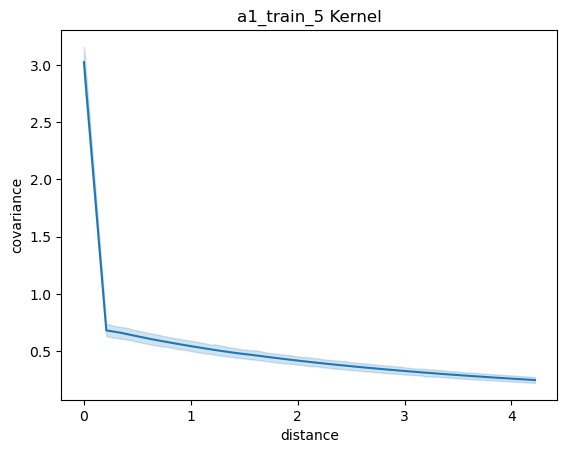

In [100]:
a = torch.randn(100,2)
a = a - a[0]
dist = torch.linalg.norm(a,dim=1)
lht_show_matern(kern, 'a1_train_5 Kernel', dist, prior=prior)

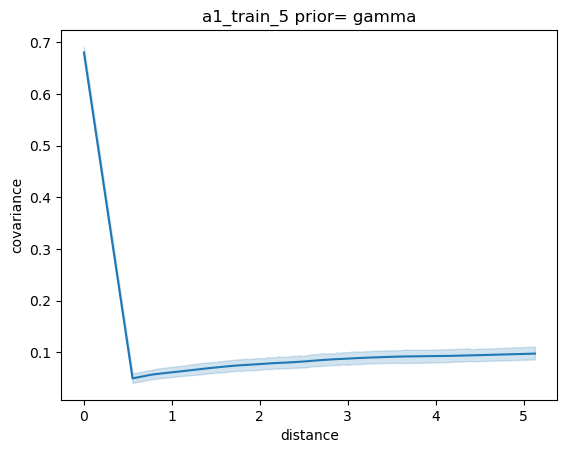

In [94]:
a = torch.randn(100,2)
a = a - a[0]
dist = torch.linalg.norm(a,dim=1)
lht_show_matern(kern, 'a1_train_5 prior= gamma', dist, prior=prior)

In [95]:
lhtutil.showCI_NSBN(model)

nu     sigma       beta    nugget
0   2.202049  0.000091   1.011774  0.750000
1  29.839055  1.360585  18.644556  1.259821

#### Gamma Prior-old

In [27]:
#| hide
fp = opt.a1_train_5
df = pd.read_csv(fp)
varogram_dist = 0.2
inducing_points = torch.load("model/ip500.pt")
folder = 'model/a1_train_5_gamma'
if not os.path.isdir(folder):
    os.mkdir(folder)
records_gamma = train_LhtMatern(df=df, varogram_dist=varogram_dist, inducing_points=inducing_points, prior='gamma',lr=0.001, folder=folder)

100%|█████████████████████████████████████████████████████| 25/25 [00:00<00:00, 8338.58it/s]


         nu     sigma      beta    nugget
0  0.009853  0.020219  0.291402  0.045772
1  3.354479  3.696531  6.557739  4.410892


cross-validation:   0%|          | 0/25 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/397 [00:00<?, ?it/s]

test:   0%|          | 0/19 [00:00<?, ?it/s]

Test, MAE: 1.1098389625549316 ,  ACC: 0.8525130458665202, train:79272, test:3641
         nu     sigma      beta    nugget
0  0.056484  0.005130  0.574616  0.014107
1  5.719172  2.623609  9.688378  3.099909


Minibatch:   0%|          | 0/379 [00:00<?, ?it/s]

test:   0%|          | 0/18 [00:00<?, ?it/s]

Test, MAE: 1.1661490201950073 ,  ACC: 0.7752871952927991, train:75672, test:3569
          nu     sigma       beta    nugget
0   0.271384  0.001508   1.120630  0.004333
1  11.214805  2.080323  14.999935  2.370218


Minibatch:   0%|          | 0/378 [00:00<?, ?it/s]

test:   0%|          | 0/19 [00:00<?, ?it/s]

Test, MAE: 1.0717480182647705 ,  ACC: 0.9062759192701133, train:75565, test:3617
          nu     sigma       beta    nugget
0   0.979596  0.000530   2.224739  0.001204
1  22.723572  1.772778  24.530958  1.891640


Minibatch:   0%|          | 0/379 [00:00<?, ?it/s]

test:   0%|          | 0/18 [00:00<?, ?it/s]

Test, MAE: 1.1912055015563965 ,  ACC: 0.8426681677455671, train:75693, test:3553
          nu     sigma       beta    nugget
0   1.217457  0.000443   2.560304  0.000289
1  25.988086  1.729626  27.262356  1.552552


Minibatch:   0%|          | 0/397 [00:00<?, ?it/s]

test:   0%|          | 0/19 [00:00<?, ?it/s]

Test, MAE: 1.2769958972930908 ,  ACC: 0.9378985306348766, train:79269, test:3607
          nu     sigma       beta    nugget
0   1.278455  0.000426   2.646789  0.000054
1  26.803432  1.720433  27.959281  1.289800


Minibatch:   0%|          | 0/379 [00:00<?, ?it/s]

test:   0%|          | 0/18 [00:00<?, ?it/s]

Test, MAE: 1.2836092710494995 ,  ACC: 0.8527572484366117, train:75758, test:3518
          nu     sigma       beta    nugget
0   1.311424  0.000418   2.693439  0.000009
1  27.240940  1.715740  28.334120  1.095666


Minibatch:   0%|          | 0/361 [00:00<?, ?it/s]

test:   0%|          | 0/18 [00:00<?, ?it/s]

Test, MAE: 1.3726454973220825 ,  ACC: 0.7869180234218794, train:72124, test:3501
          nu     sigma       beta    nugget
0   1.333753  0.000412   2.724941  0.000001
1  27.536043  1.712671  28.586828  0.947153


Minibatch:   0%|          | 0/360 [00:00<?, ?it/s]

test:   0%|          | 0/19 [00:00<?, ?it/s]

Test, MAE: 0.9225908517837524 ,  ACC: 0.864448051948052, train:71972, test:3696
          nu     sigma       beta        nugget
0   1.351418  0.000408   2.749791  1.272165e-07
1  27.768826  1.710303  28.785940  8.250740e-01


Minibatch:   0%|          | 0/361 [00:00<?, ?it/s]

test:   0%|          | 0/18 [00:00<?, ?it/s]

Test, MAE: 1.0612525939941406 ,  ACC: 0.9444759206798867, train:72012, test:3530
          nu     sigma       beta        nugget
0   1.366320  0.000404   2.770697  1.007452e-08
1  27.964761  1.708346  28.953281  7.223142e-01


Minibatch:   0%|          | 0/378 [00:00<?, ?it/s]

test:   0%|          | 0/18 [00:00<?, ?it/s]

Test, MAE: 1.1537460088729858 ,  ACC: 0.8731447773732848, train:75594, test:3571
          nu     sigma       beta        nugget
0   1.379963  0.000401   2.789782  4.913604e-10
1  28.143769  1.706587  29.105955  6.308845e-01


Minibatch:   0%|          | 0/380 [00:00<?, ?it/s]

test:   0%|          | 0/18 [00:00<?, ?it/s]

Test, MAE: 1.1377407312393188 ,  ACC: 0.9597989949748744, train:75826, test:3582
          nu     sigma       beta        nugget
0   1.392343  0.000398   2.807049  1.492356e-11
1  28.305931  1.705018  29.243960  5.515342e-01


Minibatch:   0%|          | 0/360 [00:00<?, ?it/s]

test:   0%|          | 0/18 [00:00<?, ?it/s]

Test, MAE: 1.001258373260498 ,  ACC: 0.9521158129175946, train:71900, test:3592
          nu     sigma       beta        nugget
0   1.403144  0.000396   2.822067  3.398927e-13
1  28.447155  1.703668  29.363909  4.860484e-01


Minibatch:   0%|          | 0/360 [00:00<?, ?it/s]

test:   0%|          | 0/19 [00:00<?, ?it/s]

Test, MAE: 1.220889687538147 ,  ACC: 0.8314332247557004, train:71893, test:3684
          nu     sigma       beta        nugget
0   1.413244  0.000394   2.836080  4.595262e-15
1  28.579042  1.702424  29.475763  4.283527e-01


Minibatch:   0%|          | 0/360 [00:00<?, ?it/s]

test:   0%|          | 0/19 [00:00<?, ?it/s]

Test, MAE: 0.9412176609039307 ,  ACC: 0.9345794392523364, train:71828, test:3638
          nu     sigma       beta        nugget
0   1.422807  0.000392   2.849312  3.441350e-17
1  28.703750  1.701260  29.581375  3.772106e-01


Minibatch:   0%|          | 0/378 [00:00<?, ?it/s]

test:   0%|          | 0/19 [00:00<?, ?it/s]

Test, MAE: 1.3216420412063599 ,  ACC: 0.8361276365603029, train:75434, test:3698
          nu     sigma       beta        nugget
0   1.432425  0.000390   2.862611  9.676126e-20
1  28.829068  1.700111  29.687359  3.294099e-01


Minibatch:   0%|          | 0/378 [00:00<?, ?it/s]

test:   0%|          | 0/18 [00:00<?, ?it/s]

Test, MAE: 1.1669807434082031 ,  ACC: 0.9327972429638139, train:75591, test:3482
          nu     sigma       beta        nugget
0   1.441774  0.000388   2.875508  1.105673e-22
1  28.950701  1.698999  29.790127  2.865867e-01


Minibatch:   0%|          | 0/361 [00:00<?, ?it/s]

test:   0%|          | 0/19 [00:00<?, ?it/s]

Test, MAE: 1.6882824897766113 ,  ACC: 0.7062282812082331, train:72140, test:3741
          nu     sigma       beta        nugget
0   1.450439  0.000386   2.887412  6.661604e-26
1  29.063269  1.697985  29.884941  2.498959e-01


Minibatch:   0%|          | 0/360 [00:00<?, ?it/s]

test:   0%|          | 0/18 [00:00<?, ?it/s]

Test, MAE: 1.4938374757766724 ,  ACC: 0.6617100371747212, train:71831, test:3497
          nu     sigma       beta        nugget
0   1.458839  0.000384   2.898927  1.447447e-29
1  29.172331  1.697009  29.976654  2.169807e-01


Minibatch:   0%|          | 0/360 [00:00<?, ?it/s]

test:   0%|          | 0/19 [00:00<?, ?it/s]

Test, MAE: 1.104620337486267 ,  ACC: 0.8655438983986747, train:71998, test:3622
          nu     sigma       beta        nugget
0   1.467021  0.000383   2.910096  9.660426e-34
1  29.278457  1.696074  30.065620  1.873645e-01


Minibatch:   0%|          | 0/377 [00:00<?, ?it/s]

test:   0%|          | 0/19 [00:00<?, ?it/s]

Test, MAE: 1.2186912298202515 ,  ACC: 0.7881934954905712, train:75382, test:3659
          nu     sigma       beta        nugget
0   1.475435  0.000381   2.921555  9.341774e-39
1  29.387383  1.695110  30.156815  1.594730e-01


Minibatch:   0%|          | 0/397 [00:00<?, ?it/s]

test:   0%|          | 0/19 [00:00<?, ?it/s]

Test, MAE: 1.1241240501403809 ,  ACC: 0.9886237513873474, train:79366, test:3604
          nu     sigma       beta        nugget
0   1.484189  0.000380   2.933482  6.963556e-45
1  29.500865  1.694126  30.251703  1.331557e-01


Minibatch:   0%|          | 0/378 [00:00<?, ?it/s]

test:   0%|          | 0/18 [00:00<?, ?it/s]

Test, MAE: 1.407107949256897 ,  ACC: 0.7897406989853438, train:75482, test:3548
          nu     sigma       beta        nugget
0   1.492419  0.000378   2.944641  1.279258e-51
1  29.607171  1.693223  30.340393  1.109282e-01


Minibatch:   0%|          | 0/379 [00:00<?, ?it/s]

test:   0%|          | 0/19 [00:00<?, ?it/s]

Test, MAE: 0.8875702023506165 ,  ACC: 0.984551724137931, train:75744, test:3625
          nu     sigma       beta        nugget
0   1.500555  0.000377   2.955657  2.161918e-59
1  29.712257  1.692327  30.427938  9.121446e-02


Minibatch:   0%|          | 0/378 [00:00<?, ?it/s]

test:   0%|          | 0/18 [00:00<?, ?it/s]

Test, MAE: 0.9219887852668762 ,  ACC: 0.9868934746235359, train:75528, test:3586
          nu     sigma       beta        nugget
0   1.508598  0.000375   2.966525  2.599155e-68
1  29.815819  1.691445  30.514099  7.395364e-02


Minibatch:   0%|          | 0/396 [00:00<?, ?it/s]

test:   0%|          | 0/19 [00:00<?, ?it/s]

Test, MAE: 1.2054870128631592 ,  ACC: 0.8675460291288816, train:79116, test:3639
          nu     sigma       beta        nugget
0   1.516924  0.000374   2.977748  3.957186e-79
1  29.923388  1.690541  30.603452  5.824643e-02


In [28]:
ret = test_records(df, inducing_points, records_gamma, model_type='lht', prior='gamma', cuda=False, mae_threshold=3)

verify:   0%|          | 0/25 [00:00<?, ?it/s]

0: mae: 1.1098389625549316, acc: 0.8525130458665202
num:78934, acc:0.8770444444444444, mae:1.172825574874878
1: mae: 1.1661490201950073, acc: 0.7752871952927991
num:77925, acc:0.8658333333333333, mae:1.171017050743103
2: mae: 1.0717480182647705, acc: 0.9062759192701133
num:81285, acc:0.9031666666666667, mae:1.1665208339691162
3: mae: 1.1912055015563965, acc: 0.8426681677455671
num:79214, acc:0.8801555555555556, mae:1.1649600267410278
4: mae: 1.2769958972930908, acc: 0.9378985306348766
num:81111, acc:0.9012333333333333, mae:1.1635921001434326
5: mae: 1.2836092710494995, acc: 0.8527572484366117
num:79688, acc:0.8854222222222222, mae:1.16209876537323
6: mae: 1.3726454973220825, acc: 0.7869180234218794
num:78905, acc:0.8767222222222222, mae:1.1617122888565063
7: mae: 0.9225908517837524, acc: 0.864448051948052
num:75484, acc:0.8387111111111111, mae:1.1607238054275513
8: mae: 1.0612525939941406, acc: 0.9444759206798867
num:82184, acc:0.9131555555555556, mae:1.1604584455490112
9: mae: 1.15374

In [29]:
mae = ret['mae']
acc = ret['acc']
mae = np.array(mae)
acc = np.array(acc)
am = acc/mae
idx = am.argmax()
print(f"ids:{idx}, mae:{mae[idx]}, acc:{acc[idx]}")

ids:20, mae:1.1588916778564453, acc:0.9400111111111111


In [30]:
fp = opt.a1_train_5
df = pd.read_csv(fp)
points = df.to_numpy()
X = points[:,0:2]
Y = points[:,2]
tx = torch.from_numpy(X).float()
yy = torch.from_numpy(Y).float()
inducing_points = torch.load("model/ip500.pt")

state_dict_path = records_gamma[20]['param']
state_dict = torch.load(state_dict_path)

model = GP_AFirst(inducing_points.cpu(),nu=1, max_tries=200, prior='gamma')
model.load_state_dict(state_dict)
model.eval()
preds = model(tx)
means = preds.mean.cpu()
error = torch.mean(torch.abs(means - yy.cpu()))
l,v = preds.loc.cpu().detach().numpy(), preds.stddev.cpu().detach().numpy()
ci = norm.interval(0.95, loc=l, scale=v)
LB,UB = ci
a = np.logical_and(Y>=LB, Y<=UB)
acc = Y[a].shape[0] / len(Y)
df['LB'] = LB
df['UB'] = UB
print(f"num:{Y[a].shape[0]}, acc:{acc}, mae:{error.item()}")
df.head()

num:84601, acc:0.9400111111111111, mae:1.1588916778564453


s1        s2         z        LB        UB
0  0.555555  0.001010 -1.785809 -3.595039  3.068716
1  0.288990  0.797357 -3.300493 -2.391655  2.624985
2  0.705945  0.407423  0.875320 -3.494522  2.483541
3  0.870923  0.496352 -0.092756 -3.218604  2.462901
4  0.265259  0.723054  0.253596 -2.384964  2.397468

In [31]:
idx=20
fp=f"model/a1_train_5_scv"
fp_ = f"{fp}_mae_acc.pth"
state_dict_path = records_gamma[idx]['param']
state_dict = torch.load(state_dict_path)
torch.save(state_dict, fp_)

# value predict

In [167]:
data_paths = [opt.a2_train_1,opt.a2_train_2,opt.a2_train_3,opt.a2_train_4,opt.a2_train_5,]
model_paths = [opt.fp_a21,opt.fp_a22,opt.fp_a23,opt.fp_a24,opt.fp_a25]
ds_names = ['a2_train_1','a2_train_2','a2_train_3','a2_train_4','a2_train_5',]
inducing_points = torch.load("model/ip2000.pt")
nu=2.5
for dsn, fp, mp in zip(ds_names, data_paths, model_paths):
    df = pd.read_csv(fp)
    state_dict = torch.load(mp)
    model = StandardApproximateGP_mat(inducing_points=inducing_points, nu=nu).cpu()
    model.load_state_dict(state_dict)
    mae, acc = show_mae_acc(df, model)
    print(f'{dsn}-mae:{mae}, acc:{acc}')

a2_train_1-mae:0.4299546778202057, acc:0.8955666666666666
a2_train_2-mae:0.4457576870918274, acc:0.9246444444444445
a2_train_3-mae:0.7653962969779968, acc:0.8833555555555556
a2_train_4-mae:0.488565593957901, acc:0.8995
a2_train_5-mae:0.5513303279876709, acc:0.9636777777777777


# a2_train_1

In [78]:
#| hide
fp = opt.a2_train_1
df = pd.read_csv(fp)

Text(0.5, 1.0, 'a2_train_1')

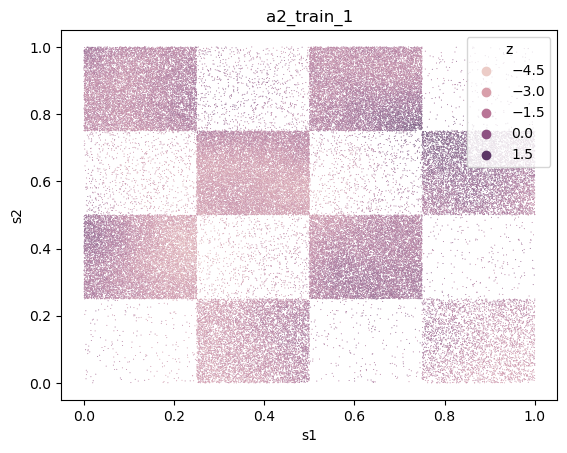

In [79]:
ax = sns.scatterplot(data=df, x='s1', y='s2', hue='z', s=0.5)
ax.set_title("a2_train_1")

<AxesSubplot:xlabel='z', ylabel='Density'>

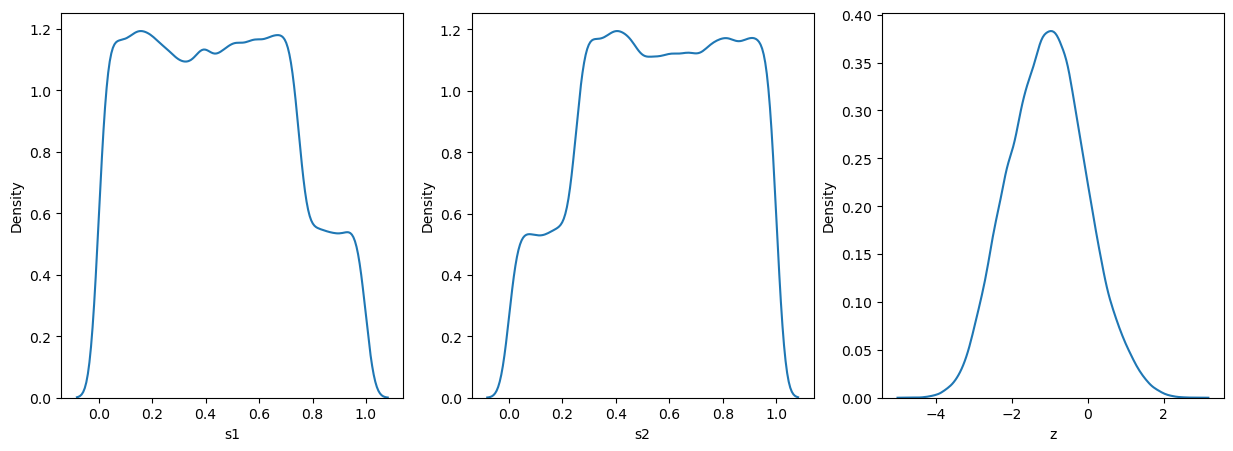

In [80]:
fig,axes = plt.subplots(1,3, figsize=(15,5))
sns.kdeplot(data=df, x='s1', ax=axes[0])
sns.kdeplot(data=df, x='s2', ax=axes[1])
sns.kdeplot(data=df, x='z', ax=axes[2])

## Spatial Cross Validataion

In [165]:
fp = opt.a2_train_1
df = pd.read_csv(fp)
inducing_points = torch.load("model/ip2000.pt").cpu()
varogram_dist = 0.2
records = train_standardGPMatern(df, varogram_dist, inducing_points, cuda=True, nu=2.5, lr=0.1, batch_size=200)

100%|█████████████████████████████████████████████████████| 25/25 [00:00<00:00, 8717.07it/s]


cross-validation:   0%|          | 0/25 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/400 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Test, MAE: 1.3824745416641235 ,  ACC: 0.34328358208955223, train:79860, test:134


Minibatch:   0%|          | 0/383 [00:00<?, ?it/s]

test:   0%|          | 0/31 [00:00<?, ?it/s]

Test, MAE: 1.3195534944534302 ,  ACC: 0.3776281208935611, train:76567, test:6088


Minibatch:   0%|          | 0/361 [00:00<?, ?it/s]

test:   0%|          | 0/23 [00:00<?, ?it/s]

Test, MAE: 1.4168751239776611 ,  ACC: 0.3386877828054299, train:72171, test:4420


Minibatch:   0%|          | 0/344 [00:00<?, ?it/s]

test:   0%|          | 0/13 [00:00<?, ?it/s]

Test, MAE: 0.5851033926010132 ,  ACC: 0.7618850764778834, train:68707, test:2419


Minibatch:   0%|          | 0/386 [00:00<?, ?it/s]

test:   0%|          | 0/41 [00:00<?, ?it/s]

Test, MAE: 0.6228044033050537 ,  ACC: 0.8410287813839559, train:77102, test:8165


Minibatch:   0%|          | 0/403 [00:00<?, ?it/s]

test:   0%|          | 0/20 [00:00<?, ?it/s]

Test, MAE: 0.739794909954071 ,  ACC: 0.607197549770291, train:80531, test:3918


Minibatch:   0%|          | 0/342 [00:00<?, ?it/s]

test:   0%|          | 0/14 [00:00<?, ?it/s]

Test, MAE: 0.9956520199775696 ,  ACC: 0.4041562164098889, train:68280, test:2791


Minibatch:   0%|          | 0/335 [00:00<?, ?it/s]

test:   0%|          | 0/25 [00:00<?, ?it/s]

Test, MAE: 0.5885025858879089 ,  ACC: 0.7246022031823746, train:66916, test:4902


Minibatch:   0%|          | 0/346 [00:00<?, ?it/s]

test:   0%|          | 0/32 [00:00<?, ?it/s]

Test, MAE: 0.5429781675338745 ,  ACC: 0.7934488789950708, train:69116, test:6289


Minibatch:   0%|          | 0/345 [00:00<?, ?it/s]

test:   0%|          | 0/12 [00:00<?, ?it/s]

Test, MAE: 0.8130444288253784 ,  ACC: 0.567847882454624, train:68925, test:2314


Minibatch:   0%|          | 0/394 [00:00<?, ?it/s]

test:   0%|          | 0/14 [00:00<?, ?it/s]

Test, MAE: 0.48188725113868713 ,  ACC: 0.8366336633663366, train:78749, test:2626


Minibatch:   0%|          | 0/356 [00:00<?, ?it/s]

test:   0%|          | 0/21 [00:00<?, ?it/s]

Test, MAE: 0.44985589385032654 ,  ACC: 0.8557572743098731, train:71141, test:4021


Minibatch:   0%|          | 0/338 [00:00<?, ?it/s]

test:   0%|          | 0/24 [00:00<?, ?it/s]

Test, MAE: 0.5654544234275818 ,  ACC: 0.7714651858180265, train:67520, test:4682


Minibatch:   0%|          | 0/335 [00:00<?, ?it/s]

test:   0%|          | 0/25 [00:00<?, ?it/s]

Test, MAE: 0.6144400238990784 ,  ACC: 0.7054435483870968, train:66978, test:4960


Minibatch:   0%|          | 0/362 [00:00<?, ?it/s]

test:   0%|          | 0/22 [00:00<?, ?it/s]

Test, MAE: 0.5516729950904846 ,  ACC: 0.7928952867425122, train:72290, test:4307


Minibatch:   0%|          | 0/399 [00:00<?, ?it/s]

test:   0%|          | 0/4 [00:00<?, ?it/s]

Test, MAE: 0.5990176796913147 ,  ACC: 0.7303206997084548, train:79662, test:686


Minibatch:   0%|          | 0/380 [00:00<?, ?it/s]

test:   0%|          | 0/24 [00:00<?, ?it/s]

Test, MAE: 0.4331674575805664 ,  ACC: 0.874235070690019, train:75937, test:4739


Minibatch:   0%|          | 0/357 [00:00<?, ?it/s]

test:   0%|          | 0/20 [00:00<?, ?it/s]

Test, MAE: 0.4379042983055115 ,  ACC: 0.8784163473818646, train:71297, test:3915


Minibatch:   0%|          | 0/342 [00:00<?, ?it/s]

test:   0%|          | 0/14 [00:00<?, ?it/s]

Test, MAE: 0.7210904359817505 ,  ACC: 0.6461925287356322, train:68209, test:2784


Minibatch:   0%|          | 0/384 [00:00<?, ?it/s]

test:   0%|          | 0/31 [00:00<?, ?it/s]

Test, MAE: 0.7121017575263977 ,  ACC: 0.6790667319301681, train:76644, test:6129


Minibatch:   0%|          | 0/432 [00:00<?, ?it/s]

test:   0%|          | 0/12 [00:00<?, ?it/s]

Test, MAE: 0.8804105520248413 ,  ACC: 0.5505028421512899, train:86325, test:2287


Minibatch:   0%|          | 0/399 [00:00<?, ?it/s]

test:   0%|          | 0/4 [00:00<?, ?it/s]

Test, MAE: 0.4737215042114258 ,  ACC: 0.8660968660968661, train:79689, test:702


Minibatch:   0%|          | 0/394 [00:00<?, ?it/s]

test:   0%|          | 0/13 [00:00<?, ?it/s]

Test, MAE: 0.7284750938415527 ,  ACC: 0.6709252806813782, train:78797, test:2583


Minibatch:   0%|          | 0/403 [00:00<?, ?it/s]

test:   0%|          | 0/21 [00:00<?, ?it/s]

Test, MAE: 1.3652046918869019 ,  ACC: 0.26405196102922807, train:80494, test:4003


Minibatch:   0%|          | 0/399 [00:00<?, ?it/s]

test:   0%|          | 0/1 [00:00<?, ?it/s]

Test, MAE: 0.7539452910423279 ,  ACC: 0.6985294117647058, train:79732, test:136


In [166]:
test_records(df, inducing_points, records, model_type='standard', prior='gamma', cuda=True)

verify:   0%|          | 0/25 [00:00<?, ?it/s]

0: mae: 1.3824745416641235, acc: 0.34328358208955223
1: mae: 1.3195534944534302, acc: 0.3776281208935611
2: mae: 1.4168751239776611, acc: 0.3386877828054299
3: mae: 0.5851033926010132, acc: 0.7618850764778834
num:78542, acc:0.8726888888888888, mae:0.5200263261795044
4: mae: 0.6228044033050537, acc: 0.8410287813839559
num:78542, acc:0.8726888888888888, mae:0.5200263261795044
5: mae: 0.739794909954071, acc: 0.607197549770291
num:78542, acc:0.8726888888888888, mae:0.5200263261795044
6: mae: 0.9956520199775696, acc: 0.4041562164098889
num:78542, acc:0.8726888888888888, mae:0.5200263261795044
7: mae: 0.5885025858879089, acc: 0.7246022031823746
num:78542, acc:0.8726888888888888, mae:0.5200263261795044
8: mae: 0.5429781675338745, acc: 0.7934488789950708
num:78542, acc:0.8726888888888888, mae:0.5200263261795044
9: mae: 0.8130444288253784, acc: 0.567847882454624
num:78542, acc:0.8726888888888888, mae:0.5200263261795044
10: mae: 0.48188725113868713, acc: 0.8366336633663366
num:78542, acc:0.87268

In [158]:
nu = 2.5
fp = opt.a2_train_1
df = pd.read_csv(fp)
fp=opt.fp_a21
inducing_points = torch.load("model/ip2000.pt")
state_dict = torch.load(fp)
model = StandardApproximateGP_mat(inducing_points=inducing_points, nu=nu).cpu()
#model = model.cuda()
model.load_state_dict(state_dict)
mae, acc = show_mae_acc(df, model)
print(f'mae:{mae}, acc:{acc}')

mae:0.4299546778202057, acc:0.8955666666666666


# a2_train_2

In [94]:
#| hide
fp = opt.a2_train_2
df = pd.read_csv(fp)

Text(0.5, 1.0, 'a2_train_2')

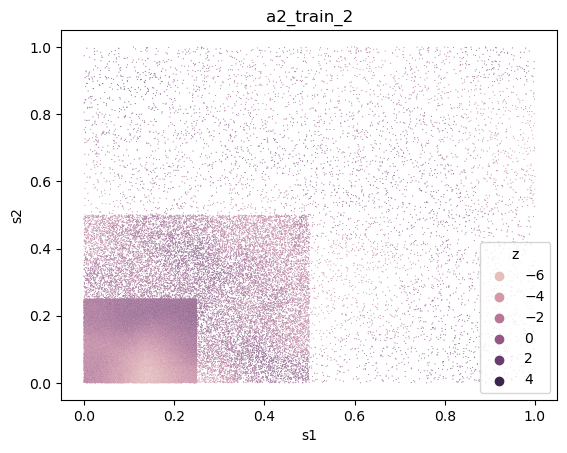

In [95]:
ax = sns.scatterplot(data=df, x='s1', y='s2', hue='z', s=0.5)
ax.set_title("a2_train_2")

<AxesSubplot:xlabel='z', ylabel='Density'>

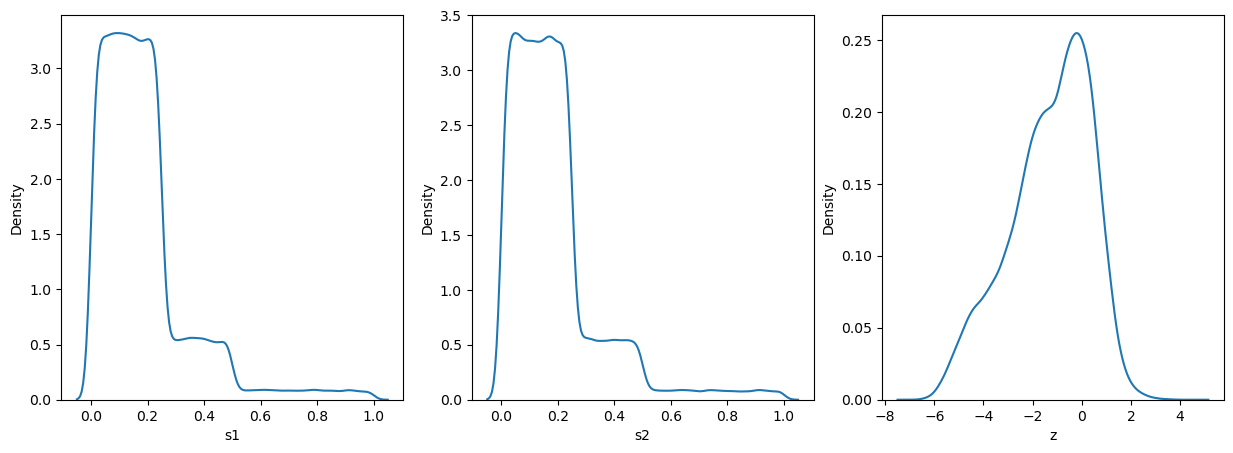

In [96]:
fig,axes = plt.subplots(1,3, figsize=(15,5))
sns.kdeplot(data=df, x='s1', ax=axes[0])
sns.kdeplot(data=df, x='s2', ax=axes[1])
sns.kdeplot(data=df, x='z', ax=axes[2])

# a2_train_3

In [97]:
#| hide
fp = opt.a2_train_3
df = pd.read_csv(fp)

Text(0.5, 1.0, 'a2_train_3')

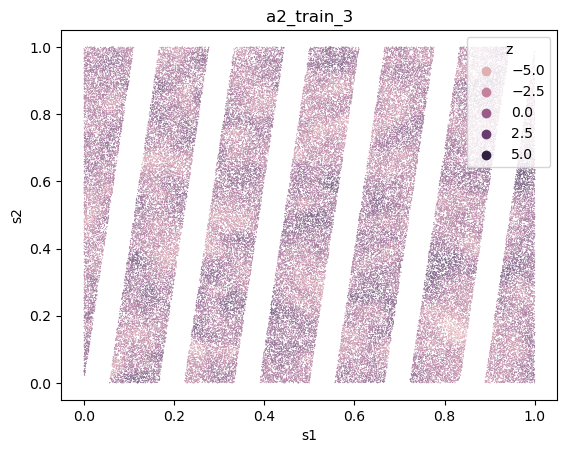

In [98]:
ax = sns.scatterplot(data=df, x='s1', y='s2', hue='z', s=0.5)
ax.set_title("a2_train_3")

<AxesSubplot:xlabel='z', ylabel='Density'>

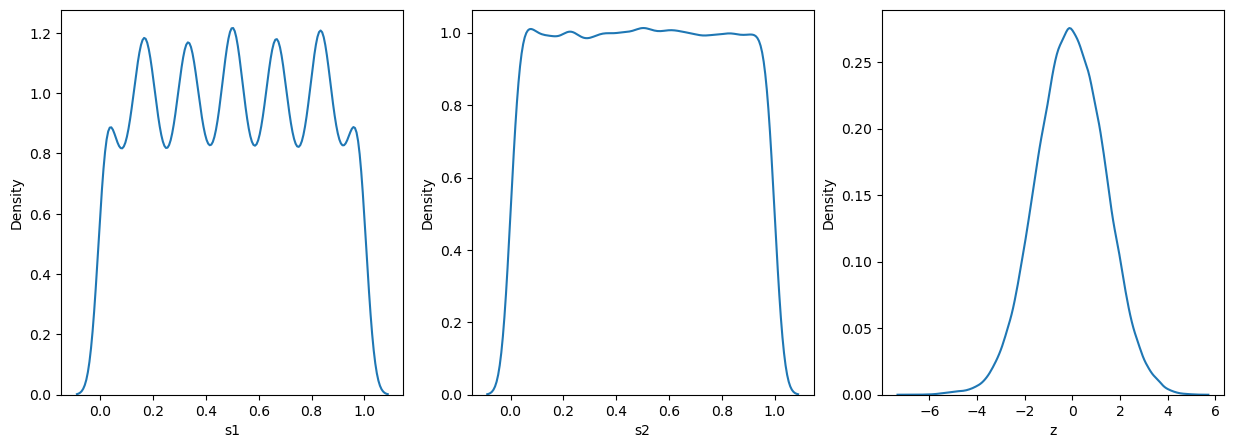

In [99]:
fig,axes = plt.subplots(1,3, figsize=(15,5))
sns.kdeplot(data=df, x='s1', ax=axes[0])
sns.kdeplot(data=df, x='s2', ax=axes[1])
sns.kdeplot(data=df, x='z', ax=axes[2])

# a2_train_4

In [100]:
#| hide
fp = opt.a2_train_4
df = pd.read_csv(fp)

Text(0.5, 1.0, 'a2_train_4')

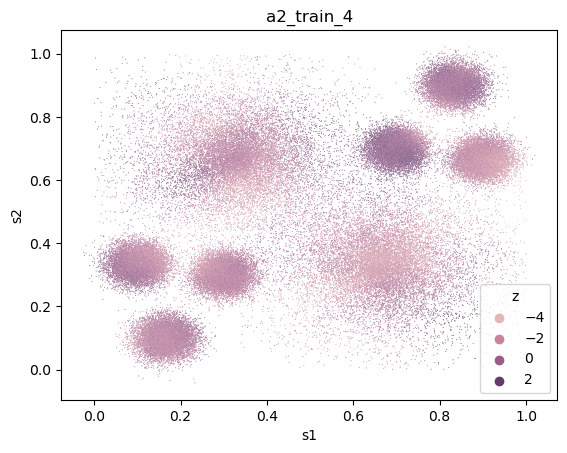

In [101]:
ax = sns.scatterplot(data=df, x='s1', y='s2', hue='z', s=0.5)
ax.set_title("a2_train_4")

<AxesSubplot:xlabel='z', ylabel='Density'>

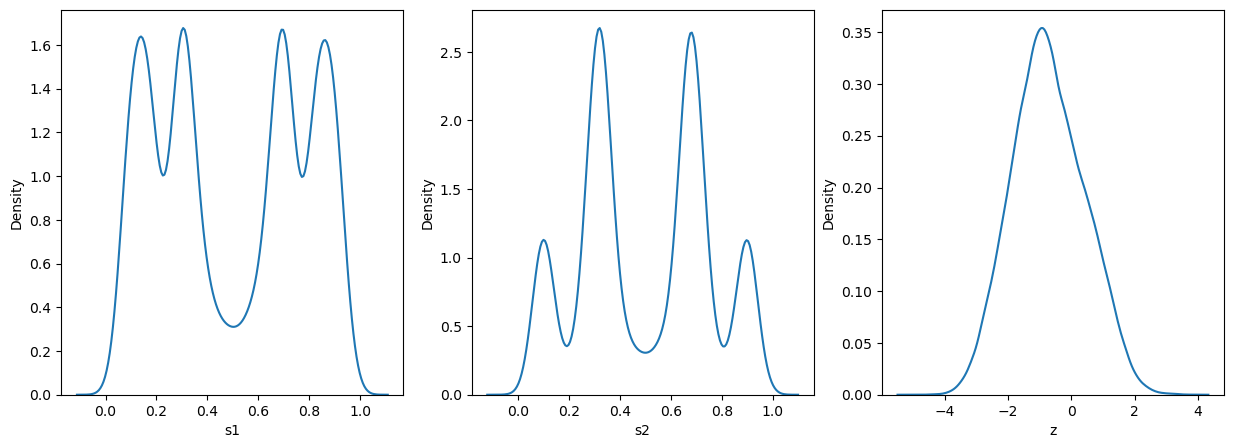

In [102]:
fig,axes = plt.subplots(1,3, figsize=(15,5))
sns.kdeplot(data=df, x='s1', ax=axes[0])
sns.kdeplot(data=df, x='s2', ax=axes[1])
sns.kdeplot(data=df, x='z', ax=axes[2])

# a2_train_5

In [103]:
#| hide
fp = opt.a2_train_5
df = pd.read_csv(fp)

Text(0.5, 1.0, 'a2_train_5')

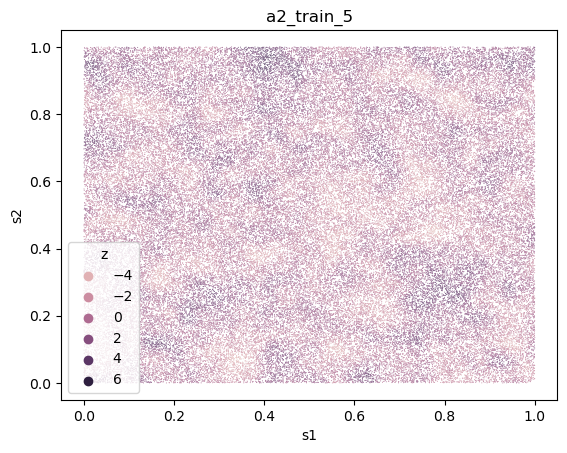

In [104]:
ax = sns.scatterplot(data=df, x='s1', y='s2', hue='z', s=0.5)
ax.set_title("a2_train_5")

<AxesSubplot:xlabel='z', ylabel='Density'>

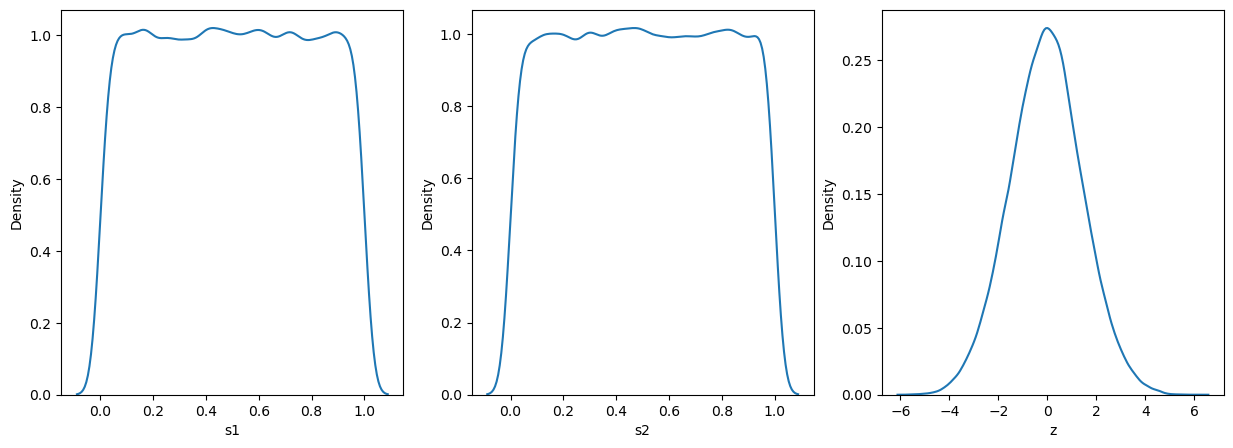

In [105]:
fig,axes = plt.subplots(1,3, figsize=(15,5))
sns.kdeplot(data=df, x='s1', ax=axes[0])
sns.kdeplot(data=df, x='s2', ax=axes[1])
sns.kdeplot(data=df, x='z', ax=axes[2])

In [149]:
fp = opt.a2_train_5
df = pd.read_csv(fp)
inducing_points = torch.load("model/ip2000.pt").cpu()
varogram_dist = 0.2
records = train_standardGPMatern(df, varogram_dist, inducing_points, cuda=True, nu=2.5, lr=0.001, batch_size=200)

100%|█████████████████████████████████████████████████████| 25/25 [00:00<00:00, 8882.47it/s]


cross-validation:   0%|          | 0/25 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/397 [00:00<?, ?it/s]

test:   0%|          | 0/19 [00:00<?, ?it/s]

Test, MAE: 1.1999367475509644 ,  ACC: 0.8744850315847295, train:79272, test:3641


Minibatch:   0%|          | 0/379 [00:00<?, ?it/s]

test:   0%|          | 0/18 [00:00<?, ?it/s]

Test, MAE: 1.237475872039795 ,  ACC: 0.8363687307369011, train:75672, test:3569


Minibatch:   0%|          | 0/378 [00:00<?, ?it/s]

test:   0%|          | 0/19 [00:00<?, ?it/s]

Test, MAE: 1.5012708902359009 ,  ACC: 0.687862869781587, train:75565, test:3617


Minibatch:   0%|          | 0/379 [00:00<?, ?it/s]

test:   0%|          | 0/18 [00:00<?, ?it/s]

Test, MAE: 1.351409673690796 ,  ACC: 0.7754010695187166, train:75693, test:3553


Minibatch:   0%|          | 0/397 [00:00<?, ?it/s]

test:   0%|          | 0/19 [00:00<?, ?it/s]

Test, MAE: 1.5826292037963867 ,  ACC: 0.7346825616856113, train:79269, test:3607


Minibatch:   0%|          | 0/379 [00:00<?, ?it/s]

test:   0%|          | 0/18 [00:00<?, ?it/s]

Test, MAE: 0.7886456847190857 ,  ACC: 0.9064809550881182, train:75758, test:3518


Minibatch:   0%|          | 0/361 [00:00<?, ?it/s]

test:   0%|          | 0/18 [00:00<?, ?it/s]

Test, MAE: 1.3166437149047852 ,  ACC: 0.800628391888032, train:72124, test:3501


Minibatch:   0%|          | 0/360 [00:00<?, ?it/s]

test:   0%|          | 0/19 [00:00<?, ?it/s]

Test, MAE: 0.9493967294692993 ,  ACC: 0.913961038961039, train:71972, test:3696


Minibatch:   0%|          | 0/361 [00:00<?, ?it/s]

test:   0%|          | 0/18 [00:00<?, ?it/s]

Test, MAE: 0.9634063839912415 ,  ACC: 0.9345609065155808, train:72012, test:3530


Minibatch:   0%|          | 0/378 [00:00<?, ?it/s]

test:   0%|          | 0/18 [00:00<?, ?it/s]

Test, MAE: 0.6700118184089661 ,  ACC: 0.95715485858303, train:75594, test:3571


Minibatch:   0%|          | 0/380 [00:00<?, ?it/s]

test:   0%|          | 0/18 [00:00<?, ?it/s]

Test, MAE: 0.5837177634239197 ,  ACC: 0.9586823003908431, train:75826, test:3582


Minibatch:   0%|          | 0/360 [00:00<?, ?it/s]

test:   0%|          | 0/18 [00:00<?, ?it/s]

Test, MAE: 0.674630343914032 ,  ACC: 0.9437639198218263, train:71900, test:3592


Minibatch:   0%|          | 0/360 [00:00<?, ?it/s]

test:   0%|          | 0/19 [00:00<?, ?it/s]

Test, MAE: 0.6978268623352051 ,  ACC: 0.9343105320304017, train:71893, test:3684


Minibatch:   0%|          | 0/360 [00:00<?, ?it/s]

test:   0%|          | 0/19 [00:00<?, ?it/s]

Test, MAE: 0.7911696434020996 ,  ACC: 0.934304562946674, train:71828, test:3638


Minibatch:   0%|          | 0/378 [00:00<?, ?it/s]

test:   0%|          | 0/19 [00:00<?, ?it/s]

Test, MAE: 0.632330596446991 ,  ACC: 0.9548404542996214, train:75434, test:3698


Minibatch:   0%|          | 0/378 [00:00<?, ?it/s]

test:   0%|          | 0/18 [00:00<?, ?it/s]

Test, MAE: 0.5639134049415588 ,  ACC: 0.9623779437105112, train:75591, test:3482


Minibatch:   0%|          | 0/361 [00:00<?, ?it/s]

test:   0%|          | 0/19 [00:00<?, ?it/s]

Test, MAE: 0.6337780356407166 ,  ACC: 0.9382518043303929, train:72140, test:3741


Minibatch:   0%|          | 0/360 [00:00<?, ?it/s]

test:   0%|          | 0/18 [00:00<?, ?it/s]

Test, MAE: 0.6889488101005554 ,  ACC: 0.9608235630540464, train:71831, test:3497


Minibatch:   0%|          | 0/360 [00:00<?, ?it/s]

test:   0%|          | 0/19 [00:00<?, ?it/s]

Test, MAE: 0.6168388724327087 ,  ACC: 0.9538928768636112, train:71998, test:3622


Minibatch:   0%|          | 0/377 [00:00<?, ?it/s]

test:   0%|          | 0/19 [00:00<?, ?it/s]

Test, MAE: 0.7015589475631714 ,  ACC: 0.9502596337797212, train:75382, test:3659


Minibatch:   0%|          | 0/397 [00:00<?, ?it/s]

test:   0%|          | 0/19 [00:00<?, ?it/s]

Test, MAE: 0.5656920075416565 ,  ACC: 0.9489456159822419, train:79366, test:3604


Minibatch:   0%|          | 0/378 [00:00<?, ?it/s]

test:   0%|          | 0/18 [00:00<?, ?it/s]

Test, MAE: 0.5364857912063599 ,  ACC: 0.9489853438556933, train:75482, test:3548


Minibatch:   0%|          | 0/379 [00:00<?, ?it/s]

test:   0%|          | 0/19 [00:00<?, ?it/s]

Test, MAE: 0.5537458062171936 ,  ACC: 0.9622068965517241, train:75744, test:3625


Minibatch:   0%|          | 0/378 [00:00<?, ?it/s]

test:   0%|          | 0/18 [00:00<?, ?it/s]

Test, MAE: 0.6526588797569275 ,  ACC: 0.9495259341885108, train:75528, test:3586


Minibatch:   0%|          | 0/396 [00:00<?, ?it/s]

test:   0%|          | 0/19 [00:00<?, ?it/s]

Test, MAE: 0.6055757403373718 ,  ACC: 0.9444902445726848, train:79116, test:3639


In [150]:
test_records(df, inducing_points, records, cuda=True)

verify:   0%|          | 0/25 [00:00<?, ?it/s]

0: mae: 1.1999367475509644, acc: 0.8744850315847295
1: mae: 1.237475872039795, acc: 0.8363687307369011
2: mae: 1.5012708902359009, acc: 0.687862869781587
3: mae: 1.351409673690796, acc: 0.7754010695187166
4: mae: 1.5826292037963867, acc: 0.7346825616856113
5: mae: 0.7886456847190857, acc: 0.9064809550881182
num:86731, acc:0.9636777777777777, mae:0.5513302683830261
6: mae: 1.3166437149047852, acc: 0.800628391888032
7: mae: 0.9493967294692993, acc: 0.913961038961039
num:86731, acc:0.9636777777777777, mae:0.5513302683830261
8: mae: 0.9634063839912415, acc: 0.9345609065155808
num:86731, acc:0.9636777777777777, mae:0.5513302683830261
9: mae: 0.6700118184089661, acc: 0.95715485858303
num:86731, acc:0.9636777777777777, mae:0.5513302683830261
10: mae: 0.5837177634239197, acc: 0.9586823003908431
num:86731, acc:0.9636777777777777, mae:0.5513302683830261
11: mae: 0.674630343914032, acc: 0.9437639198218263
num:86731, acc:0.9636777777777777, mae:0.5513302683830261
12: mae: 0.6978268623352051, acc: 

In [151]:
mae = [x['mae'] for x in records]
mae = np.array(mae)
idx = mae.argmin()
print(f"ids:{idx}, mae:{mae[idx]}")

ids:21, mae:0.5364857912063599


In [152]:
idx=21
fp=f"model/a2_train_5_scv"
fp_ = f"{fp}_mae_acc.pth"
state_dict = records[idx]['param']
torch.save(state_dict, fp_)

# a2_test2_1

In [90]:
#| hide
fp = opt.a2_test2_1
df = pd.read_csv(fp,header=None)
df.columns=['s1','s2']

Text(0.5, 1.0, 'a2_test2_1')

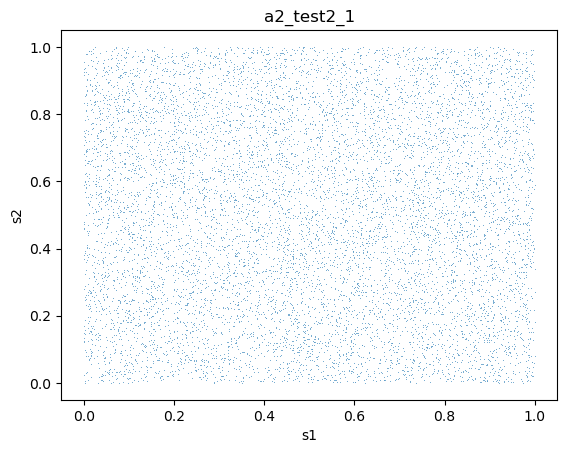

In [92]:
ax = sns.scatterplot(data=df, x='s1', y='s2',s=0.5)
ax.set_title("a2_test2_1")

<AxesSubplot:xlabel='s2', ylabel='Density'>

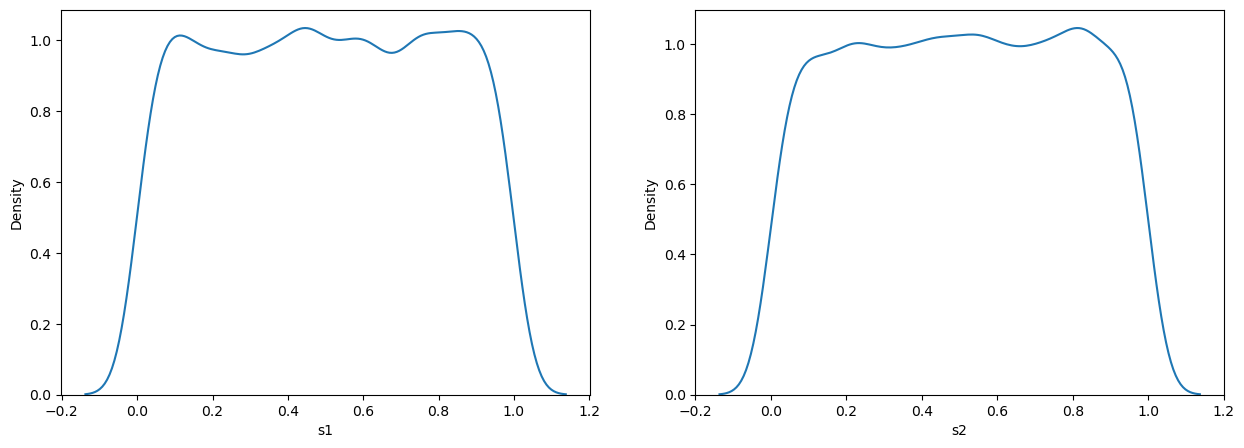

In [93]:
fig,axes = plt.subplots(1,2, figsize=(15,5))
sns.kdeplot(data=df, x='s1', ax=axes[0])
sns.kdeplot(data=df, x='s2', ax=axes[1])

## Predict

In [181]:
fp = opt.a2_test2_1
df = pd.read_csv(fp,header=None)
inducing_points = torch.load("model/ip2000.pt").cpu()
state_dict = torch.load(opt.fp_a25)
model = StandardApproximateGP_mat(inducing_points=inducing_points, nu=2.5)
model.load_state_dict(state_dict)
df = lht_predict(df,model)

df.head()

0         1        LB        UB
0  0.690520  0.611197 -1.159604  2.291035
1  0.655058  0.931481 -3.034902  0.269298
2  0.020526  0.682813  0.578537  3.027881
3  0.677271  0.366807 -0.513351  2.405897
4  0.553282  0.728161 -2.322962  0.933410

In [182]:
fn = "/home/hxl170008/code/KAUST/out/TeamName-2a-Train5_Test2_1.csv"
df.to_csv(fn, index=False, header=['x','y','lp','up'])
pd.read_csv(fn).head()

x         y        lp        up
0  0.690520  0.611197 -1.159604  2.291035
1  0.655058  0.931481 -3.034902  0.269298
2  0.020526  0.682813  0.578537  3.027881
3  0.677271  0.366807 -0.513351  2.405897
4  0.553282  0.728161 -2.322962  0.933410

# a2_test2_2

In [106]:
#| hide
fp = opt.a2_test2_2
df = pd.read_csv(fp,header=None)
df.columns=['s1','s2']

Text(0.5, 1.0, 'a2_test2_2')

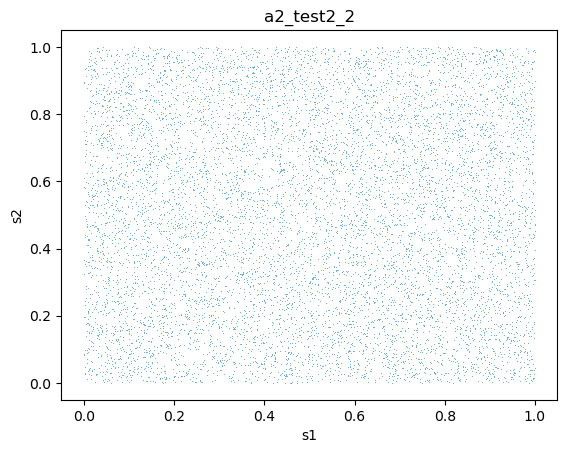

In [107]:
ax = sns.scatterplot(data=df, x='s1', y='s2',s=0.5)
ax.set_title("a2_test2_2")

<AxesSubplot:xlabel='s2', ylabel='Density'>

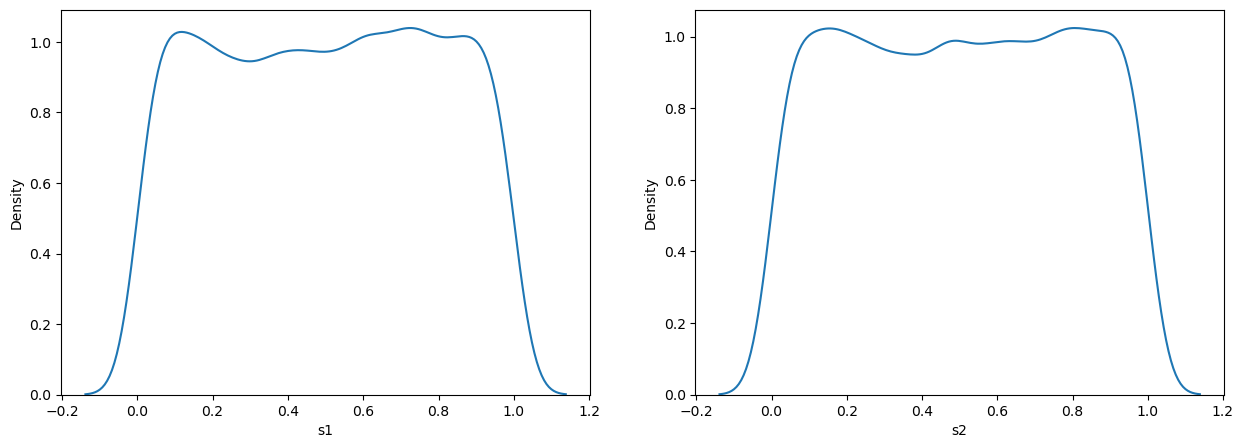

In [108]:
fig,axes = plt.subplots(1,2, figsize=(15,5))
sns.kdeplot(data=df, x='s1', ax=axes[0])
sns.kdeplot(data=df, x='s2', ax=axes[1])

## Predict

In [183]:
fp = opt.a2_test2_2
df = pd.read_csv(fp,header=None)
inducing_points = torch.load("model/ip2000.pt").cpu()
state_dict = torch.load(opt.fp_a25)
model = StandardApproximateGP_mat(inducing_points=inducing_points, nu=2.5)
model.load_state_dict(state_dict)
df = lht_predict(df,model)

df.head()

0         1        LB        UB
0  0.877177  0.739204 -1.764420  1.122274
1  0.275321  0.038020 -1.850923  0.729629
2  0.764872  0.620129 -4.511827 -1.132622
3  0.826718  0.400088 -1.226114  1.559114
4  0.686438  0.077591 -1.698220  0.626777

In [184]:
fn = "/home/hxl170008/code/KAUST/out/TeamName-2a-Train5_Test2_2.csv"
df.to_csv(fn, index=False, header=['x','y','lp','up'])
pd.read_csv(fn).head()

x         y        lp        up
0  0.877177  0.739204 -1.764420  1.122274
1  0.275321  0.038020 -1.850923  0.729629
2  0.764872  0.620129 -4.511827 -1.132622
3  0.826718  0.400088 -1.226114  1.559114
4  0.686438  0.077591 -1.698220  0.626777

# a2_test2_3

In [109]:
#| hide
fp = opt.a2_test2_3
df = pd.read_csv(fp,header=None)
df.columns=['s1','s2']

Text(0.5, 1.0, 'a2_test2_3')

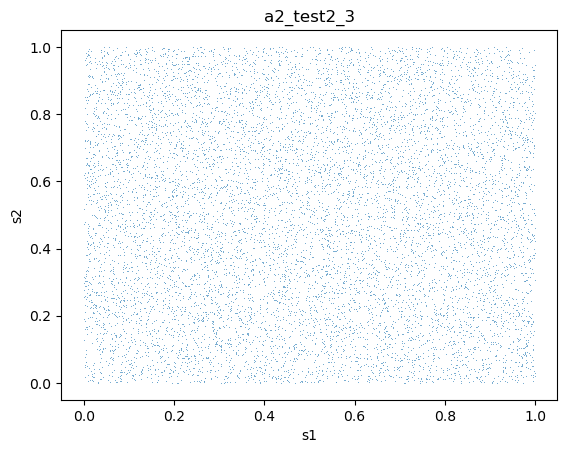

In [110]:
ax = sns.scatterplot(data=df, x='s1', y='s2',s=0.5)
ax.set_title("a2_test2_3")

<AxesSubplot:xlabel='s2', ylabel='Density'>

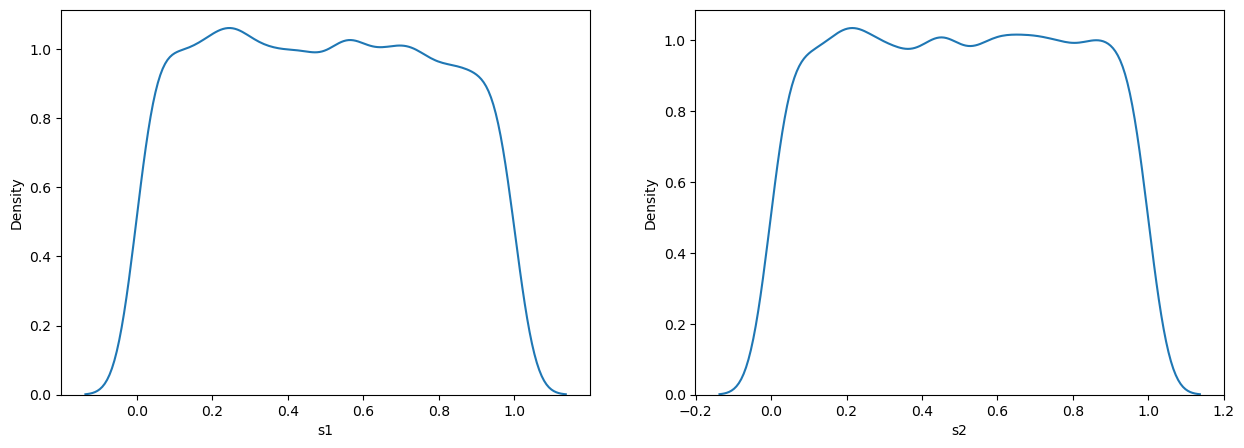

In [111]:
fig,axes = plt.subplots(1,2, figsize=(15,5))
sns.kdeplot(data=df, x='s1', ax=axes[0])
sns.kdeplot(data=df, x='s2', ax=axes[1])

## Predict

In [185]:
fp = opt.a2_test2_3
df = pd.read_csv(fp,header=None)
inducing_points = torch.load("model/ip2000.pt").cpu()
state_dict = torch.load(opt.fp_a25)
model = StandardApproximateGP_mat(inducing_points=inducing_points, nu=2.5)
model.load_state_dict(state_dict)
df = lht_predict(df,model)

df.head()

0         1        LB        UB
0  0.084431  0.985007  0.478878  2.669842
1  0.167808  0.806780 -3.808693 -0.527201
2  0.537291  0.759608 -3.163533  0.478689
3  0.790684  0.382705 -0.397716  2.155490
4  0.982029  0.731273 -2.547848  0.920116

In [186]:
fn = "/home/hxl170008/code/KAUST/out/TeamName-2a-Train5_Test2_3.csv"
df.to_csv(fn, index=False, header=['x','y','lp','up'])
pd.read_csv(fn).head()

x         y        lp        up
0  0.084431  0.985007  0.478878  2.669842
1  0.167808  0.806780 -3.808693 -0.527201
2  0.537291  0.759608 -3.163533  0.478689
3  0.790684  0.382705 -0.397716  2.155490
4  0.982029  0.731273 -2.547848  0.920116

# a2_test2_4

In [112]:
#| hide
fp = opt.a2_test2_4
df = pd.read_csv(fp,header=None)
df.columns=['s1','s2']

Text(0.5, 1.0, 'a2_test2_4')

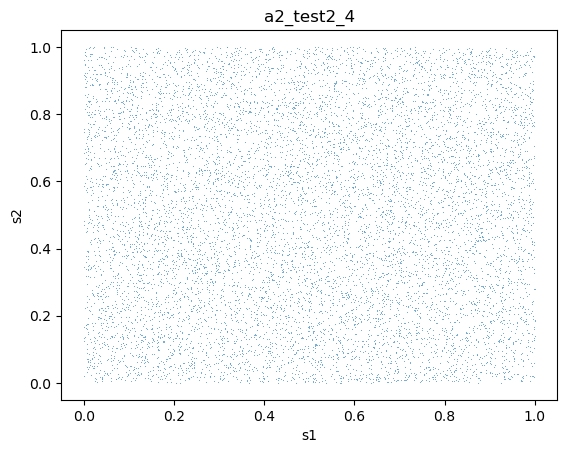

In [113]:
ax = sns.scatterplot(data=df, x='s1', y='s2',s=0.5)
ax.set_title("a2_test2_4")

<AxesSubplot:xlabel='s2', ylabel='Density'>

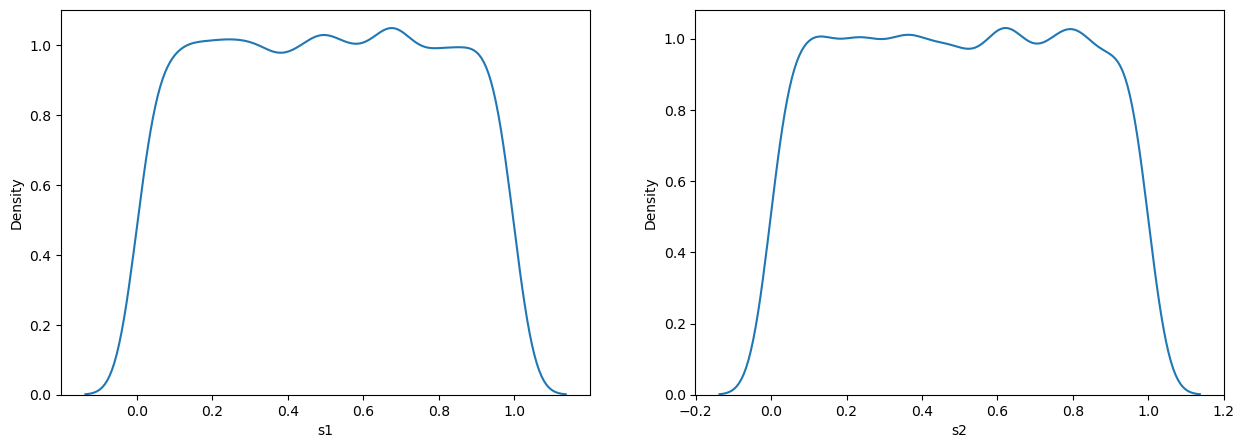

In [114]:
fig,axes = plt.subplots(1,2, figsize=(15,5))
sns.kdeplot(data=df, x='s1', ax=axes[0])
sns.kdeplot(data=df, x='s2', ax=axes[1])

## Predict

In [187]:
fp = opt.a2_test2_4
df = pd.read_csv(fp,header=None)
inducing_points = torch.load("model/ip2000.pt").cpu()
state_dict = torch.load(opt.fp_a25)
model = StandardApproximateGP_mat(inducing_points=inducing_points, nu=2.5)
model.load_state_dict(state_dict)
df = lht_predict(df,model)

df.head()

0         1        LB        UB
0  0.710538  0.298020 -1.605919  1.823085
1  0.778819  0.044015 -2.245159  0.045392
2  0.590780  0.366332 -2.414379  1.177433
3  0.267325  0.069466 -3.007783 -0.462943
4  0.344156  0.250287 -0.589531  2.767131

In [188]:
fn = "/home/hxl170008/code/KAUST/out/TeamName-2a-Train5_Test2_4.csv"
df.to_csv(fn, index=False, header=['x','y','lp','up'])
pd.read_csv(fn).head()

x         y        lp        up
0  0.710538  0.298020 -1.605919  1.823085
1  0.778819  0.044015 -2.245159  0.045392
2  0.590780  0.366332 -2.414379  1.177433
3  0.267325  0.069466 -3.007783 -0.462943
4  0.344156  0.250287 -0.589531  2.767131

# a2_test2_5

In [115]:
#| hide
fp = opt.a2_test2_5
df = pd.read_csv(fp,header=None)
df.columns=['s1','s2']

Text(0.5, 1.0, 'a2_test2_5')

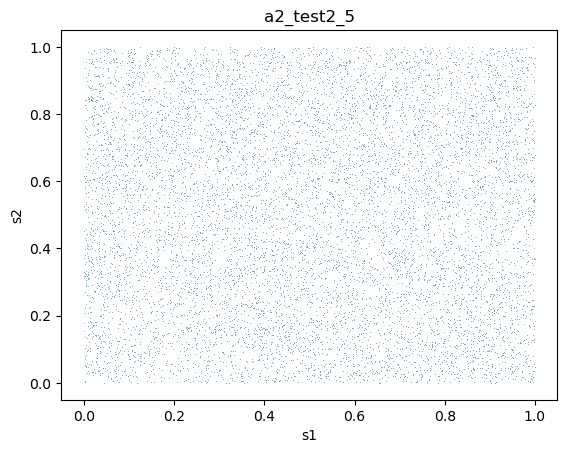

In [116]:
ax = sns.scatterplot(data=df, x='s1', y='s2',s=0.5)
ax.set_title("a2_test2_5")

<AxesSubplot:xlabel='s2', ylabel='Density'>

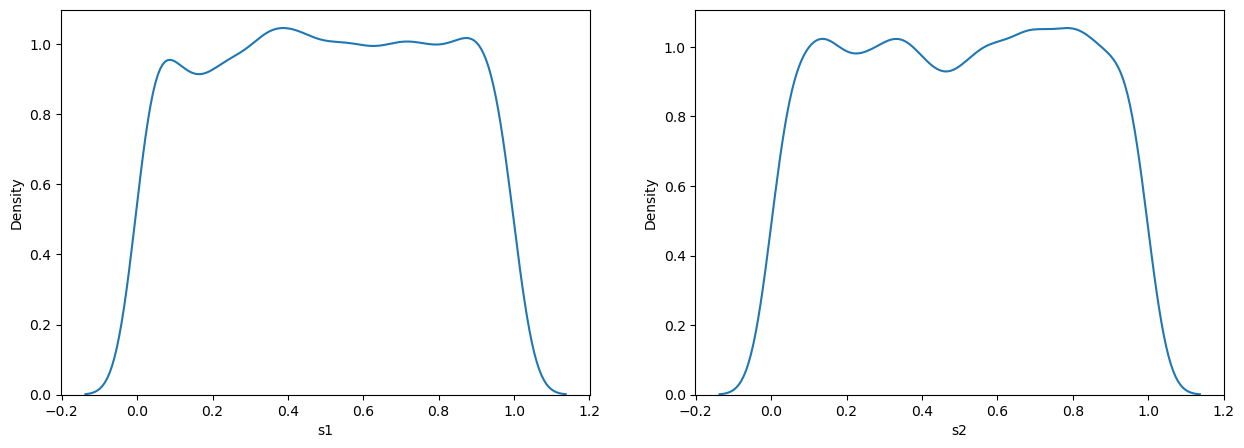

In [117]:
fig,axes = plt.subplots(1,2, figsize=(15,5))
sns.kdeplot(data=df, x='s1', ax=axes[0])
sns.kdeplot(data=df, x='s2', ax=axes[1])

## Predict

In [189]:
fp = opt.a2_test2_5
df = pd.read_csv(fp,header=None)
inducing_points = torch.load("model/ip2000.pt").cpu()
state_dict = torch.load(opt.fp_a25)
model = StandardApproximateGP_mat(inducing_points=inducing_points, nu=2.5)
model.load_state_dict(state_dict)
df = lht_predict(df,model)

df.head()

0         1        LB        UB
0  0.455578  0.851488 -0.153300  2.522883
1  0.297932  0.956306 -0.026492  2.070296
2  0.554679  0.207566 -1.789738  1.076121
3  0.283139  0.257260  1.116230  4.336212
4  0.694558  0.521774 -3.344720 -0.088444

In [190]:
fn = "/home/hxl170008/code/KAUST/out/TeamName-2a-Train5_Test2_5.csv"
df.to_csv(fn, index=False, header=['x','y','lp','up'])
pd.read_csv(fn).head()

x         y        lp        up
0  0.455578  0.851488 -0.153300  2.522883
1  0.297932  0.956306 -0.026492  2.070296
2  0.554679  0.207566 -1.789738  1.076121
3  0.283139  0.257260  1.116230  4.336212
4  0.694558  0.521774 -3.344720 -0.088444

# a2_test1_1

In [118]:
#| hide
fp = opt.a2_test1_1
df = pd.read_csv(fp,header=None)
df.columns=['s1','s2']

Text(0.5, 1.0, 'a2_test1_1')

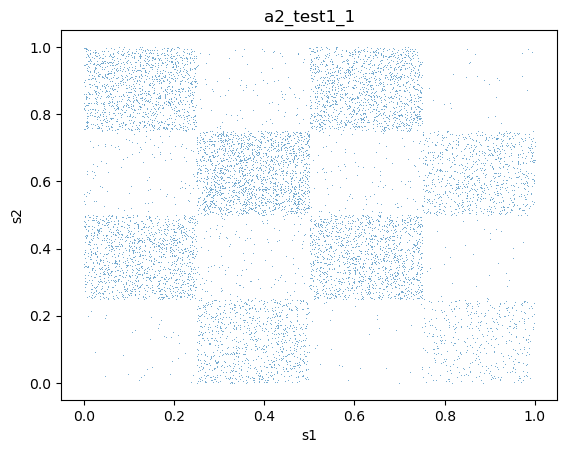

In [119]:
ax = sns.scatterplot(data=df, x='s1', y='s2',s=0.5)
ax.set_title("a2_test1_1")

<AxesSubplot:xlabel='s2', ylabel='Density'>

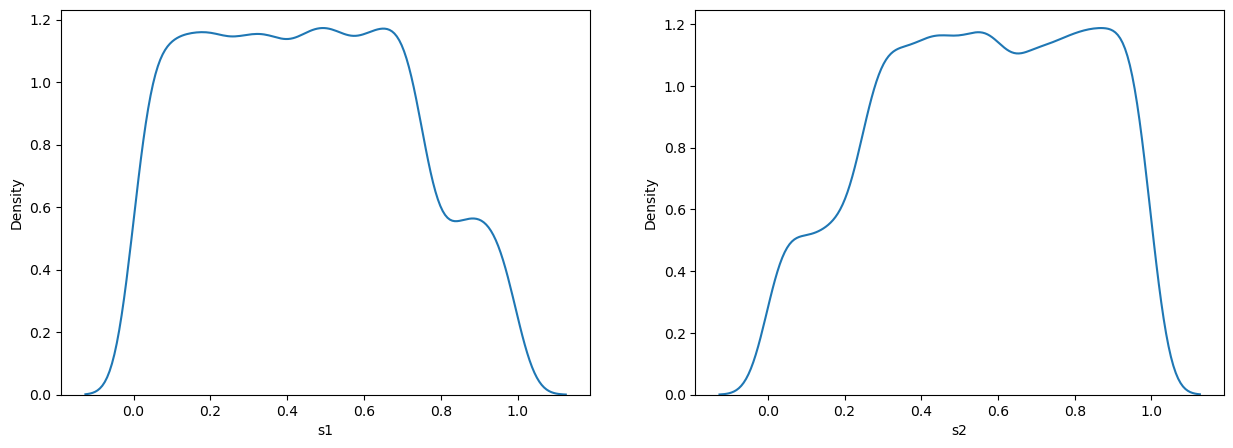

In [120]:
fig,axes = plt.subplots(1,2, figsize=(15,5))
sns.kdeplot(data=df, x='s1', ax=axes[0])
sns.kdeplot(data=df, x='s2', ax=axes[1])

In [169]:
def lht_predict(df, model, cuda=True):
    points = df.to_numpy()
    a = torch.from_numpy(points).float()
    model.eval()
    if cuda:
        model = model.cuda()
        a = a.cuda()
    else:
        model = model.cpu()
    preds = model(a.cuda())

    l,v = preds.loc.cpu().detach().numpy(), preds.stddev.cpu().detach().numpy()
    ci_a2_test_1 = norm.interval(0.95, loc=l, scale=v)

    LB,UB = ci_a2_test_1
    df['LB'] = LB
    df['UB'] = UB
    return df

## Predict

In [175]:
fp = opt.a2_test1_1
df = pd.read_csv(fp,header=None)
inducing_points = torch.load("model/ip2000.pt").cpu()
state_dict = torch.load(opt.fp_a21)
model = StandardApproximateGP_mat(inducing_points=inducing_points, nu=2.5)
model.load_state_dict(state_dict)
df = lht_predict(df,model)

df.head()

0         1        LB        UB
0  0.406962  0.580996 -3.112965 -1.478097
1  0.011528  0.834209 -2.087649 -0.229802
2  0.195961  0.770862 -1.799855  0.188151
3  0.382067  0.639591 -3.109370 -1.349418
4  0.214293  0.291520 -3.195559 -1.437936

In [176]:
fn = "/home/hxl170008/code/KAUST/out/TeamName-2a-Train1_Test1_1.csv"
df.to_csv(fn, index=False, header=['x','y','lp','up'])
pd.read_csv(fn).head()

x         y        lp        up
0  0.406962  0.580996 -3.112965 -1.478097
1  0.011528  0.834209 -2.087649 -0.229802
2  0.195961  0.770862 -1.799855  0.188151
3  0.382067  0.639591 -3.109370 -1.349418
4  0.214293  0.291520 -3.195559 -1.437936

# a2_test1_2

In [121]:
#| hide
fp = opt.a2_test1_2
df = pd.read_csv(fp,header=None)
df.columns=['s1','s2']

Text(0.5, 1.0, 'a2_test1_2')

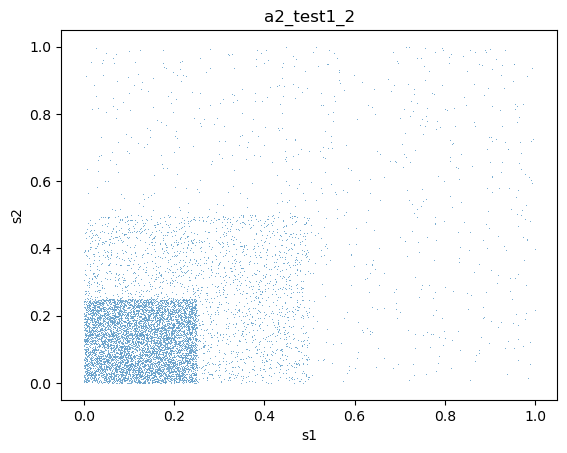

In [122]:
ax = sns.scatterplot(data=df, x='s1', y='s2',s=0.5)
ax.set_title("a2_test1_2")

<AxesSubplot:xlabel='s2', ylabel='Density'>

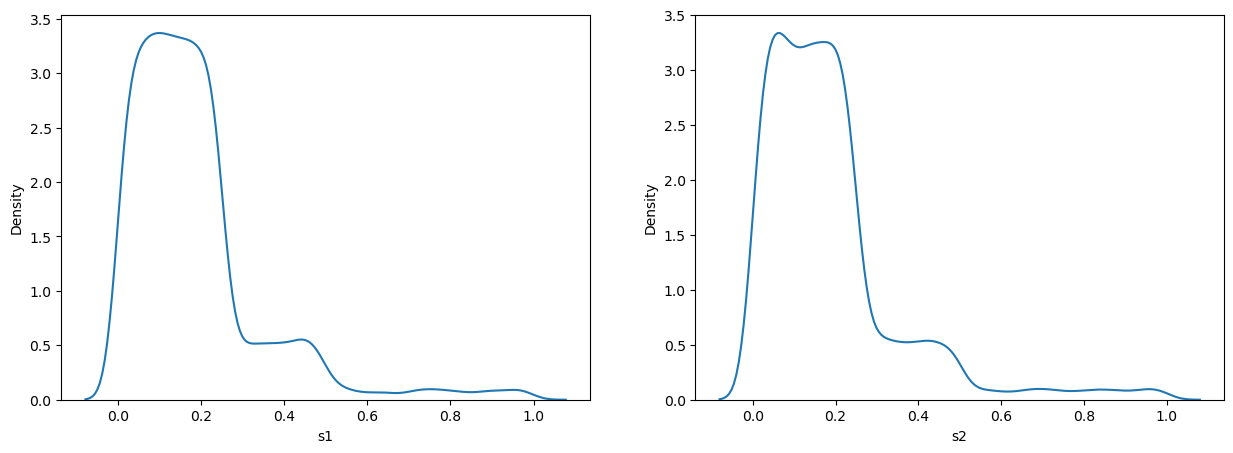

In [123]:
fig,axes = plt.subplots(1,2, figsize=(15,5))
sns.kdeplot(data=df, x='s1', ax=axes[0])
sns.kdeplot(data=df, x='s2', ax=axes[1])

## Predict

In [173]:
fp = opt.a2_test1_2
df = pd.read_csv(fp,header=None)
inducing_points = torch.load("model/ip2000.pt").cpu()
state_dict = torch.load(opt.fp_a22)
model = StandardApproximateGP_mat(inducing_points=inducing_points, nu=2.5)
model.load_state_dict(state_dict)
df = lht_predict(df,model)
df.head()

0         1        LB        UB
0  0.013625  0.452669 -3.449143 -0.480362
1  0.204987  0.185146 -0.660584  1.125424
2  0.209591  0.152154 -1.360003  0.361739
3  0.146731  0.215868 -0.440305  1.289257
4  0.073555  0.159711 -1.843506  0.372731

In [174]:
fn = "/home/hxl170008/code/KAUST/out/TeamName-2a-Train2_Test1_2.csv"
df.to_csv(fn, index=False, header=['x','y','lp','up'])
pd.read_csv(fn).head()

x         y        lp        up
0  0.013625  0.452669 -3.449143 -0.480362
1  0.204987  0.185146 -0.660584  1.125424
2  0.209591  0.152154 -1.360003  0.361739
3  0.146731  0.215868 -0.440305  1.289257
4  0.073555  0.159711 -1.843506  0.372731

# a2_test1_3

In [124]:
#| hide
fp = opt.a2_test1_3
df = pd.read_csv(fp,header=None)
df.columns=['s1','s2']

Text(0.5, 1.0, 'a2_test1_3')

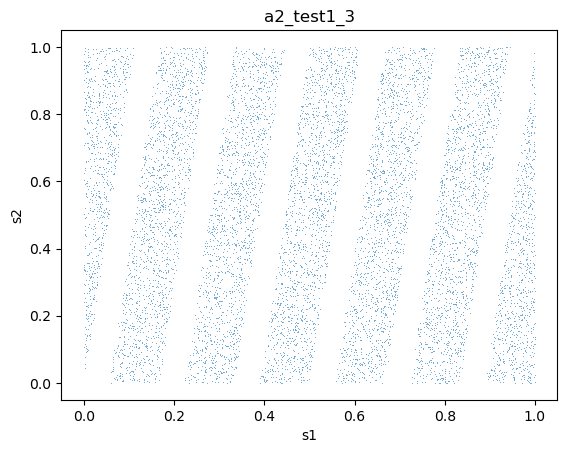

In [125]:
ax = sns.scatterplot(data=df, x='s1', y='s2',s=0.5)
ax.set_title("a2_test1_3")

<AxesSubplot:xlabel='s2', ylabel='Density'>

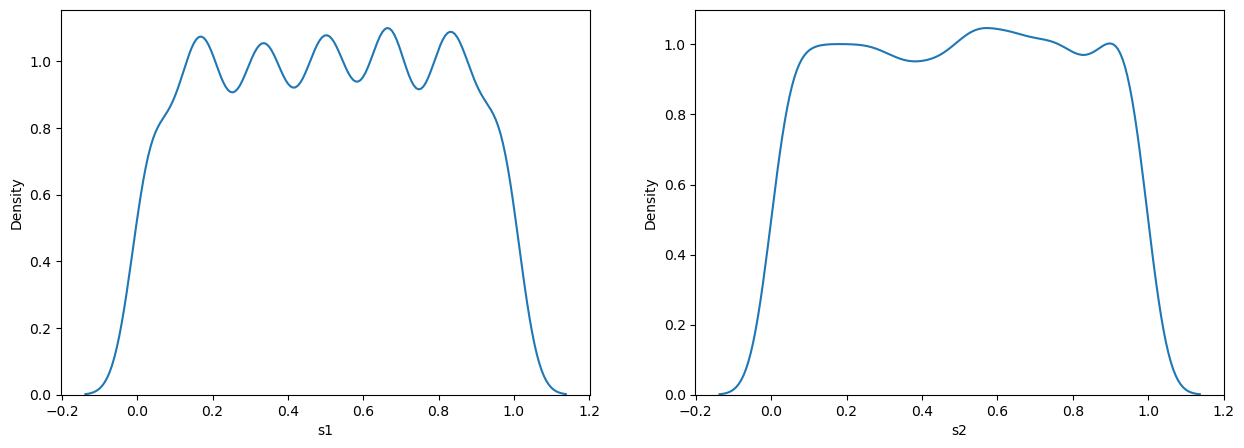

In [126]:
fig,axes = plt.subplots(1,2, figsize=(15,5))
sns.kdeplot(data=df, x='s1', ax=axes[0])
sns.kdeplot(data=df, x='s2', ax=axes[1])

## Predict

In [177]:
fp = opt.a2_test1_3
df = pd.read_csv(fp,header=None)
inducing_points = torch.load("model/ip2000.pt").cpu()
state_dict = torch.load(opt.fp_a23)
model = StandardApproximateGP_mat(inducing_points=inducing_points, nu=2.5)
model.load_state_dict(state_dict)
df = lht_predict(df,model)
df.head()

0         1        LB        UB
0  0.223545  0.567762 -0.826552  2.504238
1  0.180812  0.281796 -0.562687  2.186370
2  0.580535  0.207583 -1.947579  1.925615
3  0.350133  0.590877  0.049042  2.398759
4  0.874639  0.860059  1.264777  3.422351

In [178]:
fn = "/home/hxl170008/code/KAUST/out/TeamName-2a-Train3_Test1_3.csv"
df.to_csv(fn, index=False, header=['x','y','lp','up'])
pd.read_csv(fn).head()

x         y        lp        up
0  0.223545  0.567762 -0.826552  2.504238
1  0.180812  0.281796 -0.562687  2.186370
2  0.580535  0.207583 -1.947579  1.925615
3  0.350133  0.590877  0.049042  2.398759
4  0.874639  0.860059  1.264777  3.422351

# a2_test1_4

In [127]:
#| hide
fp = opt.a2_test1_4
df = pd.read_csv(fp,header=None)
df.columns=['s1','s2']

Text(0.5, 1.0, 'a2_test1_4')

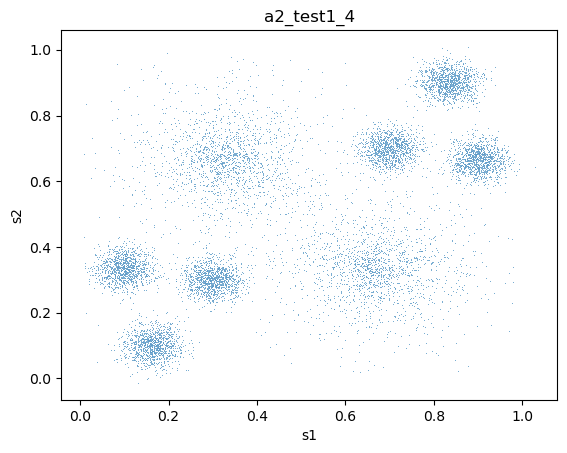

In [128]:
ax = sns.scatterplot(data=df, x='s1', y='s2',s=0.5)
ax.set_title("a2_test1_4")

<AxesSubplot:xlabel='s2', ylabel='Density'>

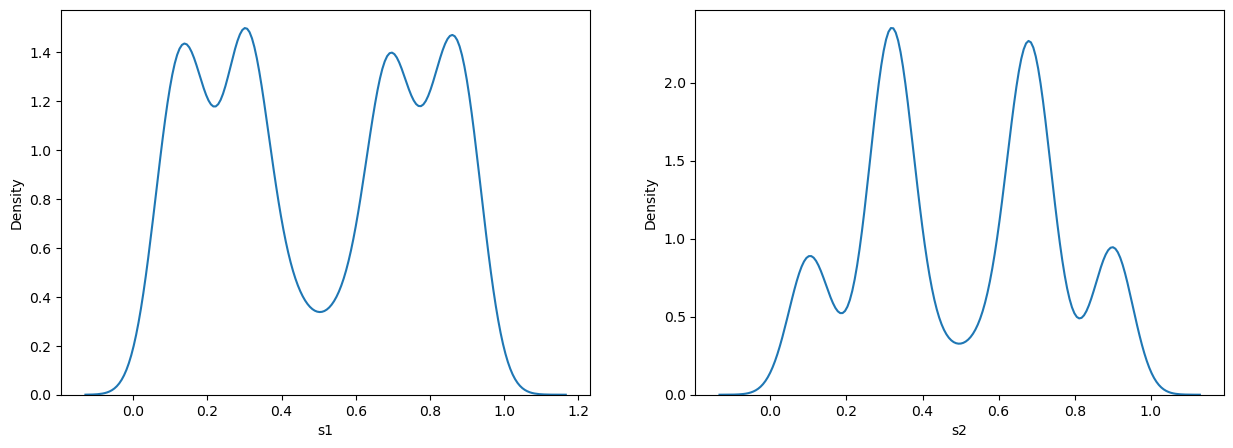

In [129]:
fig,axes = plt.subplots(1,2, figsize=(15,5))
sns.kdeplot(data=df, x='s1', ax=axes[0])
sns.kdeplot(data=df, x='s2', ax=axes[1])

## Predict

In [179]:
fp = opt.a2_test1_4
df = pd.read_csv(fp,header=None)
inducing_points = torch.load("model/ip2000.pt").cpu()
state_dict = torch.load(opt.fp_a24)
model = StandardApproximateGP_mat(inducing_points=inducing_points, nu=2.5)
model.load_state_dict(state_dict)
df = lht_predict(df,model)
df.head()

0         1        LB        UB
0  0.793265  0.880985 -1.006060  0.762768
1  0.094199  0.281715 -0.628438  1.270356
2  0.100491  0.304740 -1.038665  0.793025
3  0.754692  0.827618 -1.888831  0.180383
4  0.633524  0.666639 -0.119325  2.010319

In [180]:
fn = "/home/hxl170008/code/KAUST/out/TeamName-2a-Train4_Test1_4.csv"
df.to_csv(fn, index=False, header=['x','y','lp','up'])
pd.read_csv(fn).head()

x         y        lp        up
0  0.793265  0.880985 -1.006060  0.762768
1  0.094199  0.281715 -0.628438  1.270356
2  0.100491  0.304740 -1.038665  0.793025
3  0.754692  0.827618 -1.888831  0.180383
4  0.633524  0.666639 -0.119325  2.010319

# Kernel Estimation

In [81]:
prior = 'gamma'
model_paths = [opt.fp_a11,opt.fp_a12,opt.fp_a13,opt.fp_a14,opt.fp_a15]
inducing_points = torch.load("model/ip500.pt")
kerns = []
for fp in model_paths:
    state_dict = torch.load(fp)
    model = GP_AFirst(inducing_points,nu=1, max_tries=200,prior=prior)
    model.load_state_dict(state_dict)
    kern = model.covar_module.base_kernel
    kerns.append(kern)

matern:   0%|          | 0/5 [00:00<?, ?it/s]

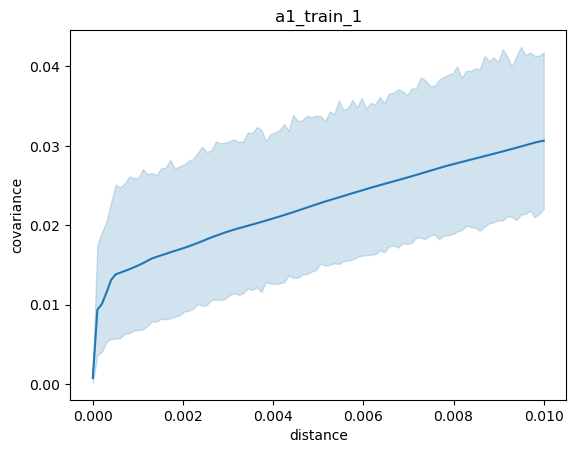

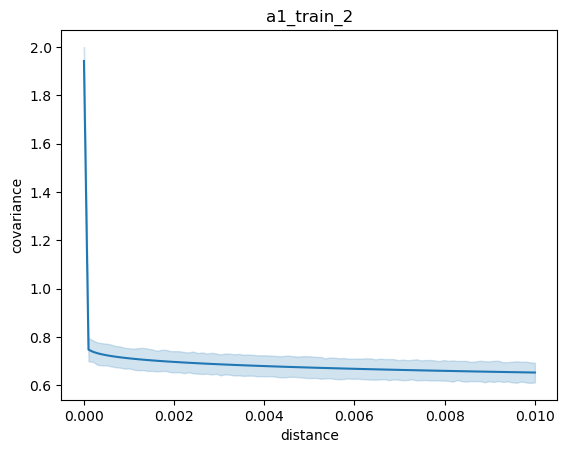

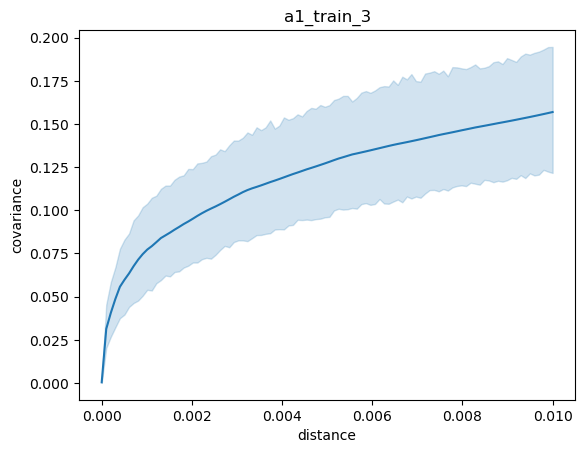

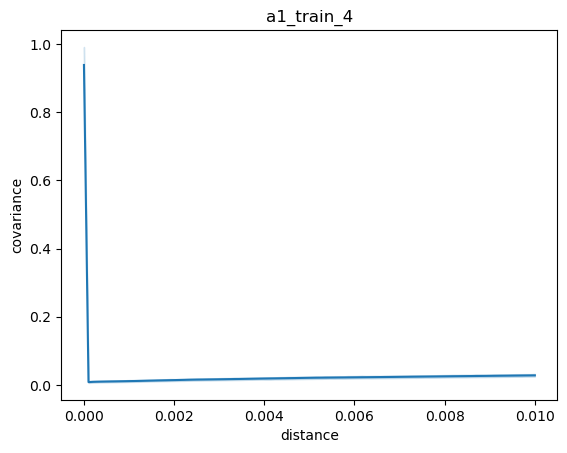

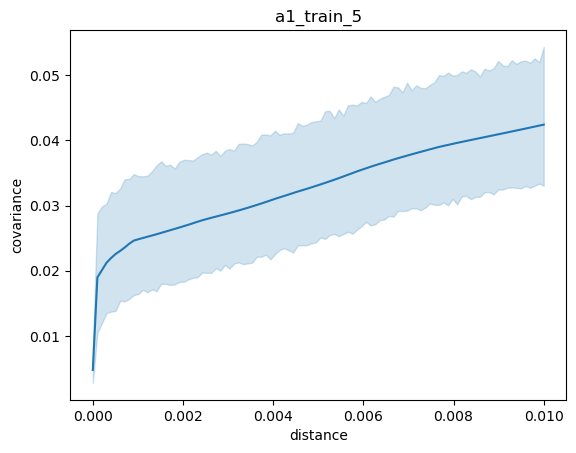

In [82]:
dist = torch.linspace(0,0.01,100)
miter = tqdm.notebook.tqdm(kerns, desc='matern')
for i,k in enumerate(miter):
    title = f'a1_train_{i+1}'
    lht_show_matern(k, title, dist)

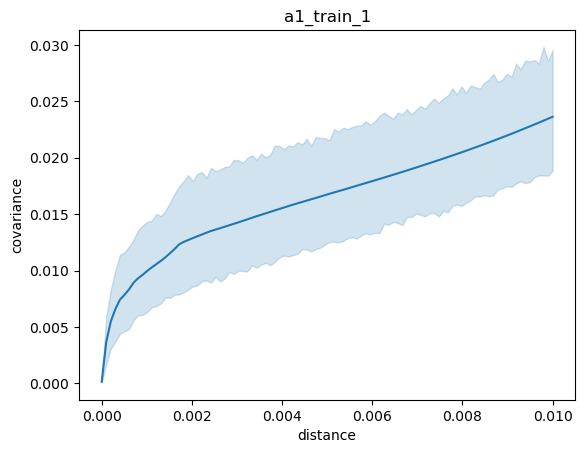

In [78]:
lht_show_matern(kerns[0], 'a1_train_1', dist)

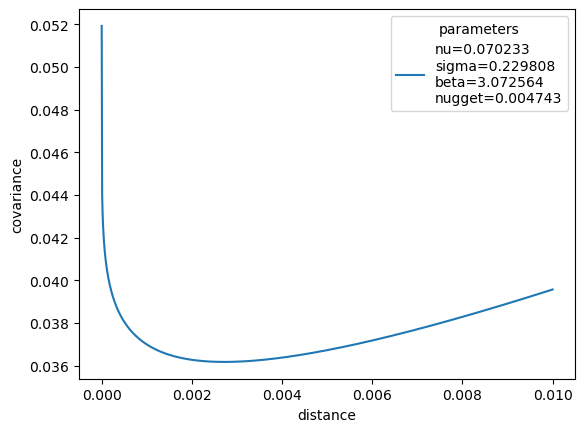

In [241]:

df_cov = pd.DataFrame({'distance':dist.numpy(), 'covariance':cov_matern.numpy(), 'lp':cov_matern_lp}, 'up':cov_matern_up)
ax = sns.lineplot(data=df_cov, x='distance', y='covariance')
ax.legend(title='parameters', loc='upper right', labels=[label_params])

In [288]:
d = dd.pivot('distance','label','covariance')
d.head()

label          0.0       1.0       2.0       3.0       4.0       5.0  \
distance                                                               
0.000000  0.176076  0.514377  0.001132  0.004047  0.004936  0.000041   
0.000101  0.164804  0.496141  0.000554  0.003717  0.003140  0.000118   
0.000202  0.162667  0.491301  0.000628  0.003750  0.003104  0.000218   
0.000303  0.161261  0.487912  0.000713  0.003807  0.003121  0.000319   
0.000404  0.160193  0.485223  0.000803  0.003874  0.003160  0.000419   

label          6.0       7.0       8.0       9.0  
distance                                          
0.000000  0.116467  0.044999  0.090014  0.101305  
0.000101  0.071878  0.024360  0.085683  0.052937  
0.000202  0.068476  0.023253  0.084702  0.050346  
0.000303  0.066426  0.022628  0.084052  0.048835  
0.000404  0.064954  0.022205  0.083559  0.047774